<a href="https://colab.research.google.com/github/kenza-ily/24UCL_HospitalReadmissionPred-DiabeticPatients/blob/pipeline/COMP0189_CW1_HVWM7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CW2: Hospital Readmission Prediction for Diabetic Patients


### Imports and setup


In [1]:
from google.colab import drive
drive.mount('/content/drive')
#As is, setting gpu=True will run the model on the connected GPU. Note, due to the size of the model, this will actually be slower than running in the CPU. See the extended exercise
gpu = False

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Basics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

# Extra
import random
import math
import warnings
# ML
## Basics
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
## Preprocessing
from sklearn.model_selection import StratifiedKFold
from sklearn.compose import ColumnTransformer
from scipy.stats import loguniform
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
## ML pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import BaggingRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import ElasticNet, Ridge, Lasso, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
## Metrics
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_squared_error, accuracy_score
from matplotlib.patches import Patch
# a trier
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import make_scorer
# Just in case -> to move up


# DL
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [3]:
# Saving a DataFrame as an image
def save_fig(df, filename='dataframe_image.png', width=12, height=8, dpi=300):
    """
    Saves a DataFrame as an image.

    Parameters:
    - df: DataFrame to be saved as an image.
    - filename: Name of the file to save the image as.
    - width: Width of the image in inches.
    - height: Height of the image in inches.
    - dpi: Dots per inch (resolution) of the image.
    """
    fig, ax = plt.subplots(figsize=(width, height))  # Use the width and height from the function parameters
    ax.axis('tight')
    ax.axis('off')
    tbl = table(ax, df, loc='center', cellLoc='center', rowLoc='center')

    # Optionally, adjust table properties here (e.g., fontsize, cell size)

    plt.subplots_adjust(left=0.2, bottom=0.2)

    # Save the figure as an image
    plt.savefig(filename, dpi=dpi, bbox_inches='tight')  # Use the filename and DPI from the function parameters

    # Close the figure to free memory
    plt.close(fig)

In [4]:
df_raw = pd.read_csv(f"/content/drive/MyDrive/CODE/24UCL/term2/AAI/CW1/data/diabetic_data.csv", encoding="utf-8")

df = df_raw.copy()
df.columns = df.columns.str.upper()

## I. Dataset description (5%)
- Describe the characteristics of the dataset (data types, sample-to-features ratio, etc)and use descriptive statistics and figures/plots to show the dataset characteristics.(2.5%)
- Describe the challenges with the dataset (missing data, unbalanced classes, etc).(2.5%)

In [5]:
df.head().T  # More features than 5 -> transpose gives a better vue


0          1  \
ENCOUNTER_ID                               2278392     149190   
PATIENT_NBR                                8222157   55629189   
RACE                                     Caucasian  Caucasian   
GENDER                                      Female     Female   
AGE                                         [0-10)    [10-20)   
WEIGHT                                           ?          ?   
ADMISSION_TYPE_ID                                6          1   
DISCHARGE_DISPOSITION_ID                        25          1   
ADMISSION_SOURCE_ID                              1          7   
TIME_IN_HOSPITAL                                 1          3   
PAYER_CODE                                       ?          ?   
MEDICAL_SPECIALTY         Pediatrics-Endocrinology          ?   
NUM_LAB_PROCEDURES                              41         59   
NUM_PROCEDURES                                   0          0   
NUM_MEDICATIONS                                  1         18   
NUMBER_OUTPATIENT                                0          0   
NUMBER_EMERGENCY                                 0          0   
NUMBER_INPATIENT                                 0          0   
DIAG_1                                      250.83        276   
DIAG_2                                           ?     250.01   
DIAG_3                                           ?        255   
NUMBER_DIAGNOSES                                 1          9   
MAX_GLU_SERUM                                 None       None   
A1CRESULT                                     None       None   
METFORMIN                                       No         No   
REPAGLINIDE                                     No         No   
NATEGLINIDE                                     No         No   
CHLORPROPAMIDE                                  No         No   
GLIMEPIRIDE                                     No         No   
ACETOHEXAMIDE                                   No         No   
GLIPIZIDE                                       No         No   
GLYBURIDE                                       No         No   
TOLBUTAMIDE                                     No         No   
PIOGLITAZONE                                    No         No   
ROSIGLITAZONE                                   No         No   
ACARBOSE                                        No         No   
MIGLITOL                                        No         No   
TROGLITAZONE                                    No         No   
TOLAZAMIDE                                      No         No   
EXAMIDE                                         No         No   
CITOGLIPTON                                     No         No   
INSULIN                                         No         Up   
GLYBURIDE-METFORMIN                             No         No   
GLIPIZIDE-METFORMIN                             No         No   
GLIMEPIRIDE-PIOGLITAZONE                        No         No   
METFORMIN-ROSIGLITAZONE                         No         No   
METFORMIN-PIOGLITAZONE                          No         No   
CHANGE                                          No         Ch   
DIABETESMED                                     No        Yes   
READMITTED                                      NO        >30   

                                        2          3          4  
ENCOUNTER_ID                        64410     500364      16680  
PATIENT_NBR                      86047875   82442376   42519267  
RACE                      AfricanAmerican  Caucasian  Caucasian  
GENDER                             Female       Male       Male  
AGE                               [20-30)    [30-40)    [40-50)  
WEIGHT                                  ?          ?          ?  
ADMISSION_TYPE_ID                       1          1          1  
DISCHARGE_DISPOSITION_ID                1          1          1  
ADMISSION_SOURCE_ID                     7          7          7  
TIME_IN_HOSPITAL                        2          2          1  
PAYER_C

In [6]:
print(f"df has {df.shape[1]} features and {df.shape[0]} samples")
print(f"The features are {df.columns}")


df has 50 features and 101766 samples
The features are Index(['ENCOUNTER_ID', 'PATIENT_NBR', 'RACE', 'GENDER', 'AGE', 'WEIGHT',
       'ADMISSION_TYPE_ID', 'DISCHARGE_DISPOSITION_ID', 'ADMISSION_SOURCE_ID',
       'TIME_IN_HOSPITAL', 'PAYER_CODE', 'MEDICAL_SPECIALTY',
       'NUM_LAB_PROCEDURES', 'NUM_PROCEDURES', 'NUM_MEDICATIONS',
       'NUMBER_OUTPATIENT', 'NUMBER_EMERGENCY', 'NUMBER_INPATIENT', 'DIAG_1',
       'DIAG_2', 'DIAG_3', 'NUMBER_DIAGNOSES', 'MAX_GLU_SERUM', 'A1CRESULT',
       'METFORMIN', 'REPAGLINIDE', 'NATEGLINIDE', 'CHLORPROPAMIDE',
       'GLIMEPIRIDE', 'ACETOHEXAMIDE', 'GLIPIZIDE', 'GLYBURIDE', 'TOLBUTAMIDE',
       'PIOGLITAZONE', 'ROSIGLITAZONE', 'ACARBOSE', 'MIGLITOL', 'TROGLITAZONE',
       'TOLAZAMIDE', 'EXAMIDE', 'CITOGLIPTON', 'INSULIN',
       'GLYBURIDE-METFORMIN', 'GLIPIZIDE-METFORMIN',
       'GLIMEPIRIDE-PIOGLITAZONE', 'METFORMIN-ROSIGLITAZONE',
       'METFORMIN-PIOGLITAZONE', 'CHANGE', 'DIABETESMED', 'READMITTED'],
      dtype='object')


In [7]:
# Single feature analysis -> latest studied
column = df.columns[49]  # set the column from its index

# Basic information
print(column)  # Print the column name
print(df[column].nunique())  # Number of unique values
print(df[column].unique())  # Values of the unique values

# Calculate the percentage of each unique value
value_counts = df[column].value_counts()
percentages = value_counts / len(df) * 100

# Create a new dataframe to store the results
table_data = {
    "Unique Value": value_counts.index,
    "Count": value_counts.values,
    "Percentage": percentages.values,
}
table_df = pd.DataFrame(table_data)

# Sort the dataframe by count in descending order
table_df = table_df.sort_values(by="Count", ascending=False)

table_df


READMITTED
3
['NO' '>30' '<30']


Unique Value  Count  Percentage
0           NO  54864   53.911916
1          >30  35545   34.928169
2          <30  11357   11.159916

In [8]:
# Replacing all sorts of missing values per NaN
df.replace(
    {"?": np.nan, "nan": np.nan, "Unknown/Invalid": np.nan, "Other": np.nan},
    inplace=True,
)


In [9]:
# Counting all sorts of missing data
missing_count = df.isnull().sum()
missing_percent = (missing_count / len(df)) * 100
missing_data = pd.DataFrame(
    {"Missing Count": missing_count, "Missing Percentage": missing_percent}
)
missing_data = missing_data[missing_data["Missing Count"] > 0]
# Sort and display
missing_data_sorted = missing_data.sort_values(by="Missing Percentage", ascending=False)
display(missing_data_sorted)


Missing Count  Missing Percentage
WEIGHT                     98569           96.858479
MEDICAL_SPECIALTY          49949           49.082208
PAYER_CODE                 40256           39.557416
RACE                        3779            3.713421
DIAG_3                      1423            1.398306
DIAG_2                       358            0.351787
DIAG_1                        21            0.020636
GENDER                         3            0.002948

In [10]:
# RACE and GENDER should be the same for each patient: if not, we can't fill the missing values

## Assess if the missing values can be found elsewhere for the same patient
unknown_race_patients = df[df["RACE"].isnull()][["PATIENT_NBR", "RACE"]]
unknown_gender_patients = df[df["GENDER"].isnull()][["PATIENT_NBR", "GENDER"]]

multiple_unknown_race_patients = unknown_race_patients[
    unknown_race_patients.duplicated("PATIENT_NBR", keep=False)
]
multiple_unknown_gender_patients = unknown_gender_patients[
    unknown_gender_patients.duplicated("PATIENT_NBR", keep=False)
]

print(
    f"They are {multiple_unknown_race_patients['RACE'].count()} rows that can be filled with the same RACE value"
)
print(
    f"They are {multiple_unknown_gender_patients['GENDER'].count()} rows that can be filled with the same GENDER value"
)


They are 0 rows that can be filled with the same RACE value
They are 0 rows that can be filled with the same GENDER value


In [11]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   ENCOUNTER_ID              101766 non-null  int64 
 1   PATIENT_NBR               101766 non-null  int64 
 2   RACE                      97987 non-null   object
 3   GENDER                    101763 non-null  object
 4   AGE                       101766 non-null  object
 5   WEIGHT                    3197 non-null    object
 6   ADMISSION_TYPE_ID         101766 non-null  int64 
 7   DISCHARGE_DISPOSITION_ID  101766 non-null  int64 
 8   ADMISSION_SOURCE_ID       101766 non-null  int64 
 9   TIME_IN_HOSPITAL          101766 non-null  int64 
 10  PAYER_CODE                61510 non-null   object
 11  MEDICAL_SPECIALTY         51817 non-null   object
 12  NUM_LAB_PROCEDURES        101766 non-null  int64 
 13  NUM_PROCEDURES            101766 non-null  int64 
 14  NUM_

In [12]:
# Number of unique values per feature
toomany_cat=['DIAG_1','DIAG_2','DIAG_3','MEDICAL_SPECIALTY']

for col in list(toomany_cat):
    print(
        "Number of Unique values in {} :  {} ".format(col, df[col].value_counts().shape[0])
    )


Number of Unique values in DIAG_1 :  716 
Number of Unique values in DIAG_2 :  748 
Number of Unique values in DIAG_3 :  789 
Number of Unique values in MEDICAL_SPECIALTY :  72 


In [13]:
print(df.dtypes.unique())  # Check the types of the features


[dtype('int64') dtype('O')]


In [14]:
cat_cols = [col for col in df.columns if df[col].dtypes == "O"]
num_cols = [col for col in df.columns if df[col].dtypes == "int64"]

print(f"Number of object columns: {len(cat_cols)}")
print(f"Number of int64 columns: {len(num_cols)}")


Number of object columns: 37
Number of int64 columns: 13


In [15]:
id_cols = [
    "ENCOUNTER_ID",
    "PATIENT_NBR",  # Side note: Should have been called "PATIENT_ID"
    "DISCHARGE_DISPOSITION_ID",
    "ADMISSION_SOURCE_ID",
    "ADMISSION_TYPE_ID",
]
num_cols = [col for col in num_cols if col not in id_cols]


In [16]:
empty_coltodrop = []


In [17]:
# FEATURE SEPARATION

## TARGET
target = "READMITTED"
print(f"The target is {target}")

## FEATURES
features = [col for col in df.columns if col != target]
num_cols = [col for col in num_cols if col != target]

### PRINTING
print("cat_cols:", len(cat_cols), cat_cols)
print("num_cols:", len(num_cols), num_cols)
print("id_columns", len(id_cols), id_cols)


The target is READMITTED
cat_cols: 37 ['RACE', 'GENDER', 'AGE', 'WEIGHT', 'PAYER_CODE', 'MEDICAL_SPECIALTY', 'DIAG_1', 'DIAG_2', 'DIAG_3', 'MAX_GLU_SERUM', 'A1CRESULT', 'METFORMIN', 'REPAGLINIDE', 'NATEGLINIDE', 'CHLORPROPAMIDE', 'GLIMEPIRIDE', 'ACETOHEXAMIDE', 'GLIPIZIDE', 'GLYBURIDE', 'TOLBUTAMIDE', 'PIOGLITAZONE', 'ROSIGLITAZONE', 'ACARBOSE', 'MIGLITOL', 'TROGLITAZONE', 'TOLAZAMIDE', 'EXAMIDE', 'CITOGLIPTON', 'INSULIN', 'GLYBURIDE-METFORMIN', 'GLIPIZIDE-METFORMIN', 'GLIMEPIRIDE-PIOGLITAZONE', 'METFORMIN-ROSIGLITAZONE', 'METFORMIN-PIOGLITAZONE', 'CHANGE', 'DIABETESMED', 'READMITTED']
num_cols: 8 ['TIME_IN_HOSPITAL', 'NUM_LAB_PROCEDURES', 'NUM_PROCEDURES', 'NUM_MEDICATIONS', 'NUMBER_OUTPATIENT', 'NUMBER_EMERGENCY', 'NUMBER_INPATIENT', 'NUMBER_DIAGNOSES']
id_columns 5 ['ENCOUNTER_ID', 'PATIENT_NBR', 'DISCHARGE_DISPOSITION_ID', 'ADMISSION_SOURCE_ID', 'ADMISSION_TYPE_ID']


### 1/ Target encoding


In [18]:
unique_values = df[target].unique()
print(unique_values)
value_counts = df[target].value_counts()
print(value_counts)


['NO' '>30' '<30']
NO     54864
>30    35545
<30    11357
Name: READMITTED, dtype: int64


In [19]:
# Target encoding
df["READMITTED"] = df["READMITTED"].apply(lambda x: 0 if x == "NO" else 1)


In [20]:
unique_values = df["READMITTED"].unique()
print(unique_values)
value_counts = df["READMITTED"].value_counts()
print(value_counts)


[0 1]
0    54864
1    46902
Name: READMITTED, dtype: int64


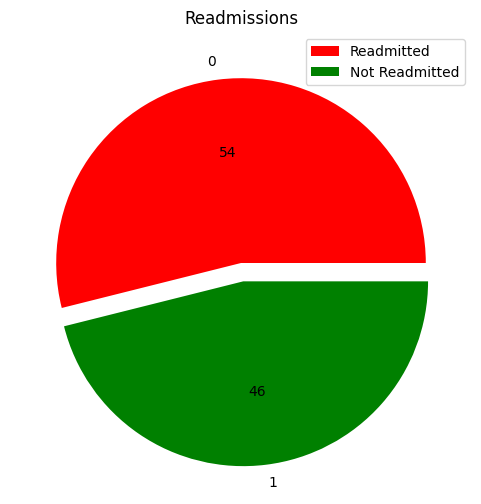

In [21]:
labels = df[target].unique()
count = df[target].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(
    count,
    labels=labels,
    autopct="%.0f",
    explode=(0, 0.1),
    colors=["red", "green"],
)
plt.legend(["Readmitted", "Not Readmitted"], loc=1)

plt.title("Readmissions")
plt.show()


The following snippets aim at identifying the meaning behind "READMISSION", raising the following questions:

- To understand the readmission rate, the distribution encompasses patients that came back more than 2 times: in order to clearly map if a patient might be readmitted in a hospital, the important information is to know if he'll come back or not, then to map if he came back or not. An interesting perspective would be to see home many unique patients they are, and assess that a patient that has a second encounter was readmitted, and a patient that didn't have a second encounter was not. This data may be more effective in assessing if the patient was readmitted or not and create the needed regression. Data about how he way treated during his readmission may not be relevant here.
- This dataset follows patients for 10 years. Some patients may have multiple encounters in a decade for different conditions. An option would have been to consider encounters with a readmission of over 30 years as if it was a new patient. This paradigm would consider that a patient coming for a single condition would be readmitted within 30 days, and that readmission is assessed for one condition only.

These hypotheses will be further develop at the end of the coursework.


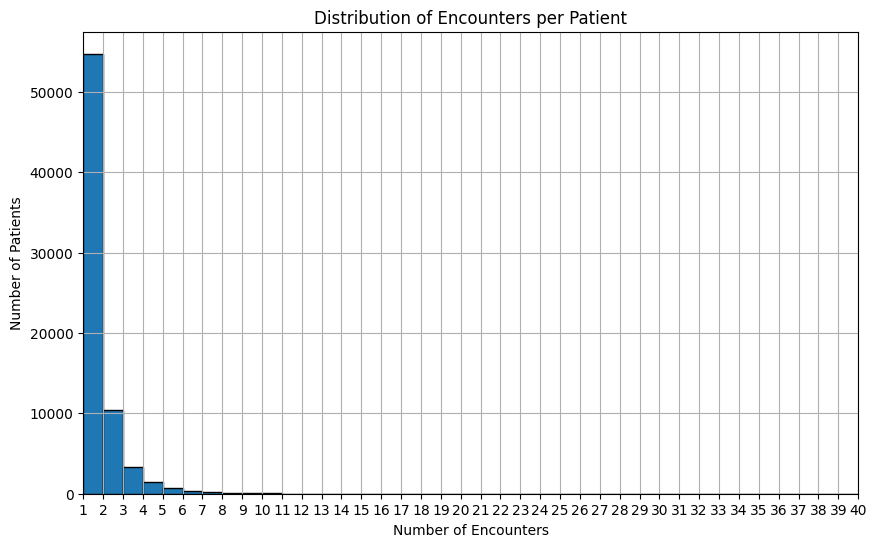

In [22]:
# Calculate the number of encounters per patient
encounters_per_patient = df.groupby("PATIENT_NBR")["ENCOUNTER_ID"].nunique()

# Plot the distribution
plt.figure(figsize=(10, 6))
encounters_per_patient.hist(
    bins=range(1, encounters_per_patient.max() + 1), edgecolor="black"
)
plt.title("Distribution of Encounters per Patient")
plt.xlabel("Number of Encounters")
plt.ylabel("Number of Patients")
plt.xticks(range(1, encounters_per_patient.max() + 1))
plt.xlim(1, encounters_per_patient.max())
plt.show()


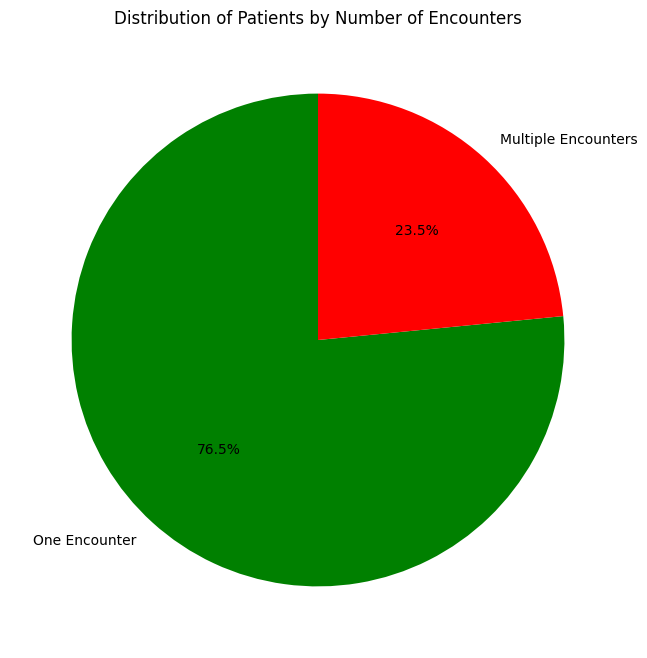

In [23]:
# Understanding the representation of patients that came multiple times
## Creating a binary df
encounters_per_patient_binary = encounters_per_patient.map(lambda x: 0 if x == 1 else 1)

## Count occurrences of 0 and 1 in encounters_per_patient_binary
counts = encounters_per_patient_binary.value_counts()

## Plot the pie chart
plt.figure(figsize=(8, 8))
counts.plot(
    kind="pie",
    labels=["One Encounter", "Multiple Encounters"],
    autopct="%1.1f%%",
    startangle=90,
    colors=["green", "red"]
)
plt.title("Distribution of Patients by Number of Encounters")
plt.ylabel("")  # Remove y-axis label for clarity
plt.show()


This information tells us that in practise, 23% of the patients had multiple encounters - hence were readmitted, which is not the number of readmission that is a little bit over 45%.
The aim is "to predict which patients will need hospital readmission."
Here the definition of "readmission" can be tricky: Is it based on the first encounter? Or, on each encounter, to predict if he may come back?


In [24]:
# Quick random data visualisation for encounters and readmission

# Ensure 'PATIENT_NBR' column is present
if "PATIENT_NBR" in df.columns:
    # Randomly select a PATIENT_NBR from the DataFrame
    index = random.choice(df["PATIENT_NBR"].unique())
else:
    print("PATIENT_NBR column not found in DataFrame")

# Sorting df by 'ENCOUNTER_ID'
df_sorted = df.sort_values(by="ENCOUNTER_ID")

# Display the first few rows for the randomly selected PATIENT_NBR
df_sorted.loc[df_sorted["PATIENT_NBR"] == index][["ENCOUNTER_ID", "READMITTED"]].head()


ENCOUNTER_ID  READMITTED
26186      86526900           0

In [25]:
# Group by 'PATIENT_NBR' and find the index of the minimum 'ENCOUNTER_ID' for each group
df_simplified = df_raw.copy()
df_simplified.columns = df_simplified.columns.str.upper()


In [26]:
df_simplified.shape


(101766, 50)

In [27]:
df_simplified["READMITTED"] = df_simplified["READMITTED"].map(
    {"NO": 0, "<30": 1, ">30": 0}
)


In [28]:
print(df_simplified["READMITTED"].unique())
print(df_simplified["READMITTED"].value_counts())


[0 1]
0    90409
1    11357
Name: READMITTED, dtype: int64


In [29]:
# Keep only the encounter_id with the lower number
df_simplified = df_simplified.sort_values("ENCOUNTER_ID").drop_duplicates(
    "PATIENT_NBR", keep="first"
)
df_simplified.shape


(71518, 50)

In [30]:
df_simplified.head()


ENCOUNTER_ID  PATIENT_NBR             RACE  GENDER       AGE WEIGHT  \
8          12522     48330783        Caucasian  Female   [80-90)      ?   
9          15738     63555939        Caucasian  Female  [90-100)      ?   
4          16680     42519267        Caucasian    Male   [40-50)      ?   
10         28236     89869032  AfricanAmerican  Female   [40-50)      ?   
5          35754     82637451        Caucasian    Male   [50-60)      ?   

    ADMISSION_TYPE_ID  DISCHARGE_DISPOSITION_ID  ADMISSION_SOURCE_ID  \
8                   2                         1                    4   
9                   3                         3                    4   
4                   1                         1                    7   
10                  1                         1                    7   
5                   2                         1                    2   

    TIME_IN_HOSPITAL  ... CITOGLIPTON INSULIN  GLYBURIDE-METFORMIN  \
8                 13  ...          No  Steady                   No   
9                 12  ...          No  Steady                   No   
4                  1  ...          No  Steady                   No   
10                 9  ...          No  Steady                   No   
5                  3  ...          No  Steady                   No   

    GLIPIZIDE-METFORMIN  GLIMEPIRIDE-PIOGLITAZONE  METFORMIN-ROSIGLITAZONE  \
8                    No                        No                       No   
9                    No                        No                       No   
4                    No                        No                       No   
10                   No                        No                       No   
5                    No                        No                       No   

    METFORMIN-PIOGLITAZONE  CHANGE DIABETESMED READMITTED  
8                       No      Ch         Yes          0  
9                       No      Ch         Yes          0  
4                       No      Ch         Yes          0  
10                      No      No         Yes          0  
5                       No      No         Yes          0  

[5 rows x 50 columns]

### 1/ Numerical columns


In [31]:
df_num = df[num_cols]


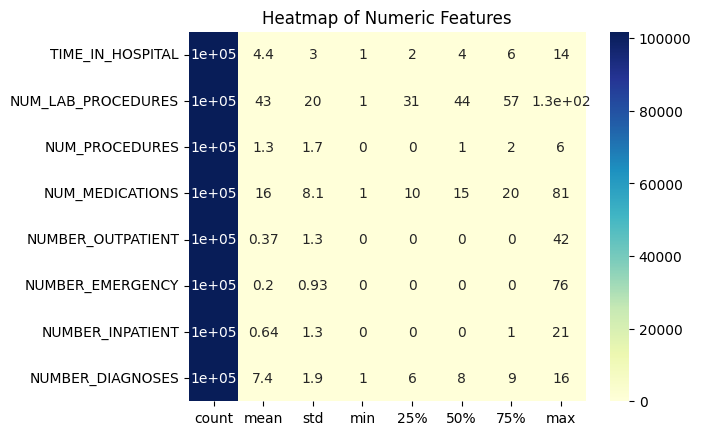

In [32]:
sns.heatmap(df_num.describe().T, annot=True, cmap="YlGnBu")
plt.title("Heatmap of Numeric Features")
plt.show()


<ipython-input-33-c0f17460882f>:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  df_num.hist(bins=20, ax=ax[0])


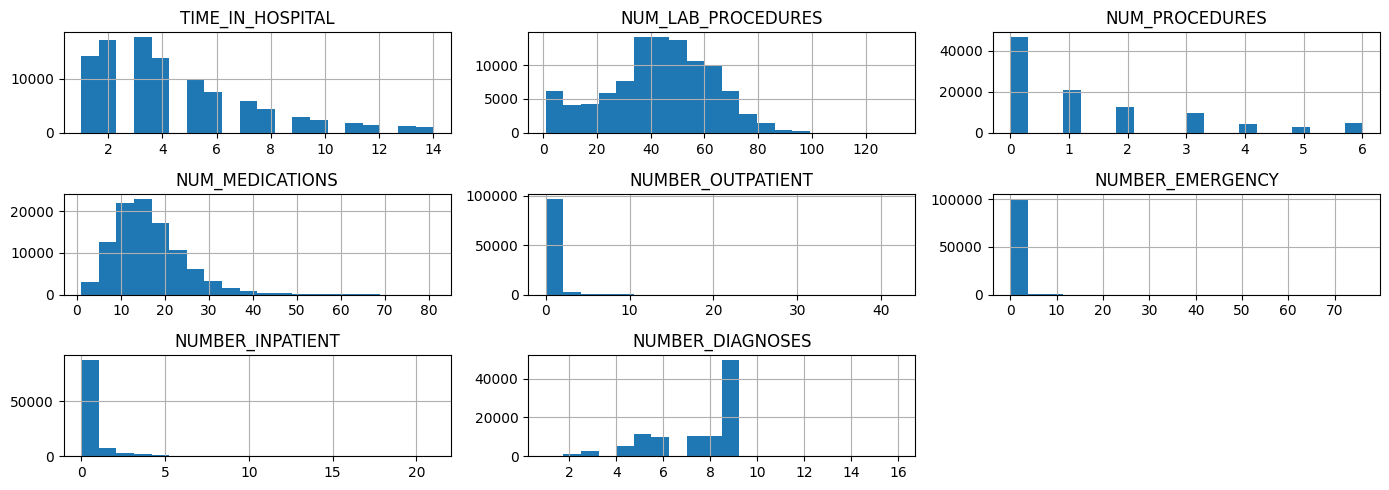

In [33]:
# Normal histograms for all numerical values

fig, ax = plt.subplots(1, 2, figsize=(14, 5))  # 1 row, 2 columns for two subplots
df_num.hist(bins=20, ax=ax[0])
ax[0].set_xlabel(num_cols)
ax[0].set_title(num_cols)

plt.tight_layout()  # Adjust layout for better spacing
plt.show()


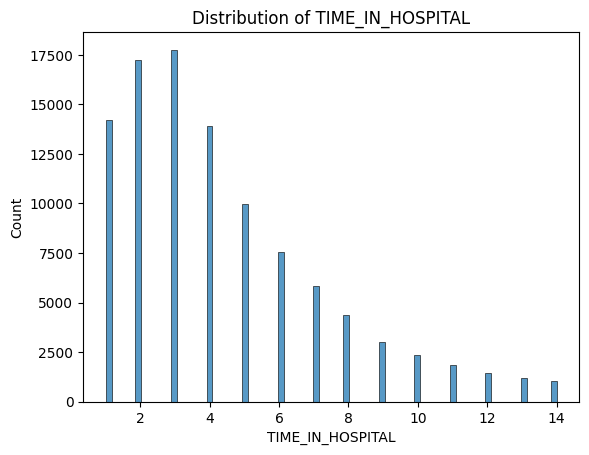

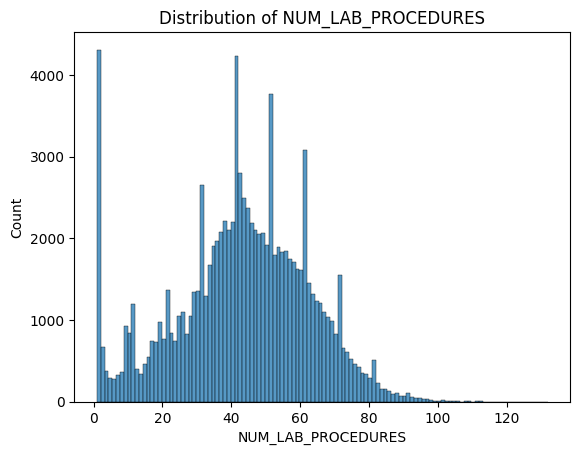

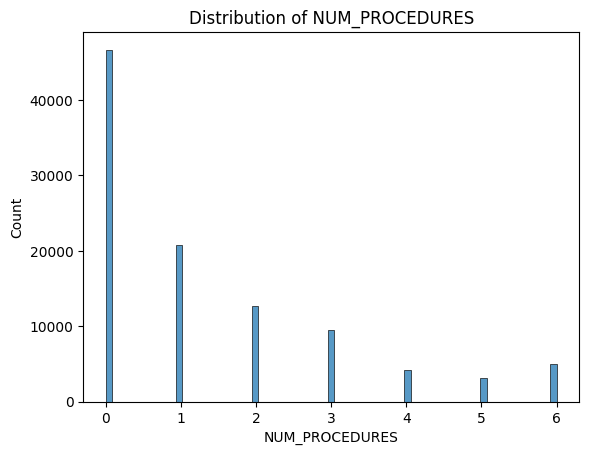

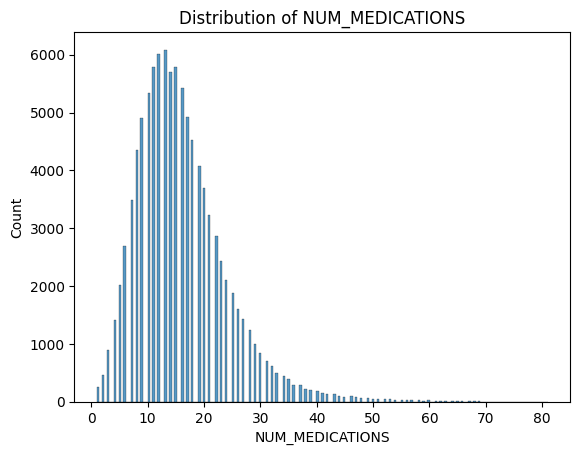

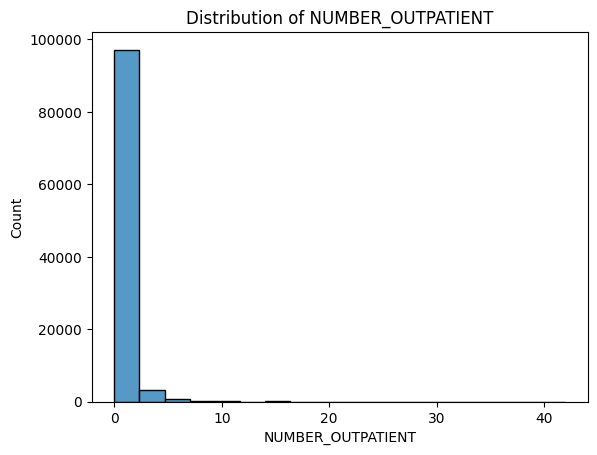

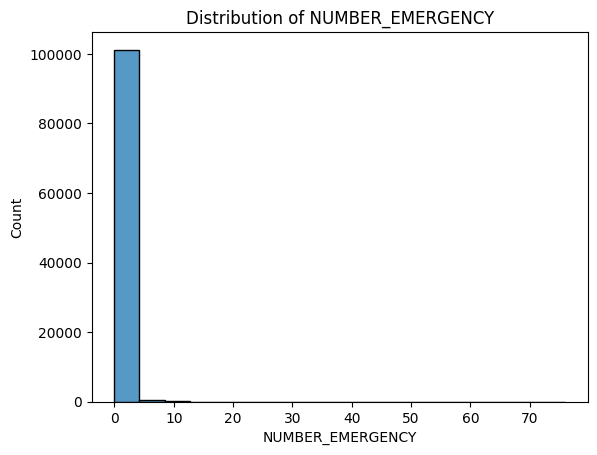

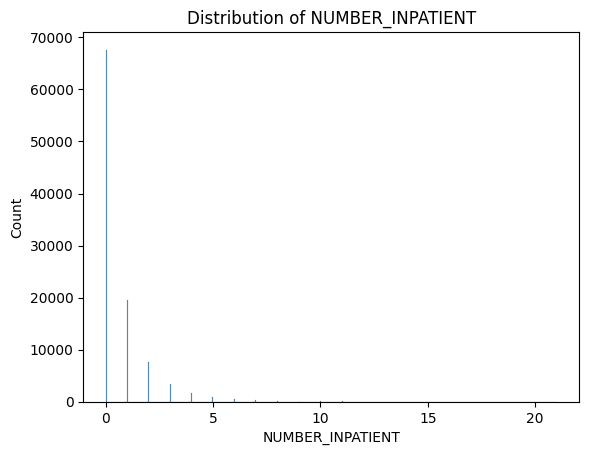

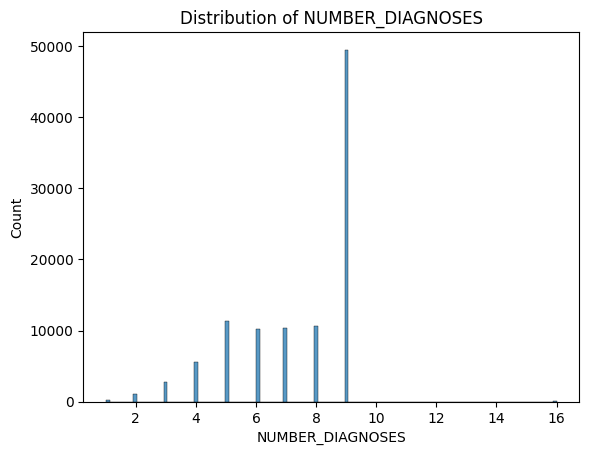

In [34]:
# Normal histograms for all numerical values
for col in num_cols:
    sns.histplot(df[col])
    plt.xlabel(col)
    plt.ylabel("Count")
    plt.title(f"Distribution of {col}")
    plt.show()


<ipython-input-35-f3f51d1d4f80>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="READMITTED", data=df, ax=axes[1], palette="Set2")


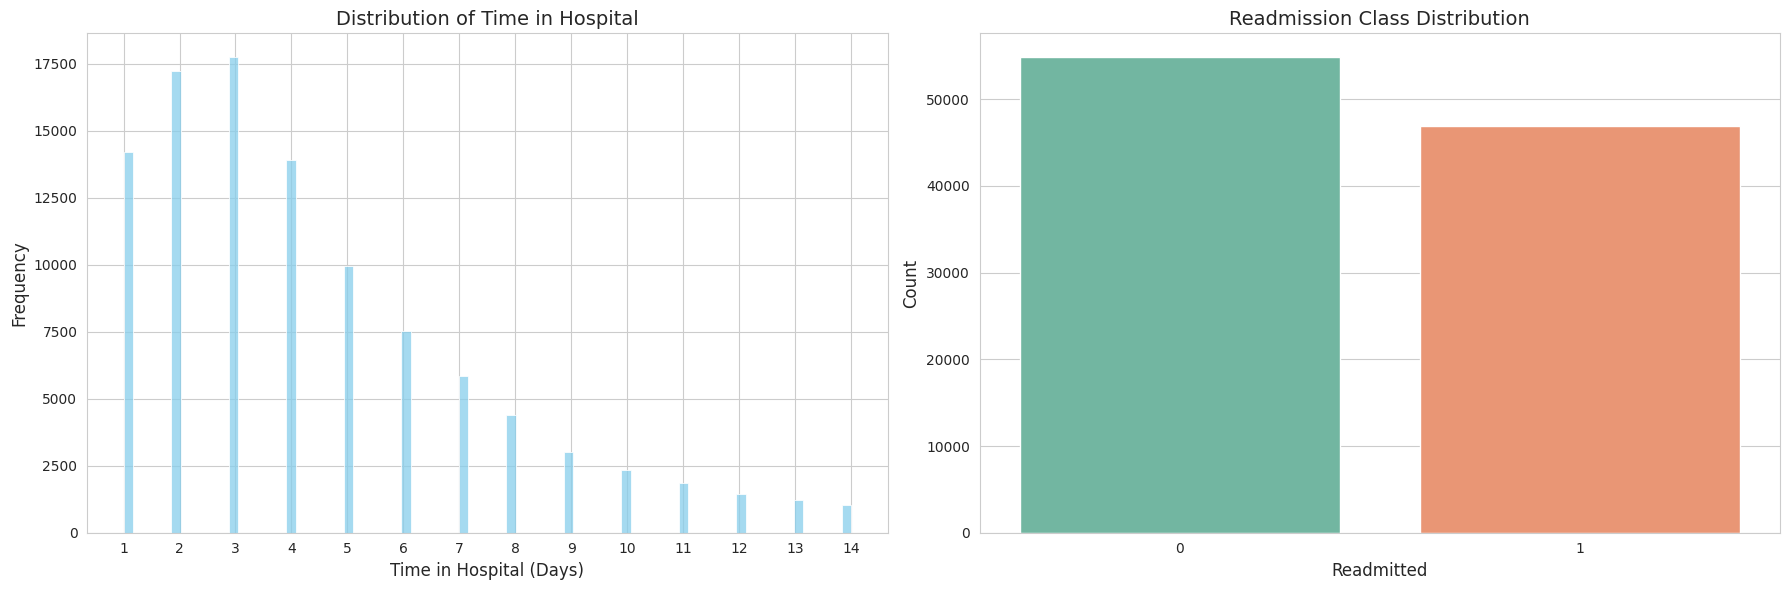

In [35]:
# Set the style of seaborn
sns.set_style("whitegrid")

# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Histogram for a numerical feature - 'TIME_IN_HOSPITAL' as an example
sns.histplot(df["TIME_IN_HOSPITAL"], ax=axes[0], color="skyblue")
axes[0].set_title("Distribution of Time in Hospital", fontsize=14)
axes[0].set_xlabel("Time in Hospital (Days)", fontsize=12)
axes[0].set_ylabel("Frequency", fontsize=12)

# Set x-axis tick labels for the histogram
axes[0].set_xticks(df["TIME_IN_HOSPITAL"].unique())

# Bar plot for class distribution in 'READMITTED'
sns.countplot(x="READMITTED", data=df, ax=axes[1], palette="Set2")
axes[1].set_title("Readmission Class Distribution", fontsize=14)
axes[1].set_xlabel("Readmitted", fontsize=12)
axes[1].set_ylabel("Count", fontsize=12)

plt.tight_layout()
plt.show()


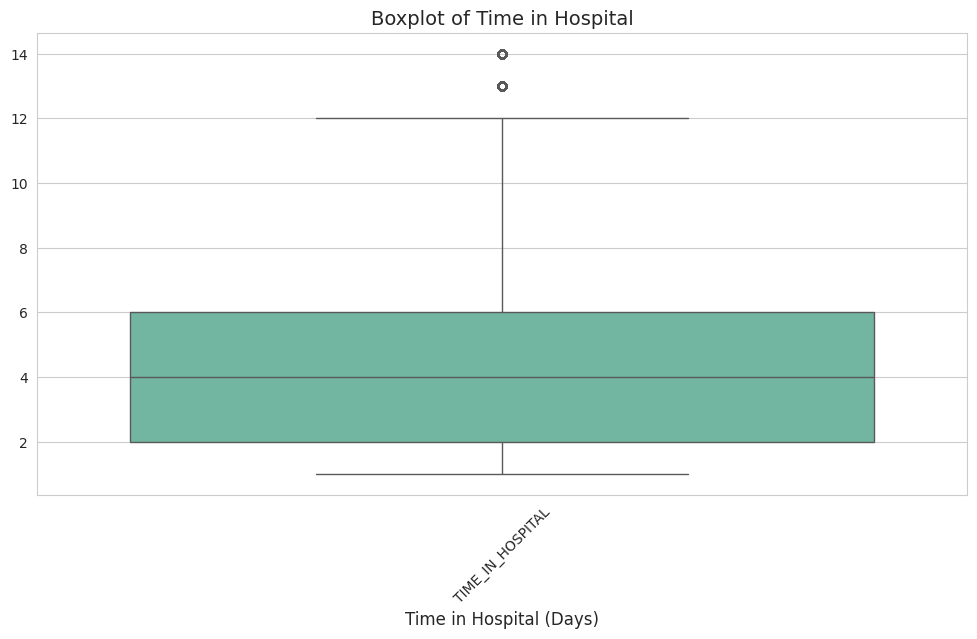

In [36]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df[["TIME_IN_HOSPITAL"]], palette="Set2")
plt.title("Boxplot of Time in Hospital", fontsize=14)
plt.xlabel("Time in Hospital (Days)", fontsize=12)
plt.xticks(rotation=45)
plt.show()


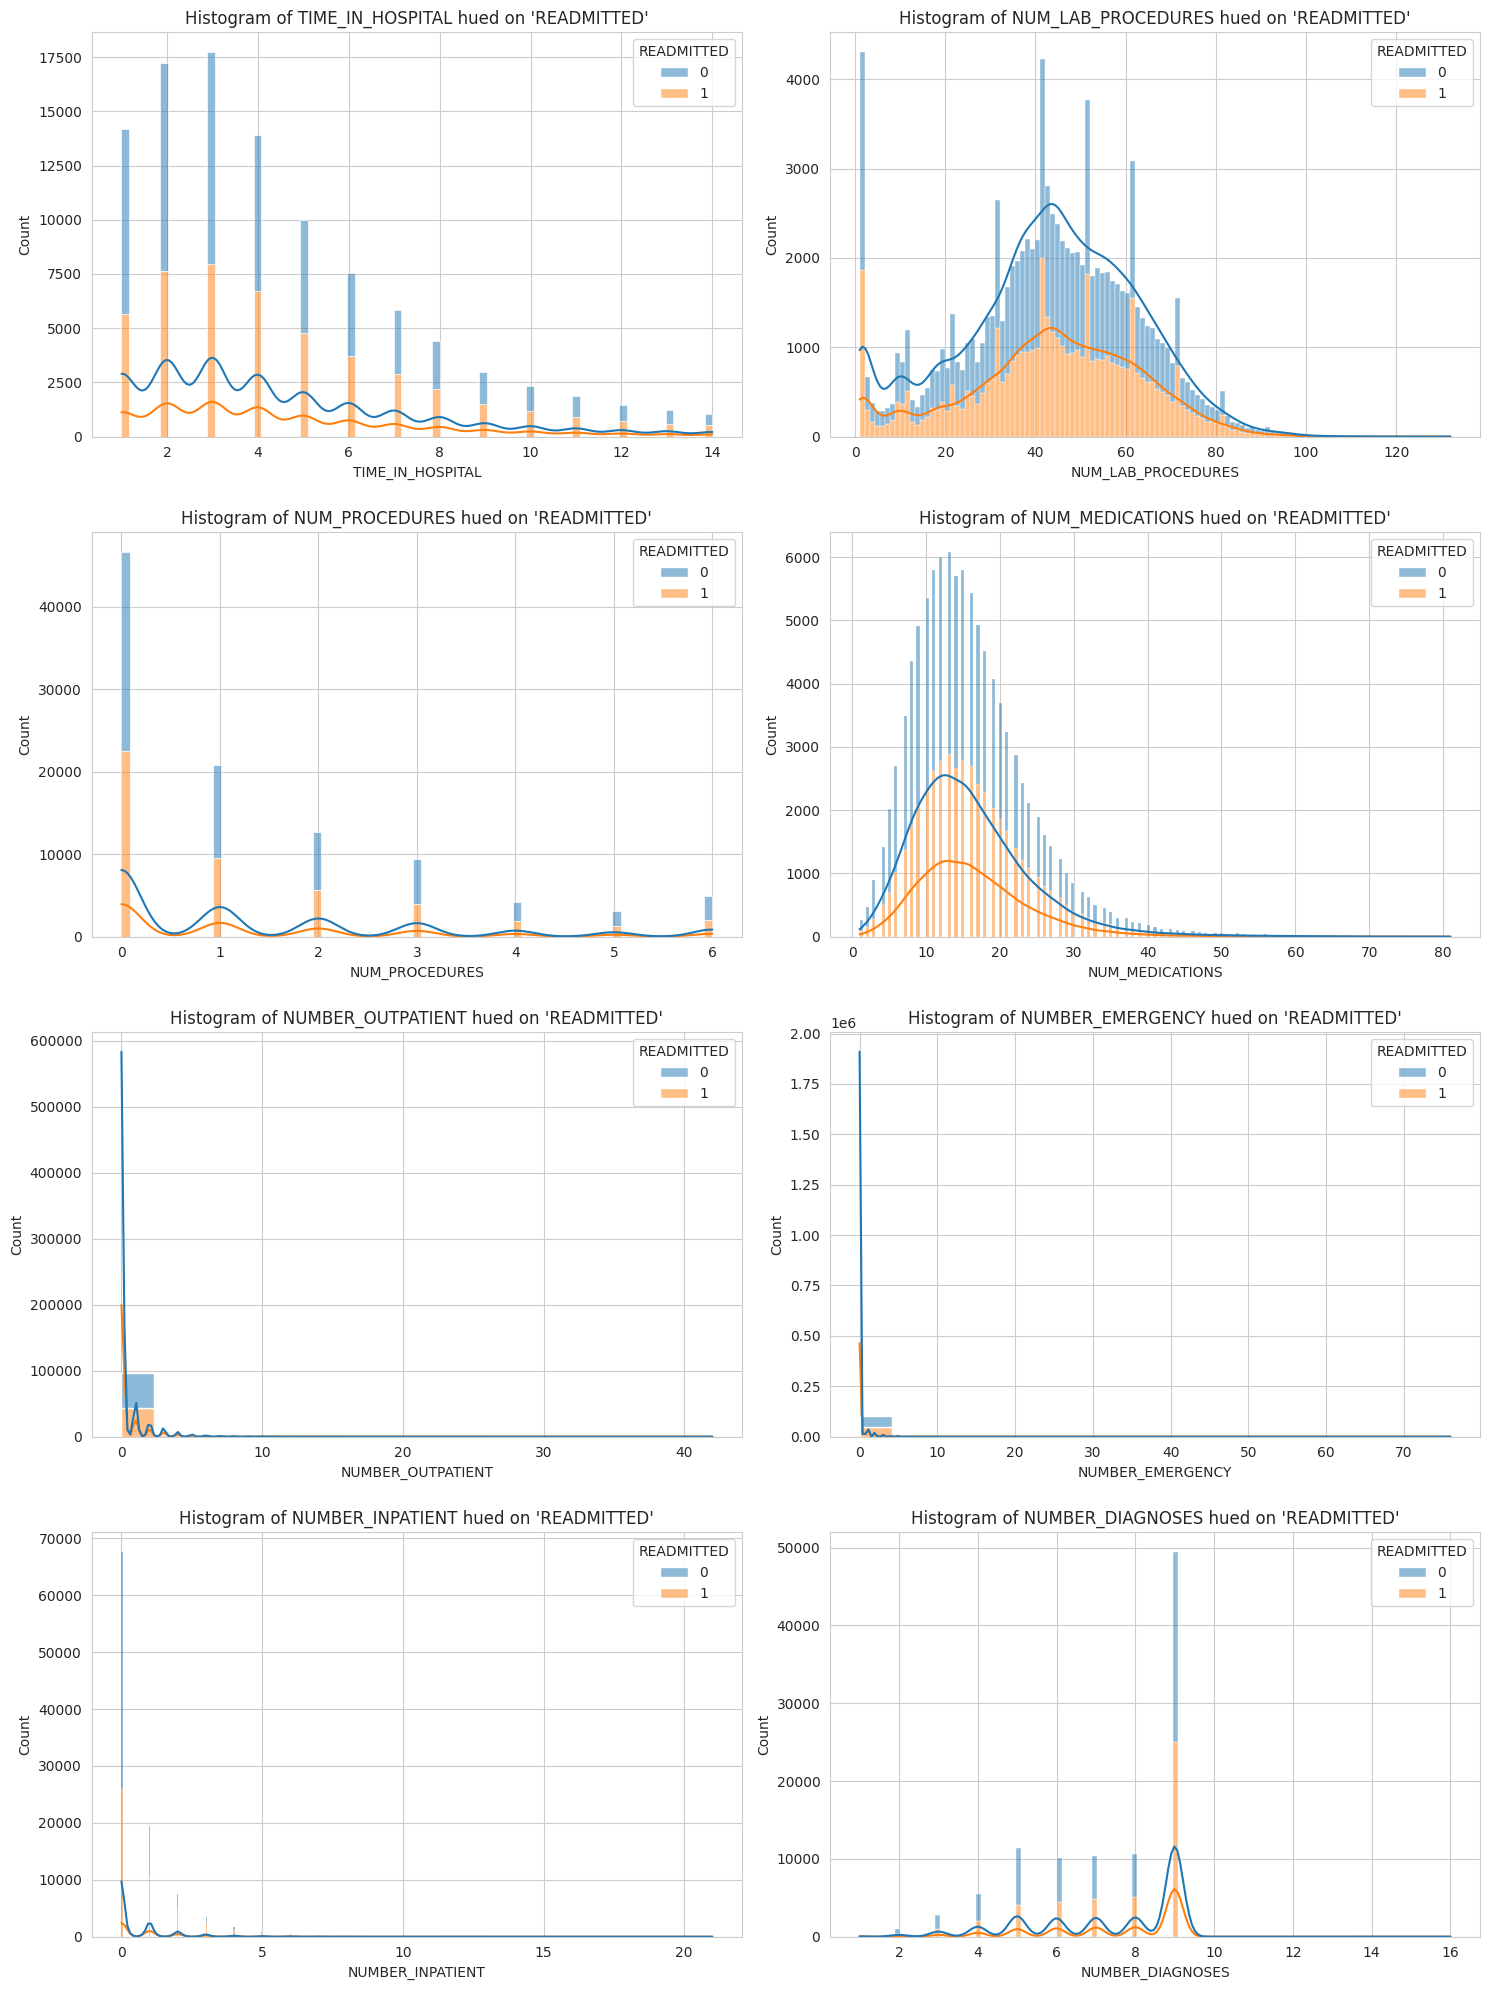

In [37]:
# Hued histogram

fig, axes = plt.subplots(
    len(num_cols) // 2 + len(num_cols) % 2,
    2,
    figsize=(15, 5 * (len(num_cols) // 2 + len(num_cols) % 2)),
)

# Iterate over each numerical column and plot the histogram hued on "READMITTED"
for i, num_col in enumerate(
    num_cols
):  # Corrected variable name from 'col' to 'num_col'
    row = i // 2
    col_idx = i % 2  # Corrected variable name from 'col' to 'col_idx'
    sns.histplot(
        data=df,
        x=num_col,
        hue="READMITTED",
        ax=axes[row, col_idx],
        multiple="stack",
        kde=True,
    )

    # Set the title and labels for each subplot
    axes[row, col_idx].set_title(f"Histogram of {num_col} hued on 'READMITTED'")
    axes[row, col_idx].set_xlabel(num_col)
    axes[row, col_idx].set_ylabel("Count")

# If the number of numerical columns is odd, remove the last subplot (which is empty)
if len(num_cols) % 2 != 0:
    fig.delaxes(axes[-1, -1])

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


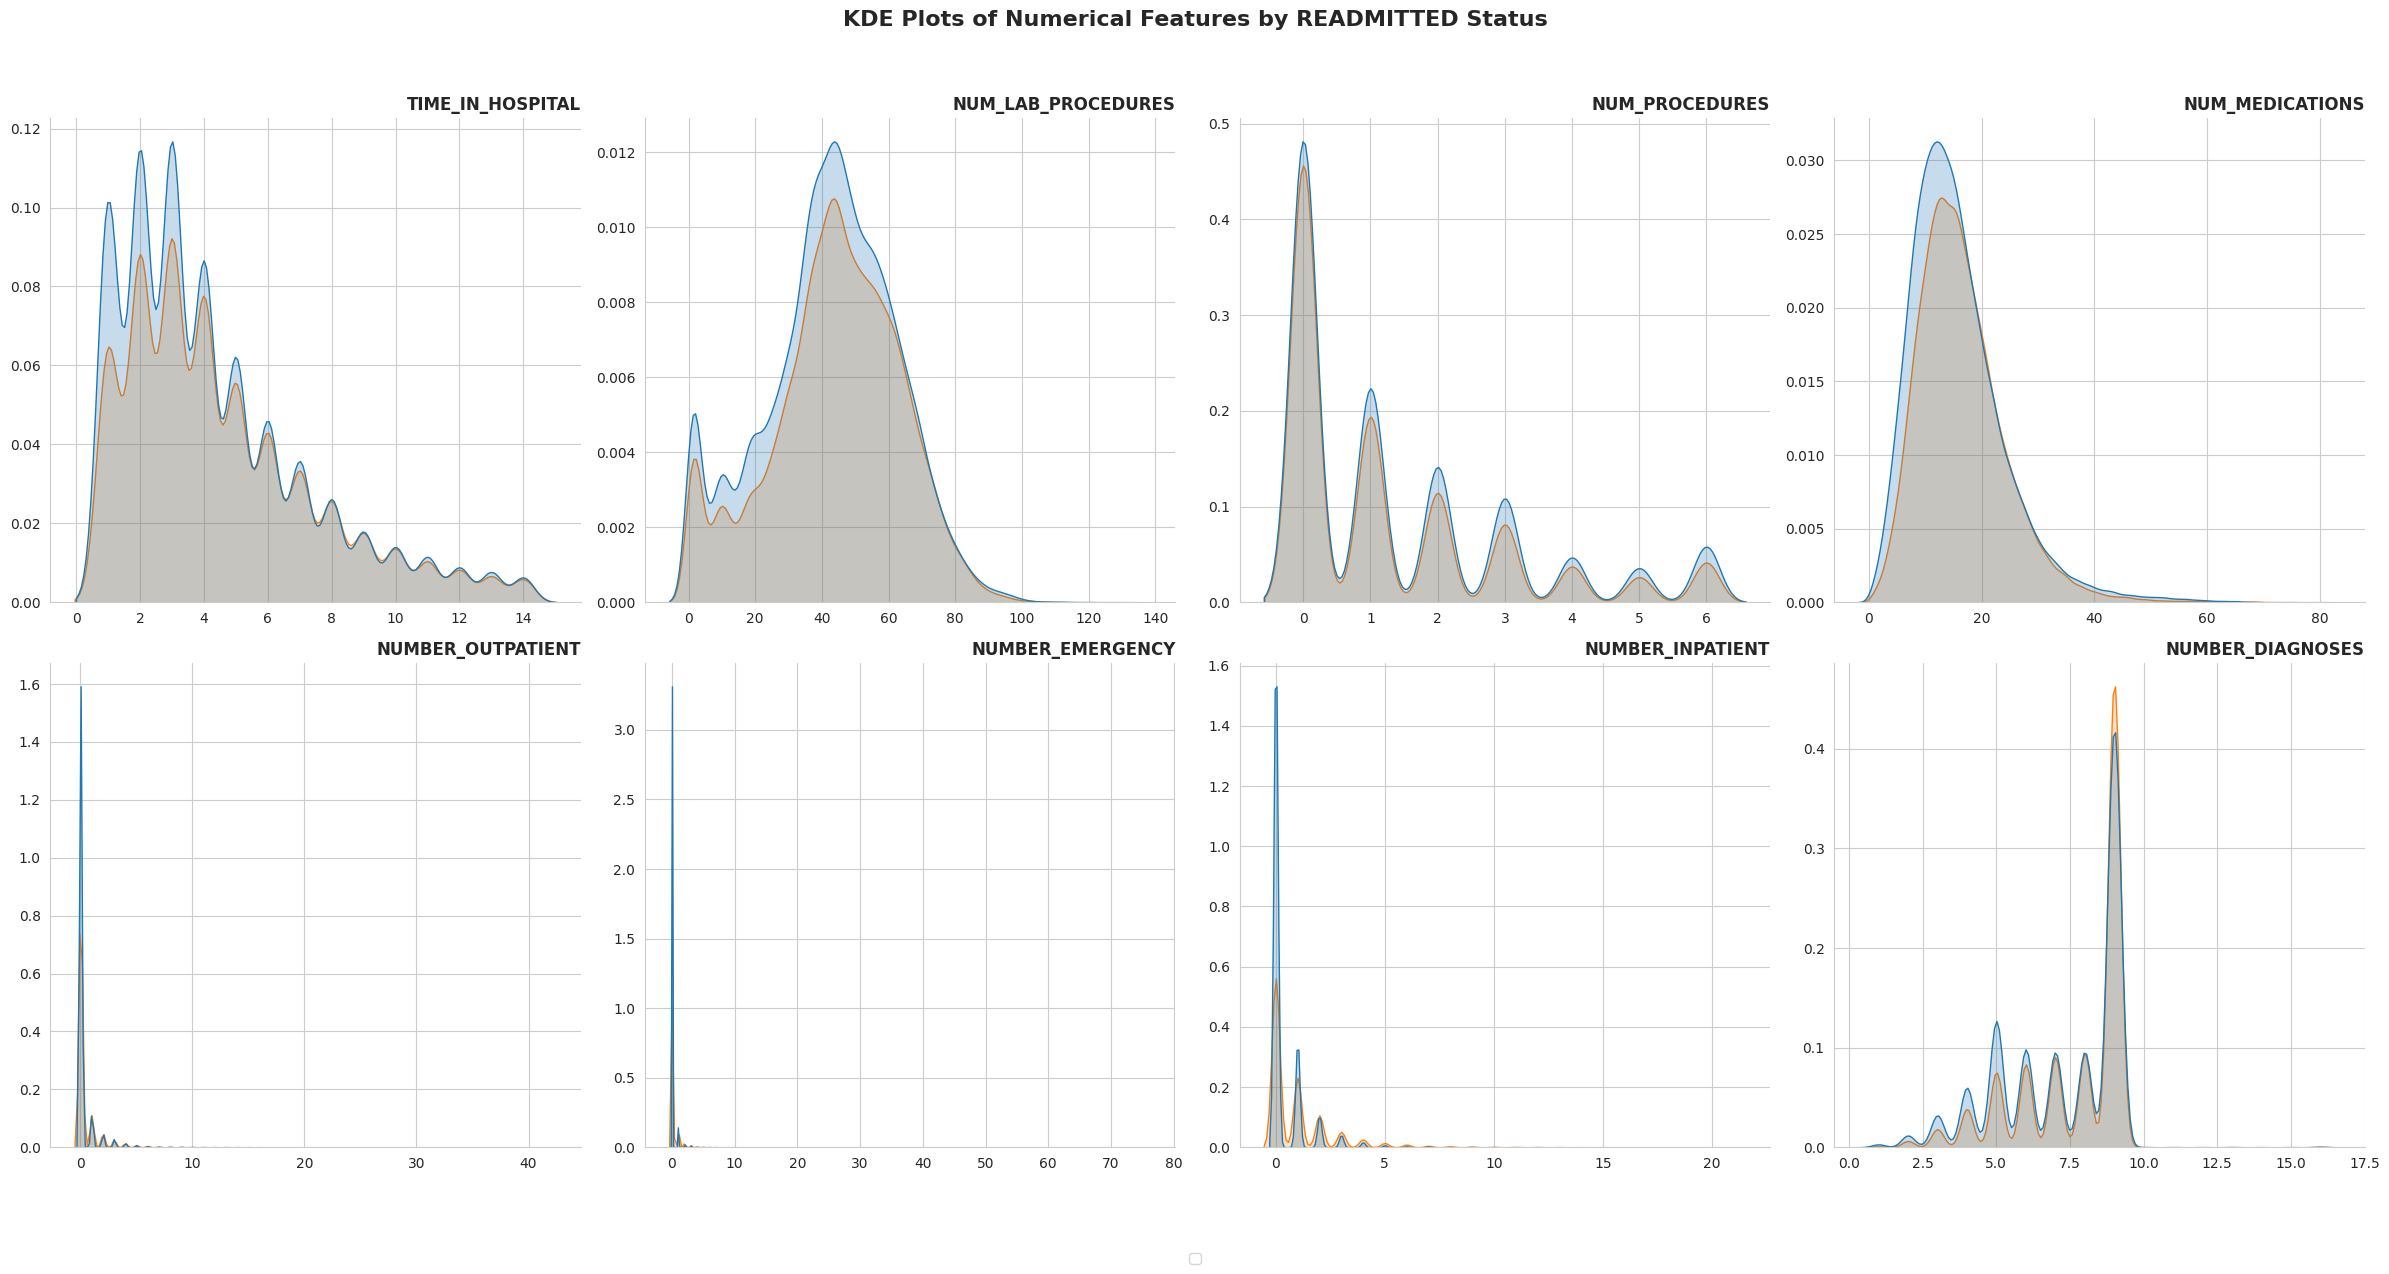

In [38]:
# KDE Plot - Target hued

# Determine the layout of the subplots based on the number of numerical columns
num_features = len(num_cols)
num_columns = 4  # Number of columns in the subplot grid
num_rows = num_features // num_columns + (num_features % num_columns > 0)
figsize = (
    6 * num_columns,
    6 * num_rows,
)  # Adjusted figsize based on the number of subplots
fig = plt.figure(figsize=figsize)

for idx, col in enumerate(num_cols):
    ax = plt.subplot(num_rows, num_columns, idx + 1)
    sns.kdeplot(data=df, x=col, hue="READMITTED", fill=True, legend=False, ax=ax)

    # Improve subplot aesthetics
    ax.set_ylabel("")
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("")
    ax.spines["right"].set_visible(False)
    ax.set_title(f"{col}", loc="right", weight="bold", fontsize=12)

# Adjust the layout and add a title
plt.subplots_adjust(top=0.92)  # Adjust top spacing to fit the suptitle
fig.suptitle(
    "KDE Plots of Numerical Features by READMITTED Status",
    ha="center",
    fontweight="bold",
    fontsize=16,
)

# Add a legend for hue colors
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2)

plt.tight_layout(
    rect=[0, 0, 1, 0.95]
)  # Adjust the rect parameter to make space for the title and legend
plt.show()


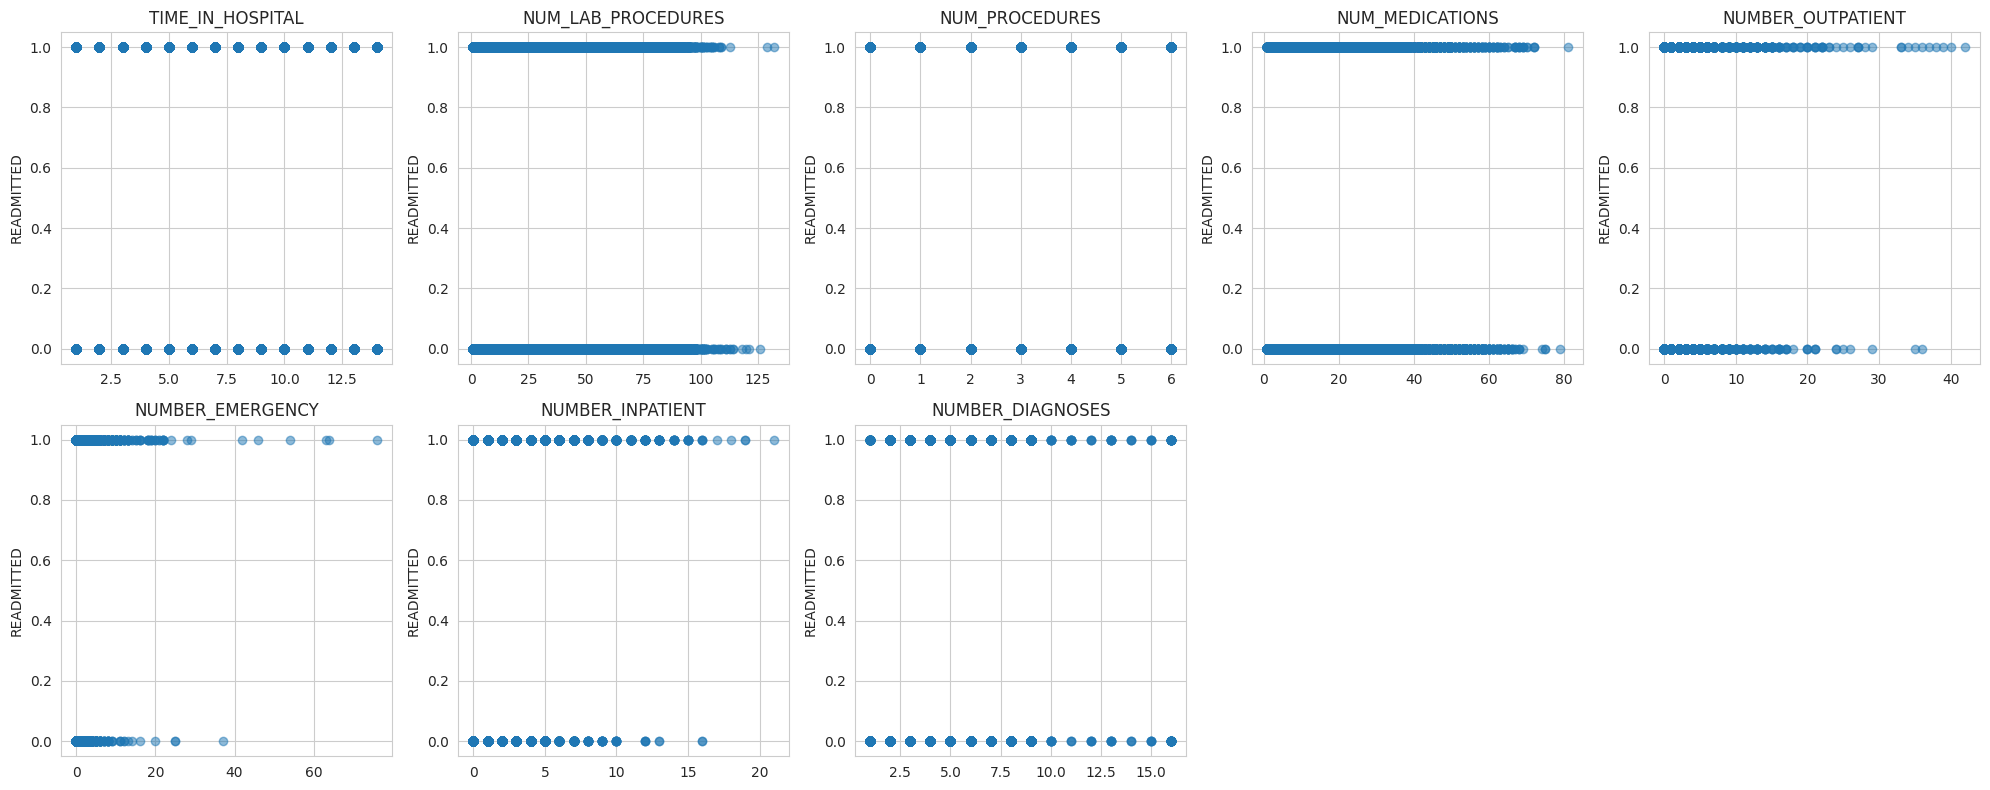

In [39]:
# Scatter plot

# Display settings
n_cols = 5  # Number of subplot columns (you can adjust this based on your preference)
n_rows = int(np.ceil(len(df_num.columns) / n_cols))


fig, axes = plt.subplots(
    n_rows, n_cols, figsize=(20, 4 * n_rows)
)  # Adjust the subplot grid and figure size

# Target setting
y = df["READMITTED"]

# Flatten the axes array for easy iteration if there's more than one row
if n_rows > 1:
    axes = axes.ravel()
else:
    axes = [axes]  # Ensure axes is iterable even with a single subplot

for i, ax in enumerate(axes):
    if i < len(
        df_num.columns
    ):  # Check if the current index is within the range of numerical columns
        # Plotting each numerical feature against the target variable
        ax.plot(df_num.iloc[:, i], y, "o", alpha=0.5)
        ax.set_title(f"{df_num.columns[i]}")
        ax.set_ylabel("READMITTED")
    else:
        ax.set_visible(False)  # Hide any excess axes

plt.tight_layout()  # Adjust the layout
plt.show()  # Display the plot


In [40]:
# # Pairplot
# # ! DO NOT RERUN -> Takes a long time
# sns.set(style="ticks")
# sns.set_context("talk")
# pairplot = sns.pairplot(data=df, hue="READMITTED", markers=["o", "s"])
# plt.subplots_adjust(top=1)
# pairplot.fig.suptitle(
#     "Pairplot of Numerical Variables by Readmission", fontsize=18, y=1
# )
# plt.tight_layout()
# plt.show()


### 2/ Categorical columns


In [41]:
print(cat_cols)


['RACE', 'GENDER', 'AGE', 'WEIGHT', 'PAYER_CODE', 'MEDICAL_SPECIALTY', 'DIAG_1', 'DIAG_2', 'DIAG_3', 'MAX_GLU_SERUM', 'A1CRESULT', 'METFORMIN', 'REPAGLINIDE', 'NATEGLINIDE', 'CHLORPROPAMIDE', 'GLIMEPIRIDE', 'ACETOHEXAMIDE', 'GLIPIZIDE', 'GLYBURIDE', 'TOLBUTAMIDE', 'PIOGLITAZONE', 'ROSIGLITAZONE', 'ACARBOSE', 'MIGLITOL', 'TROGLITAZONE', 'TOLAZAMIDE', 'EXAMIDE', 'CITOGLIPTON', 'INSULIN', 'GLYBURIDE-METFORMIN', 'GLIPIZIDE-METFORMIN', 'GLIMEPIRIDE-PIOGLITAZONE', 'METFORMIN-ROSIGLITAZONE', 'METFORMIN-PIOGLITAZONE', 'CHANGE', 'DIABETESMED', 'READMITTED']


#### a. Medications


In [42]:
# Splitting categorical features into medication and non-medication, as cat_med have the same output values
cat_med = [
    "ACARBOSE",
    "ACETOHEXAMIDE",
    "CHLORPROPAMIDE",
    "GLIMEPIRIDE",
    "GLIMEPIRIDE-PIOGLITAZONE",
    "GLIPIZIDE",
    "GLIPIZIDE-METFORMIN",
    "GLYBURIDE",
    "GLYBURIDE-METFORMIN",
    "INSULIN",
    "METFORMIN",
    "METFORMIN-PIOGLITAZONE",
    "METFORMIN-ROSIGLITAZONE",
    "MIGLITOL",
    "NATEGLINIDE",
    "PIOGLITAZONE",
    "REPAGLINIDE",
    "ROSIGLITAZONE",
    "TOLAZAMIDE",
    "TOLBUTAMIDE",
    "TROGLITAZONE",
]
cat_nonmed = [col for col in cat_cols if col not in cat_med]


In [43]:
len(cat_med)


21

In [44]:
for col in cat_med:
    print(f"{col}:{df[col].nunique()}")

ACARBOSE:4
ACETOHEXAMIDE:2
CHLORPROPAMIDE:4
GLIMEPIRIDE:4
GLIMEPIRIDE-PIOGLITAZONE:2
GLIPIZIDE:4
GLIPIZIDE-METFORMIN:2
GLYBURIDE:4
GLYBURIDE-METFORMIN:4
INSULIN:4
METFORMIN:4
METFORMIN-PIOGLITAZONE:2
METFORMIN-ROSIGLITAZONE:2
MIGLITOL:4
NATEGLINIDE:4
PIOGLITAZONE:4
REPAGLINIDE:4
ROSIGLITAZONE:4
TOLAZAMIDE:3
TOLBUTAMIDE:2
TROGLITAZONE:2


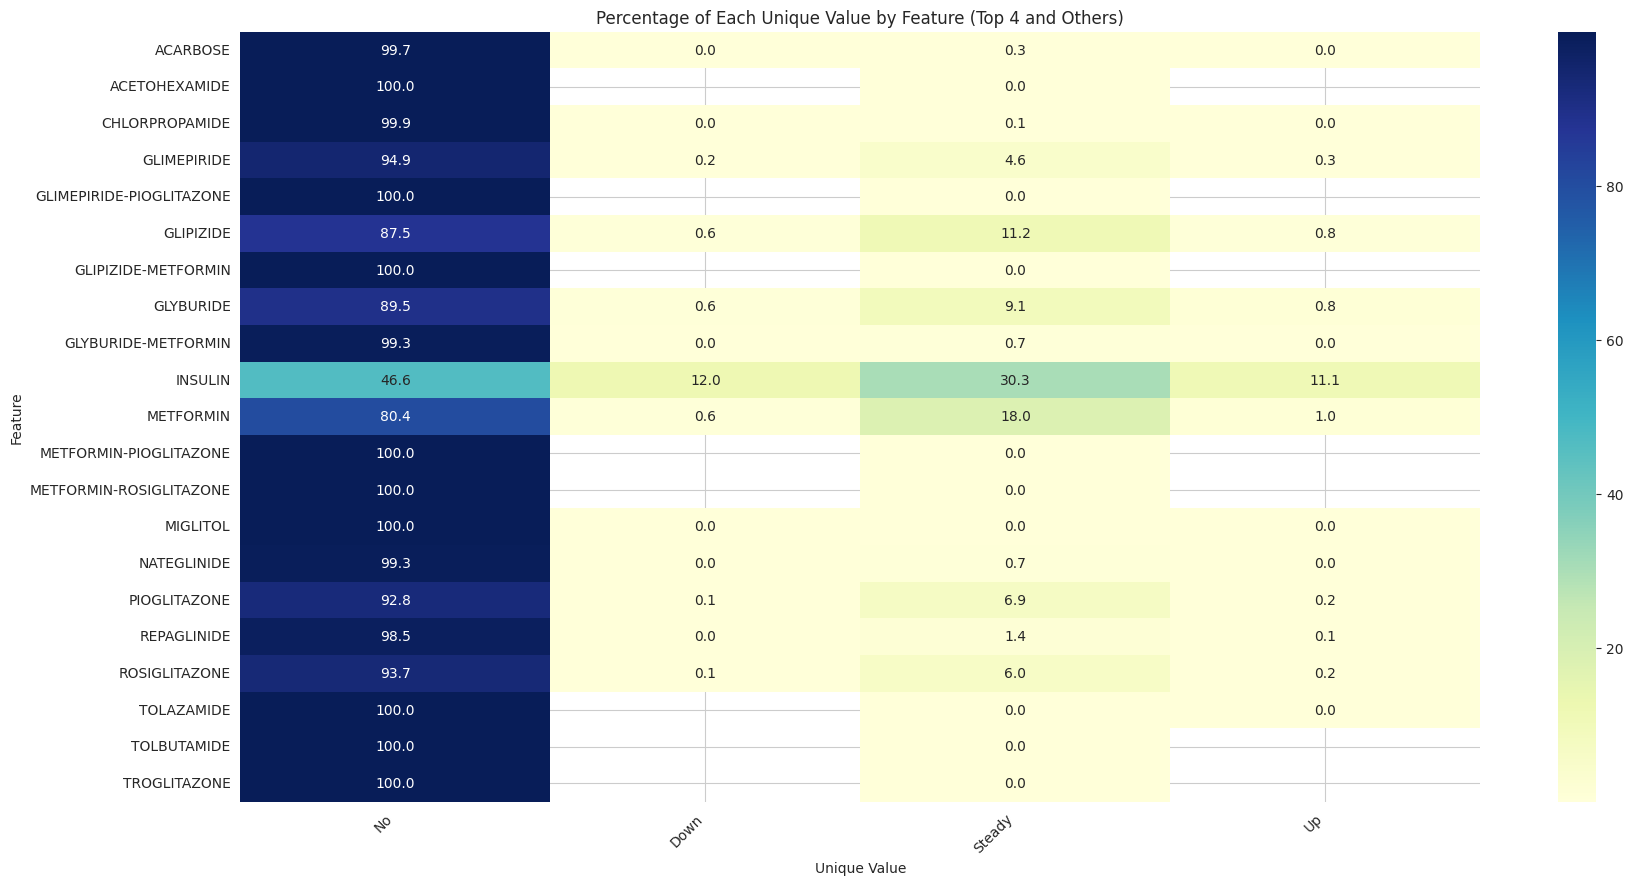

In [45]:
# Medication heatmap data
heatmap_data = pd.DataFrame()

for col in cat_med:
    value_counts = df[col].value_counts()
    if len(value_counts) > 5:  # If more than 5 unique values
        # Take top 4 and create a Series for 'Other'
        top_values = value_counts.iloc[:4]
        other_sum = pd.Series(
            [value_counts.iloc[4:].sum()], index=["Other"]
        )  # Corrected to ensure 'Other' is a Series

        # Combine top values with 'Other' using concat
        new_values = pd.concat([top_values, other_sum])
        percentages = new_values / len(df) * 100
    else:
        percentages = value_counts / len(df) * 100

    # Create a temporary DataFrame to store the data for the current column
    temp_df = pd.DataFrame(
        {
            "Feature": col,
            "Unique Value": percentages.index,
            "Percentage": percentages.values,
        }
    )

    # Append the temporary DataFrame to the main heatmap_data DataFrame
    heatmap_data = pd.concat([heatmap_data, temp_df], ignore_index=True)

# Pivot the DataFrame to get a matrix suitable for a heatmap
pivot_table = heatmap_data.pivot(
    index="Feature", columns="Unique Value", values="Percentage"
)  # Corrected pivot call

# Reorder the x values
order = ["No", "Down", "Steady", "Up"]
pivot_table = pivot_table.reindex(columns=order)

# Plotting the heatmap
plt.figure(figsize=(20, 10))
sns.heatmap(pivot_table, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Percentage of Each Unique Value by Feature (Top 4 and Others)")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.show()


In [46]:
cat_med_todrop = [
    feature
    for feature in cat_med
    if df[feature].value_counts(normalize=True).max() > 0.99
]
print(cat_med_todrop)


['ACARBOSE', 'ACETOHEXAMIDE', 'CHLORPROPAMIDE', 'GLIMEPIRIDE-PIOGLITAZONE', 'GLIPIZIDE-METFORMIN', 'GLYBURIDE-METFORMIN', 'METFORMIN-PIOGLITAZONE', 'METFORMIN-ROSIGLITAZONE', 'MIGLITOL', 'NATEGLINIDE', 'TOLAZAMIDE', 'TOLBUTAMIDE', 'TROGLITAZONE']


In [47]:
empty_coltodrop.extend(cat_med_todrop)

print(f" Total dropped columns now: {empty_coltodrop}")

 Total dropped columns now: ['ACARBOSE', 'ACETOHEXAMIDE', 'CHLORPROPAMIDE', 'GLIMEPIRIDE-PIOGLITAZONE', 'GLIPIZIDE-METFORMIN', 'GLYBURIDE-METFORMIN', 'METFORMIN-PIOGLITAZONE', 'METFORMIN-ROSIGLITAZONE', 'MIGLITOL', 'NATEGLINIDE', 'TOLAZAMIDE', 'TOLBUTAMIDE', 'TROGLITAZONE']


In [48]:
cat_med_ordinal = [col for col in cat_med if col not in cat_med_todrop]

In [49]:
print(f"The total medicine columns where {len(cat_med)} \n The following columns will be deleted : {cat_med_todrop} \n The remaining columns will be ordinally encoded: {cat_med_ordinal}")

The total medicine columns where 21 
 The following columns will be deleted : ['ACARBOSE', 'ACETOHEXAMIDE', 'CHLORPROPAMIDE', 'GLIMEPIRIDE-PIOGLITAZONE', 'GLIPIZIDE-METFORMIN', 'GLYBURIDE-METFORMIN', 'METFORMIN-PIOGLITAZONE', 'METFORMIN-ROSIGLITAZONE', 'MIGLITOL', 'NATEGLINIDE', 'TOLAZAMIDE', 'TOLBUTAMIDE', 'TROGLITAZONE'] 
 The remaining columns will be ordinally encoded: ['GLIMEPIRIDE', 'GLIPIZIDE', 'GLYBURIDE', 'INSULIN', 'METFORMIN', 'PIOGLITAZONE', 'REPAGLINIDE', 'ROSIGLITAZONE']


#### b. Non-medications


In [50]:
print(cat_nonmed)


['RACE', 'GENDER', 'AGE', 'WEIGHT', 'PAYER_CODE', 'MEDICAL_SPECIALTY', 'DIAG_1', 'DIAG_2', 'DIAG_3', 'MAX_GLU_SERUM', 'A1CRESULT', 'EXAMIDE', 'CITOGLIPTON', 'CHANGE', 'DIABETESMED', 'READMITTED']


`Race` Distribution


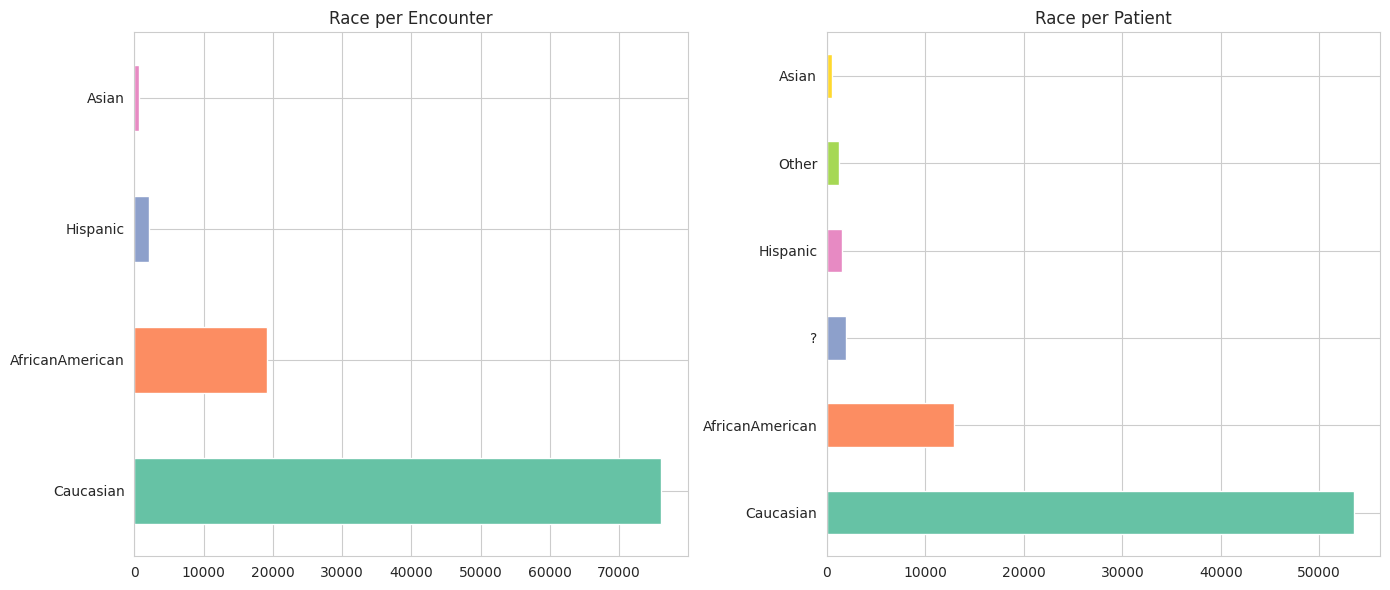

In [51]:
# Race distribution: bar plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot Race per encounter on the first subplot
df["RACE"].value_counts().plot(kind="barh", color=sns.color_palette("Set2"), ax=axes[0])
axes[0].set_title("Race per Encounter")

# Plot Race per patient on the second subplot
df_simplified["RACE"].value_counts().plot(
    kind="barh", color=sns.color_palette("Set2"), ax=axes[1]
)
axes[1].set_title("Race per Patient")

# Layout
plt.tight_layout()
plt.show()


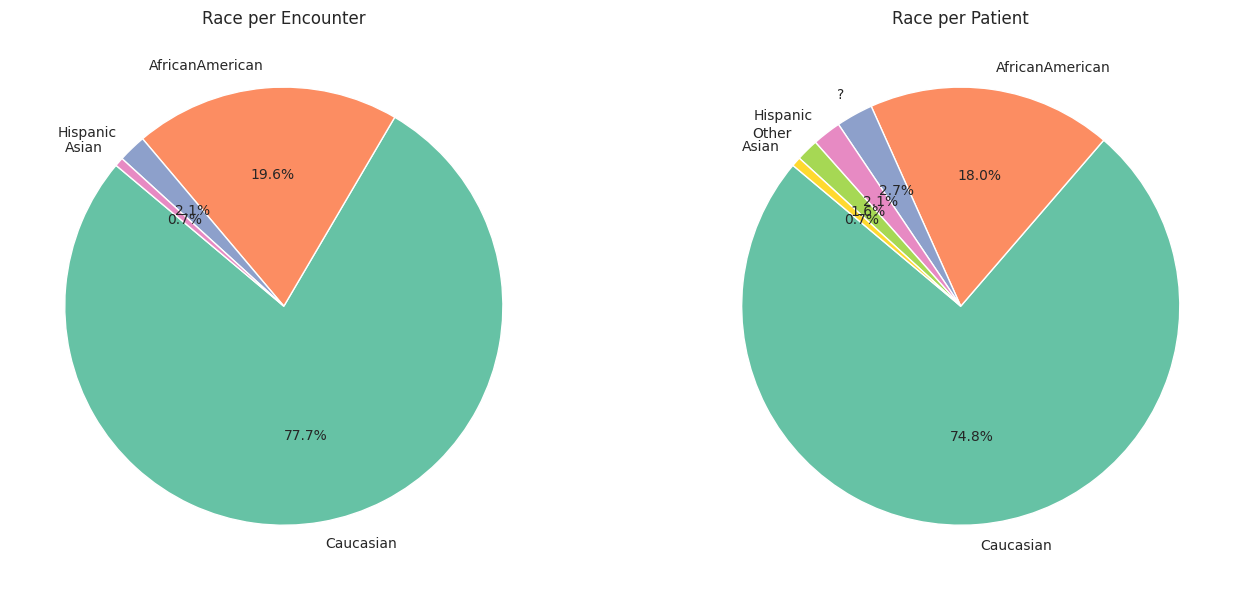

In [52]:
# Race distribution: Pie plots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot 'Race per encounter' on the first subplot
race_counts_encounter = df["RACE"].value_counts()
axes[0].pie(
    race_counts_encounter,
    labels=race_counts_encounter.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("Set2"),
)
axes[0].set_title("Race per Encounter")

# Plot 'Race per patient' on the second subplot
race_counts_patient = df_simplified["RACE"].value_counts()
axes[1].pie(
    race_counts_patient,
    labels=race_counts_patient.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("Set2"),
)
axes[1].set_title("Race per Patient")

# Adjust layout to prevent overlap and ensure clarity
plt.tight_layout()
plt.show()


`Gender` Distribution


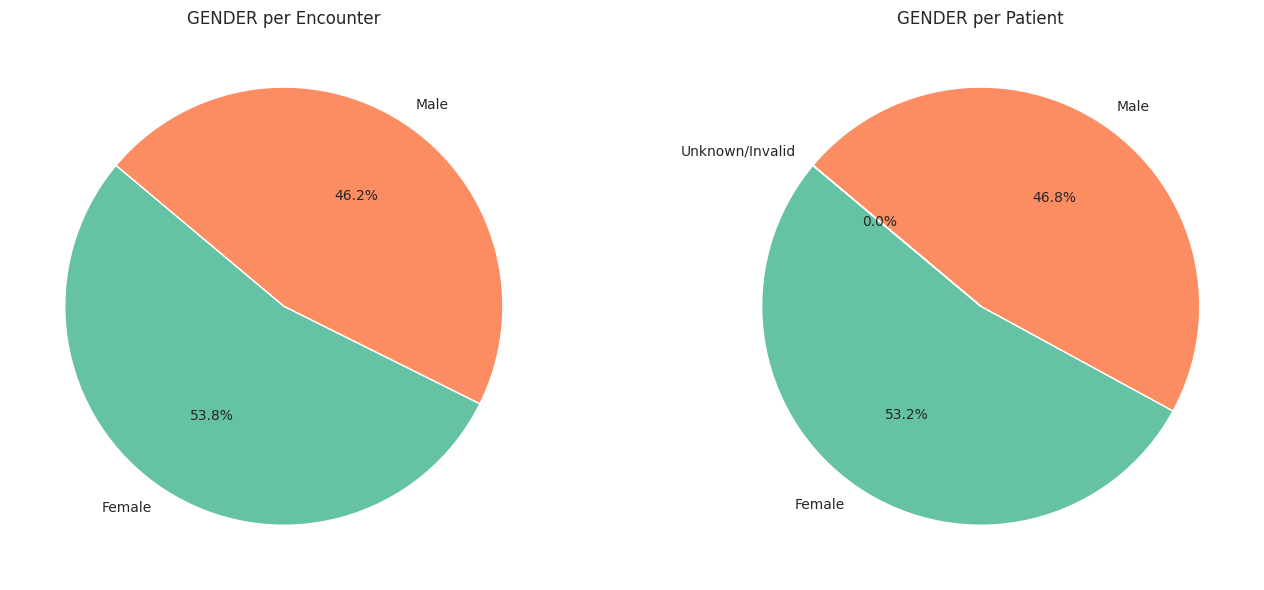

In [53]:
# Set up the matplotlib figure with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot 'Race per encounter' on the first subplot
race_counts_encounter = df["GENDER"].value_counts()
axes[0].pie(
    race_counts_encounter,
    labels=race_counts_encounter.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("Set2"),
)
axes[0].set_title("GENDER per Encounter")

# Plot 'Race per patient' on the second subplot
race_counts_patient = df_simplified["GENDER"].value_counts()
axes[1].pie(
    race_counts_patient,
    labels=race_counts_patient.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("Set2"),
)
axes[1].set_title("GENDER per Patient")

# Adjust layout to prevent overlap and ensure clarity
plt.tight_layout()
plt.show()


`Age` Distribution


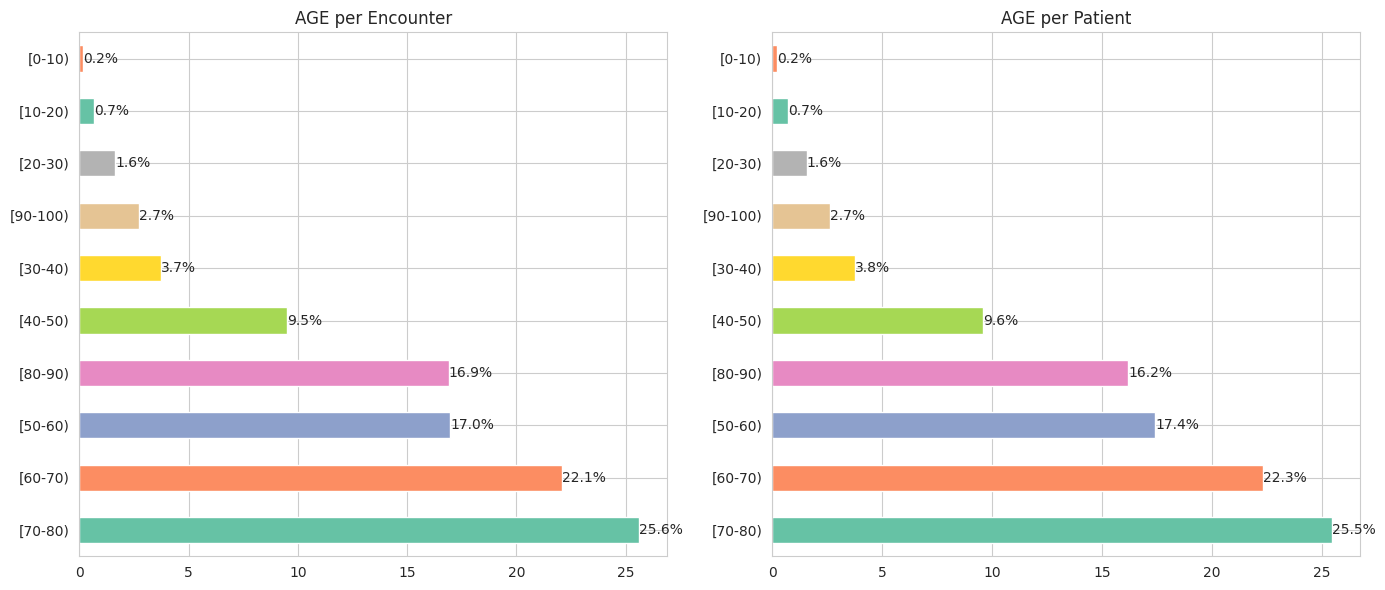

In [54]:
# Age Distribution: bar plots

# Set up the matplotlib figure with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Race per encounter bar plot
race_counts_encounter = (
    df["AGE"].value_counts(normalize=True) * 100
)  # Convert counts to percentages
race_counts_encounter.plot(kind="barh", color=sns.color_palette("Set2"), ax=axes[0])
axes[0].set_title("AGE per Encounter")
# Add percentage text next to each bar
for index, value in enumerate(race_counts_encounter):
    axes[0].text(value, index, f"{value:.1f}%", va="center")

# Race per patient bar plot
race_counts_patient = (
    df_simplified["AGE"].value_counts(normalize=True) * 100
)  # Convert counts to percentages
race_counts_patient.plot(kind="barh", color=sns.color_palette("Set2"), ax=axes[1])
axes[1].set_title("AGE per Patient")
# Add percentage text next to each bar
for index, value in enumerate(race_counts_patient):
    axes[1].text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


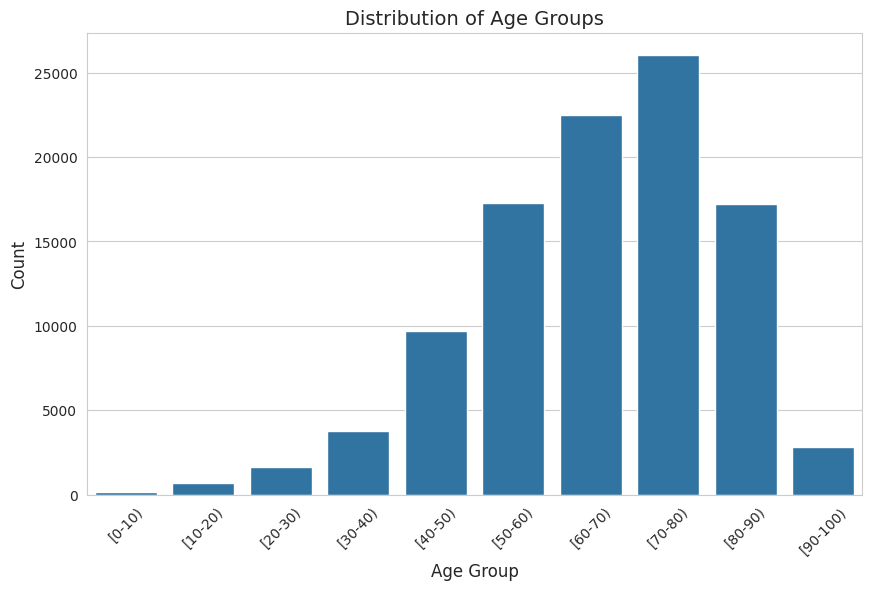

In [55]:
# Age Distribution: histogram
plt.figure(figsize=(10, 6))
sns.countplot(x="AGE", data=df, order=sorted(df["AGE"].unique()))
plt.title("Distribution of Age Groups", fontsize=14)
plt.xlabel("Age Group", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=45)
plt.show()


High class imbalance towards older patients, which is normal for a diabete type-2

=> No Feature Engineering needed

=> Encoding: Ordinal Encoding (Ranking existing)


`Weight` Distribution


In [56]:
df["WEIGHT"].unique()


array([nan, '[75-100)', '[50-75)', '[0-25)', '[100-125)', '[25-50)',
       '[125-150)', '[175-200)', '[150-175)', '>200'], dtype=object)

In [57]:
df["WEIGHT"].isna().sum()


98569

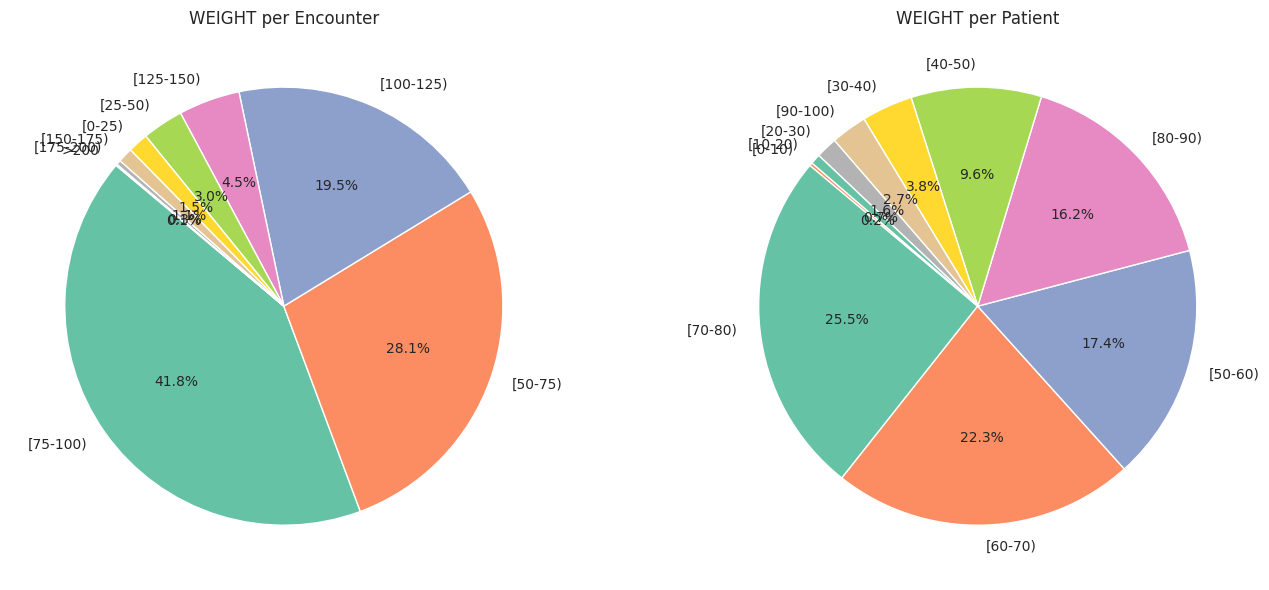

In [58]:
# Set up the matplotlib figure with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot 'WEIGHT per encounter' on the first subplot
counts_encounter = df["WEIGHT"].value_counts()
axes[0].pie(
    counts_encounter,
    labels=counts_encounter.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("Set2"),
)
axes[0].set_title("WEIGHT per Encounter")

# Plot 'WEIGHT per patient' on the second subplot
counts_patient = df_simplified["WEIGHT"].value_counts()
axes[1].pie(
    race_counts_patient,
    labels=race_counts_patient.index,
    autopct="%1.1f%%",
    startangle=140,
    colors=sns.color_palette("Set2"),
)
axes[1].set_title("WEIGHT per Patient")

# Adjust layout to prevent overlap and ensure clarity
plt.tight_layout()
plt.show()


In [59]:
empty_coltodrop.append("WEIGHT")


`Payer-code` Distribution


In [60]:
df["PAYER_CODE"].isna().sum()


40256

In [61]:
df["PAYER_CODE"].nunique()


17

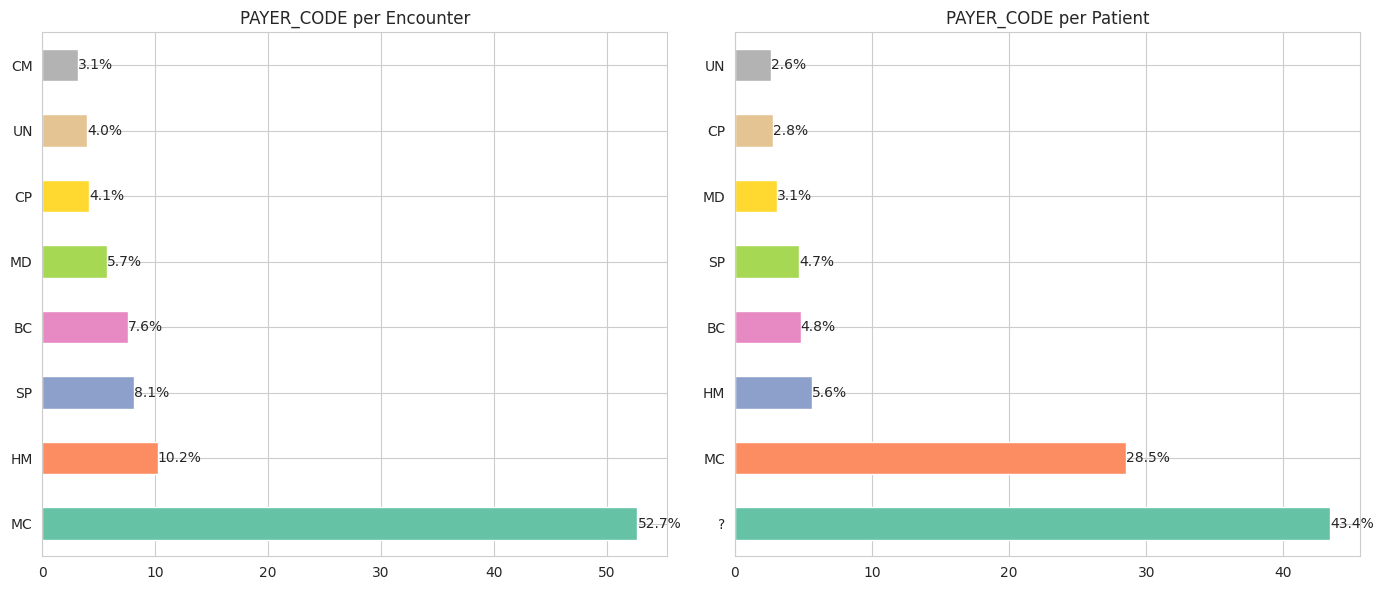

In [62]:
# Set up the matplotlib figure with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# PAYER_CODE per encounter bar plot
counts_encounter = (
    df["PAYER_CODE"].value_counts(normalize=True) * 100
)  # Convert counts to percentages
# Filter values where percentage is greater than 2%
filtered_counts_encounter = counts_encounter[counts_encounter > 2]
filtered_counts_encounter.plot(kind="barh", color=sns.color_palette("Set2"), ax=axes[0])
axes[0].set_title("PAYER_CODE per Encounter")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_encounter):
    axes[0].text(value, index, f"{value:.1f}%", va="center")

# PAYER_CODE per patient bar plot
counts_patient = (
    df_simplified["PAYER_CODE"].value_counts(normalize=True) * 100
)  # Convert counts to percentages
# Filter values where percentage is greater than 2%
filtered_counts_patient = counts_patient[counts_patient > 2]
filtered_counts_patient.plot(kind="barh", color=sns.color_palette("Set2"), ax=axes[1])
axes[1].set_title("PAYER_CODE per Patient")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_patient):
    axes[1].text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


In [63]:
df["PAYER_CODE"].nunique()


17

In [64]:
df[cat_nonmed].nunique()


RACE                   4
GENDER                 2
AGE                   10
WEIGHT                 9
PAYER_CODE            17
MEDICAL_SPECIALTY     72
DIAG_1               716
DIAG_2               748
DIAG_3               789
MAX_GLU_SERUM          4
A1CRESULT              4
EXAMIDE                1
CITOGLIPTON            1
CHANGE                 2
DIABETESMED            2
READMITTED             2
dtype: int64

In [65]:
cat_nonmed_analysis = ["DIAG_1", "DIAG_2", "DIAG_3", "MEDICAL_SPECIALTY"]


`Medical Speciality` Distribution


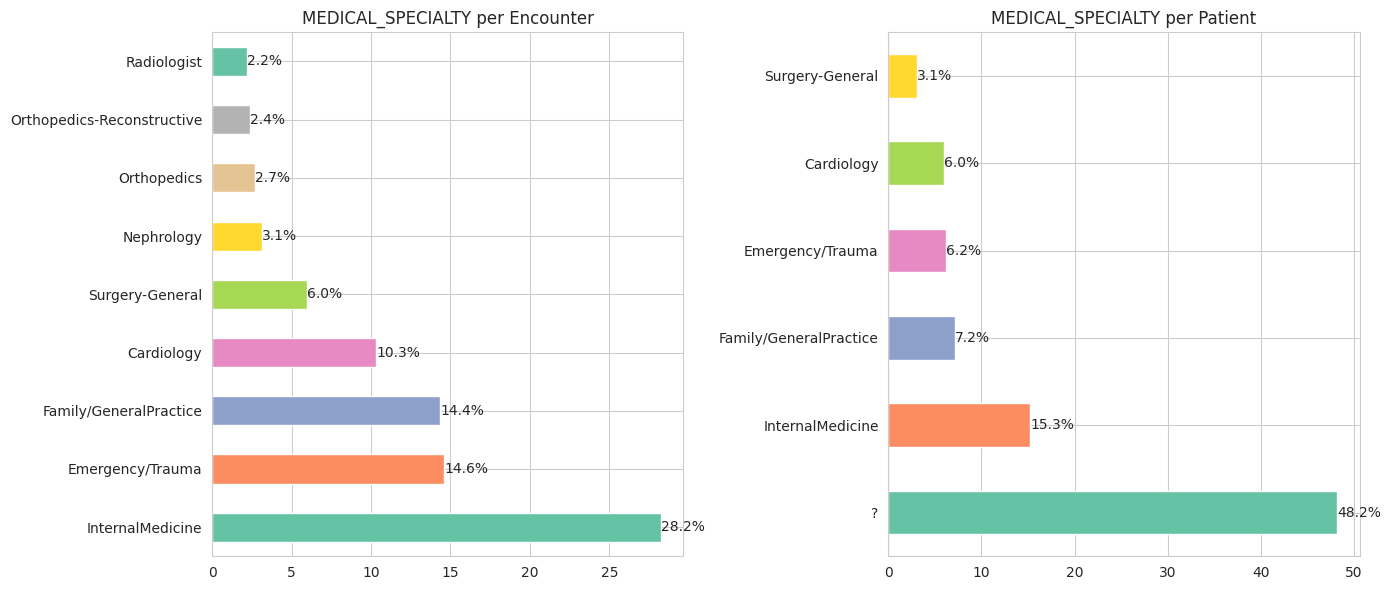

In [66]:
# Set up the matplotlib figure with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# MEDICAL_SPECIALTYER_CODE per encounter bar plot
counts_encounter = (
    df["MEDICAL_SPECIALTY"].value_counts(normalize=True) * 100
)  # Convert counts to percentages
# Filter values where percentage is greater than 2%
filtered_counts_encounter = counts_encounter[counts_encounter > 2]
filtered_counts_encounter.plot(kind="barh", color=sns.color_palette("Set2"), ax=axes[0])
axes[0].set_title("MEDICAL_SPECIALTY per Encounter")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_encounter):
    axes[0].text(value, index, f"{value:.1f}%", va="center")

# MEDICAL_SPECIALTY per patient bar plot
counts_patient = (
    df_simplified["MEDICAL_SPECIALTY"].value_counts(normalize=True) * 100
)  # Convert counts to percentages
# Filter values where percentage is greater than 2%
filtered_counts_patient = counts_patient[counts_patient > 2]
filtered_counts_patient.plot(kind="barh", color=sns.color_palette("Set2"), ax=axes[1])
axes[1].set_title("MEDICAL_SPECIALTY per Patient")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_patient):
    axes[1].text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


`Diagnosis` Distribution


In [67]:
%pip install icd9cms
from icd9cms.icd9 import search


In [68]:
# ASSESSING THE COMPLEXITY
df[["DIAG_1", "DIAG_2", "DIAG_3"]].nunique()


DIAG_1    716
DIAG_2    748
DIAG_3    789
dtype: int64

In [69]:
# DECODING

import icd9cms


def get_icd9_description(code):
    try:
        # Ensure the code is a string, remove decimal point if present
        code_str = str(code).replace(".", "")
        # Lookup the description
        description = icd9cms.search(code_str).short_desc
    except Exception as e:
        description = "OTHER"
    return description


df_diag = df[["DIAG_1", "DIAG_2", "DIAG_3", "ENCOUNTER_ID", "PATIENT_NBR"]].copy()

df_diag["DIAG_1_DESCRIPTION"] = df_diag["DIAG_1"].apply(get_icd9_description)
df_diag["DIAG_2_DESCRIPTION"] = df_diag["DIAG_2"].apply(get_icd9_description)
df_diag["DIAG_3_DESCRIPTION"] = df_diag["DIAG_3"].apply(get_icd9_description)

df_diag.head()


DIAG_1  DIAG_2 DIAG_3  ENCOUNTER_ID  PATIENT_NBR  \
0  250.83     NaN    NaN       2278392      8222157   
1     276  250.01    255        149190     55629189   
2     648     250    V27         64410     86047875   
3       8  250.43    403        500364     82442376   
4     197     157    250         16680     42519267   

                                  DIAG_1_DESCRIPTION  \
0                                   DMI oth uncntrld   
1  Disorders of fluid electrolyte and acid-base b...   
2  Other current conditions in the mother classif...   
3                                              OTHER   
4  Secondary malignant neoplasm of respiratory an...   

               DIAG_2_DESCRIPTION                   DIAG_3_DESCRIPTION  
0                           OTHER                                OTHER  
1        DMI wo cmp nt st uncntrl          Disorders of adrenal glands  
2               Diabetes mellitus                  Outcome of delivery  
3              DMI renal uncntrld  Hypertensive chronic kidney disease  
4  Malignant neoplasm of pancreas                    Diabetes mellitus

In [70]:
def get_icd9_parent(code):
    try:
        # Ensure the code is a string, remove decimal point if present
        code_str = str(code).replace(".", "")
        # Lookup the description
        description = icd9cms.search(code_str).ancestors
    except Exception as e:
        description = "OTHER"
    return description


df_diag["DIAG_1_PARENT"] = df_diag["DIAG_1"].apply(get_icd9_parent)
df_diag["DIAG_2_PARENT"] = df_diag["DIAG_2"].apply(get_icd9_parent)
df_diag["DIAG_3_PARENT"] = df_diag["DIAG_3"].apply(get_icd9_parent)

df_diag.head()


DIAG_1  DIAG_2 DIAG_3  ENCOUNTER_ID  PATIENT_NBR  \
0  250.83     NaN    NaN       2278392      8222157   
1     276  250.01    255        149190     55629189   
2     648     250    V27         64410     86047875   
3       8  250.43    403        500364     82442376   
4     197     157    250         16680     42519267   

                                  DIAG_1_DESCRIPTION  \
0                                   DMI oth uncntrld   
1  Disorders of fluid electrolyte and acid-base b...   
2  Other current conditions in the mother classif...   
3                                              OTHER   
4  Secondary malignant neoplasm of respiratory an...   

               DIAG_2_DESCRIPTION                   DIAG_3_DESCRIPTION  \
0                           OTHER                                OTHER   
1        DMI wo cmp nt st uncntrl          Disorders of adrenal glands   
2               Diabetes mellitus                  Outcome of delivery   
3              DMI renal uncntrld  Hypertensive chronic kidney disease   
4  Malignant neoplasm of pancreas                    Diabetes mellitus   

                                       DIAG_1_PARENT  \
0  <bound method Node.ancestors of 25083:DMI oth ...   
1  <bound method Node.ancestors of 276:Disorders ...   
2  <bound method Node.ancestors of 648:Other curr...   
3                                              OTHER   
4  <bound method Node.ancestors of 197:Secondary ...   

                                       DIAG_2_PARENT  \
0                                              OTHER   
1  <bound method Node.ancestors of 25001:DMI wo c...   
2  <bound method Node.ancestors of 250:Diabetes m...   
3  <bound method Node.ancestors of 25043:DMI rena...   
4  <bound method Node.ancestors of 157:Malignant ...   

                                       DIAG_3_PARENT  
0                                              OTHER  
1  <bound method Node.ancestors of 255:Disorders ...  
2  <bound method Node.ancestors of V27:Outcome of...  
3  <bound method Node.ancestors of 403:Hypertensi...  
4  <bound method Node.ancestors of 250:Diabetes m...

In [71]:
df_diag.columns


Index(['DIAG_1', 'DIAG_2', 'DIAG_3', 'ENCOUNTER_ID', 'PATIENT_NBR',
       'DIAG_1_DESCRIPTION', 'DIAG_2_DESCRIPTION', 'DIAG_3_DESCRIPTION',
       'DIAG_1_PARENT', 'DIAG_2_PARENT', 'DIAG_3_PARENT'],
      dtype='object')

In [72]:
dir(icd9cms.search("648"))


['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'alt_code',
 'ancestors',
 'children',
 'code',
 'descendants',
 'is_leaf',
 'leaves',
 'long_desc',
 'parent',
 'short_desc',
 'siblings']

In [73]:
print(icd9cms.search("648").siblings)


[640:Hemorrhage in early pregnancy:None, 641:Antepartum hemorrhage abruptio placentae and placenta previa:None, 642:Hypertension complicating pregnancy childbirth and the puerperium:None, 643:Excessive vomiting in pregnancy:None, 644:Early or threatened labor:None, 645:Late pregnancy:None, 646:Other complications of pregnancy not elsewhere classified:None, 647:Infectious and parasitic conditions in the mother classifiable elsewhere but complicating pregnancy childbirth or the puerperium:None, 649:Other conditions or status of the mother complicating pregnancy, childbirth, or the puerperium:None]


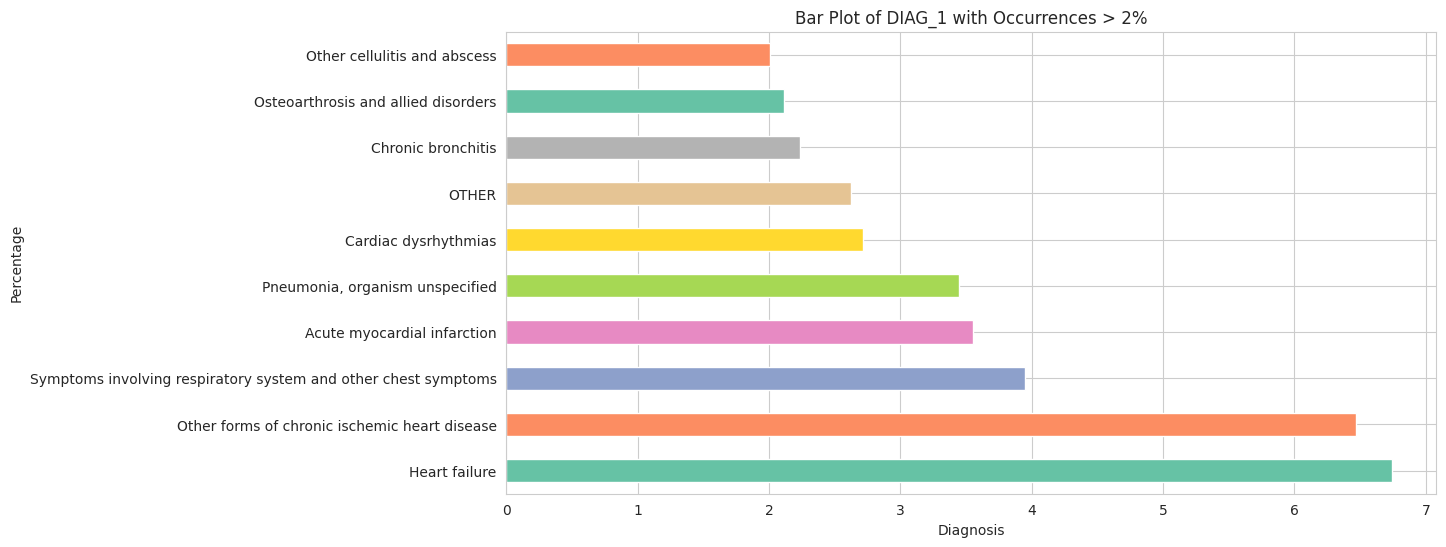

In [74]:
import matplotlib.pyplot as plt

# Calculate the percentage of each diagnosis
diagnosis_counts = df_diag["DIAG_1_DESCRIPTION"].value_counts(normalize=True) * 100

# Filter the diagnoses with more than 2% occurrences
filtered_diagnoses = diagnosis_counts[diagnosis_counts > 2]

# Sort the filtered diagnoses by the number of occurrences
sorted_diagnoses = filtered_diagnoses.sort_values(ascending=False)

# Plot the bar plot
plt.figure(figsize=(12, 6))
sorted_diagnoses.plot(kind="barh", color=sns.color_palette("Set2"))
plt.xlabel("Diagnosis")
plt.ylabel("Percentage")
plt.title("Bar Plot of DIAG_1 with Occurrences > 2%")
plt.show()


In [75]:
# Count the occurrences of each 'ADMISSION_TYPE_ID'
diag_counts = df_diag["DIAG_1"].value_counts(ascending=True)

# Create a DataFrame with 'ADMISSION_TYPE_ID' and its count
diag_counts_df = diag_counts.reset_index()
diag_counts_df.columns = ["DIAG_1", "COUNT"]

# Merge with the descriptions to get a full table
diag_description_df = df_diag[["DIAG_1", "DIAG_1_DESCRIPTION"]].drop_duplicates()
diag_table = diag_counts_df.merge(diag_description_df, on="DIAG_1", how="left")

# Sort the table by the count of 'ADMISSION_TYPE_ID' from least to most present
diag_table_sorted = diag_table.sort_values(by="COUNT")
diag_table_sorted[["DIAG_1_DESCRIPTION", "DIAG_1", "COUNT"]].tail(10)


DIAG_1_DESCRIPTION DIAG_1  COUNT
706                     Occlusion of cerebral arteries    434   2028
707                       Other cellulitis and abscess    682   2042
708                Osteoarthrosis and allied disorders    715   2151
709                                 Chronic bronchitis    491   2275
710                               Cardiac dysrhythmias    427   2766
711                    Pneumonia, organism unspecified    486   3508
712                        Acute myocardial infarction    410   3614
713  Symptoms involving respiratory system and othe...    786   4016
714      Other forms of chronic ischemic heart disease    414   6581
715                                      Heart failure    428   6862

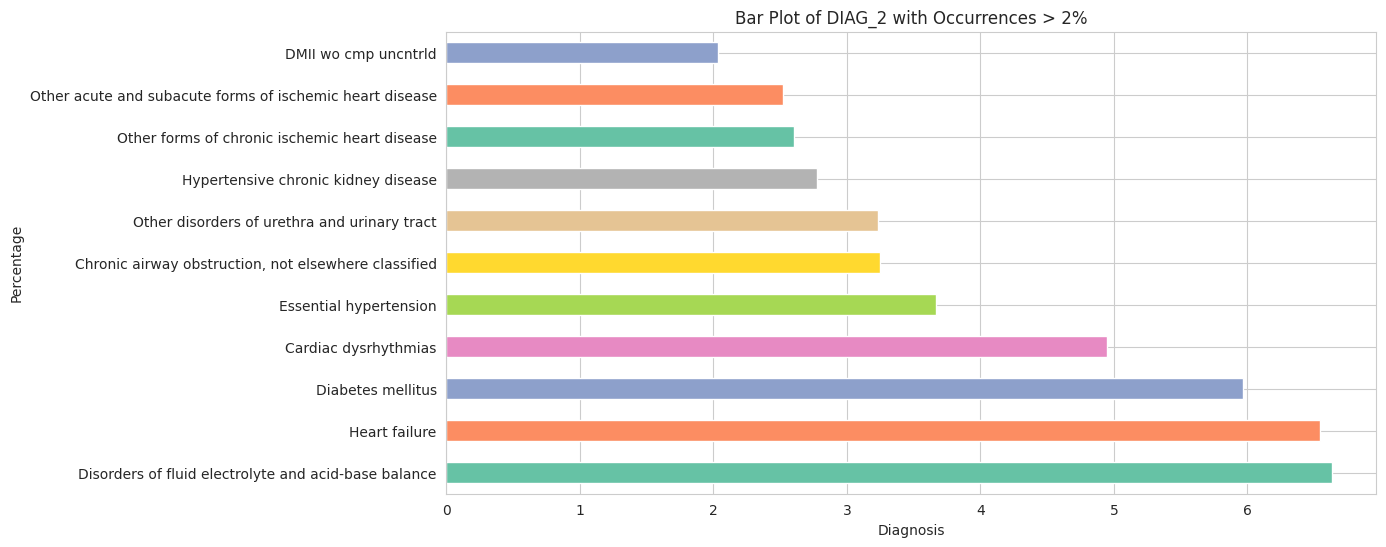

In [76]:
# Calculate the percentage of each diagnosis
diagnosis_counts = df_diag["DIAG_2_DESCRIPTION"].value_counts(normalize=True) * 100

# Filter the diagnoses with more than 2% occurrences
filtered_diagnoses = diagnosis_counts[diagnosis_counts > 2]

# Sort the filtered diagnoses by the number of occurrences
sorted_diagnoses = filtered_diagnoses.sort_values(ascending=False)

# Plot the bar plot
plt.figure(figsize=(12, 6))
sorted_diagnoses.plot(kind="barh", color=sns.color_palette("Set2"))
plt.xlabel("Diagnosis")
plt.ylabel("Percentage")
plt.title("Bar Plot of DIAG_2 with Occurrences > 2%")
plt.show()


In [77]:
# Count the occurrences of each 'ADMISSION_TYPE_ID'
diag_counts = df_diag["DIAG_2"].value_counts(ascending=True)

# Create a DataFrame with 'ADMISSION_TYPE_ID' and its count
diag_counts_df = diag_counts.reset_index()
diag_counts_df.columns = ["DIAG_2", "COUNT"]

# Merge with the descriptions to get a full table
diag_description_df = df_diag[["DIAG_2", "DIAG_2_DESCRIPTION"]].drop_duplicates()
diag_table = diag_counts_df.merge(diag_description_df, on="DIAG_2", how="left")

# Sort the table by the count of 'ADMISSION_TYPE_ID' from least to most present
diag_table_sorted = diag_table.sort_values(by="COUNT")
diag_table_sorted[["DIAG_2_DESCRIPTION", "DIAG_2", "COUNT"]].tail(10)


DIAG_2_DESCRIPTION DIAG_2  COUNT
738  Other acute and subacute forms of ischemic hea...    411   2566
739      Other forms of chronic ischemic heart disease    414   2650
740                Hypertensive chronic kidney disease    403   2823
741       Other disorders of urethra and urinary tract    599   3288
742  Chronic airway obstruction, not elsewhere clas...    496   3305
743                             Essential hypertension    401   3736
744                               Cardiac dysrhythmias    427   5036
745                                  Diabetes mellitus    250   6071
746                                      Heart failure    428   6662
747  Disorders of fluid electrolyte and acid-base b...    276   6752

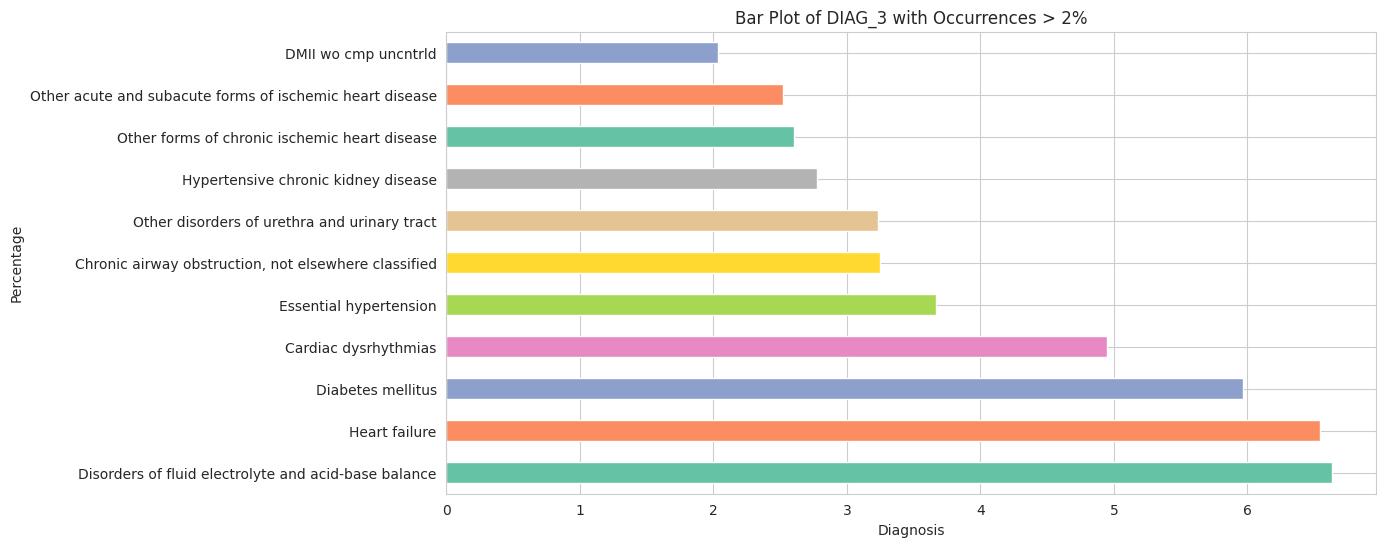

In [78]:
# DIAG 3 PLOT
diagnosis_counts = df_diag["DIAG_2_DESCRIPTION"].value_counts(normalize=True) * 100

filtered_diagnoses = diagnosis_counts[diagnosis_counts > 2]

sorted_diagnoses = filtered_diagnoses.sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sorted_diagnoses.plot(kind="barh", color=sns.color_palette("Set2"))
plt.xlabel("Diagnosis")
plt.ylabel("Percentage")
plt.title("Bar Plot of DIAG_3 with Occurrences > 2%")
plt.show()


In [79]:
# DIAG 3 TABLE
diag_counts = df_diag["DIAG_3"].value_counts(ascending=True)

diag_counts_df = diag_counts.reset_index()
diag_counts_df.columns = ["DIAG_3", "COUNT"]

diag_description_df = df_diag[["DIAG_3", "DIAG_3_DESCRIPTION"]].drop_duplicates()
diag_table = diag_counts_df.merge(diag_description_df, on="DIAG_3", how="left")

diag_table_sorted = diag_table.sort_values(by="COUNT")
diag_table_sorted[["DIAG_3_DESCRIPTION", "DIAG_3", "COUNT"]].tail(10)


DIAG_3_DESCRIPTION DIAG_3  COUNT
779                     Disorders of lipoid metabolism    272   1969
780                       Chronic kidney disease (ckd)    585   1992
781                Hypertensive chronic kidney disease    403   2357
782  Chronic airway obstruction, not elsewhere clas...    496   2605
783      Other forms of chronic ischemic heart disease    414   3664
784                               Cardiac dysrhythmias    427   3955
785                                      Heart failure    428   4577
786  Disorders of fluid electrolyte and acid-base b...    276   5175
787                             Essential hypertension    401   8289
788                                  Diabetes mellitus    250  11555

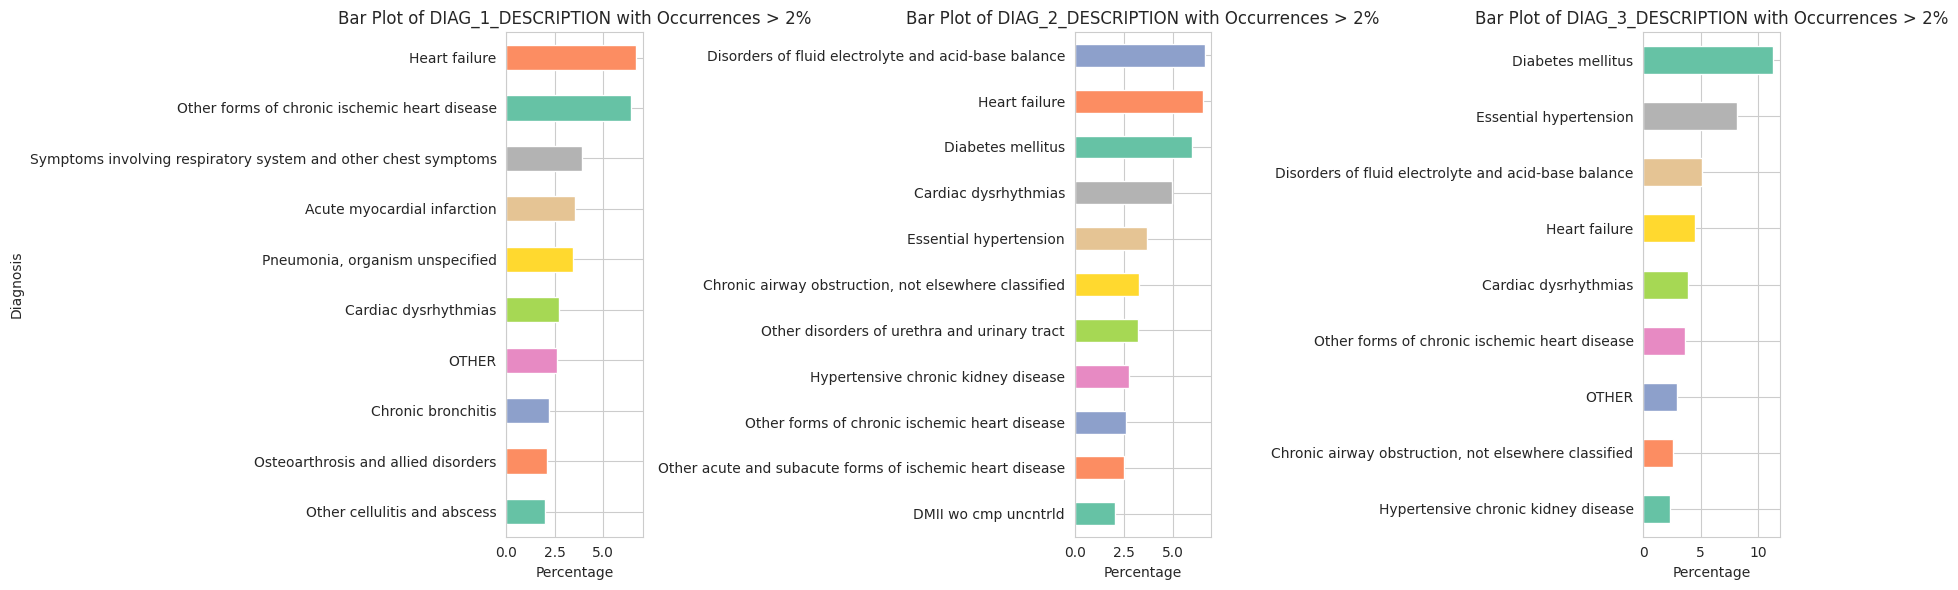

In [80]:
# THREE PLOTS TOGETHER
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# List of diagnosis columns to plot
diagnosis_columns = ["DIAG_1_DESCRIPTION", "DIAG_2_DESCRIPTION", "DIAG_3_DESCRIPTION"]

# Loop through each diagnosis column and create a bar plot
for i, diag_col in enumerate(diagnosis_columns):
    # Calculate the percentage of each diagnosis
    diagnosis_counts = df_diag[diag_col].value_counts(normalize=True) * 100

    # Filter the diagnoses with more than 2% occurrences
    filtered_diagnoses = diagnosis_counts[diagnosis_counts > 2]

    # Sort the filtered diagnoses by the number of occurrences for a horizontal plot
    sorted_diagnoses = filtered_diagnoses.sort_values(ascending=True)

    # Plot the horizontal bar plot on the subplot
    sorted_diagnoses.plot(kind="barh", ax=axes[i], color=sns.color_palette("Set2"))
    axes[i].set_xlabel("Percentage")  # X label now represents 'Percentage'
    axes[i].set_title(f"Bar Plot of {diag_col} with Occurrences > 2%")

# Set a common y-label
axes[0].set_ylabel("Diagnosis")  # Y label now represents 'Diagnosis'

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


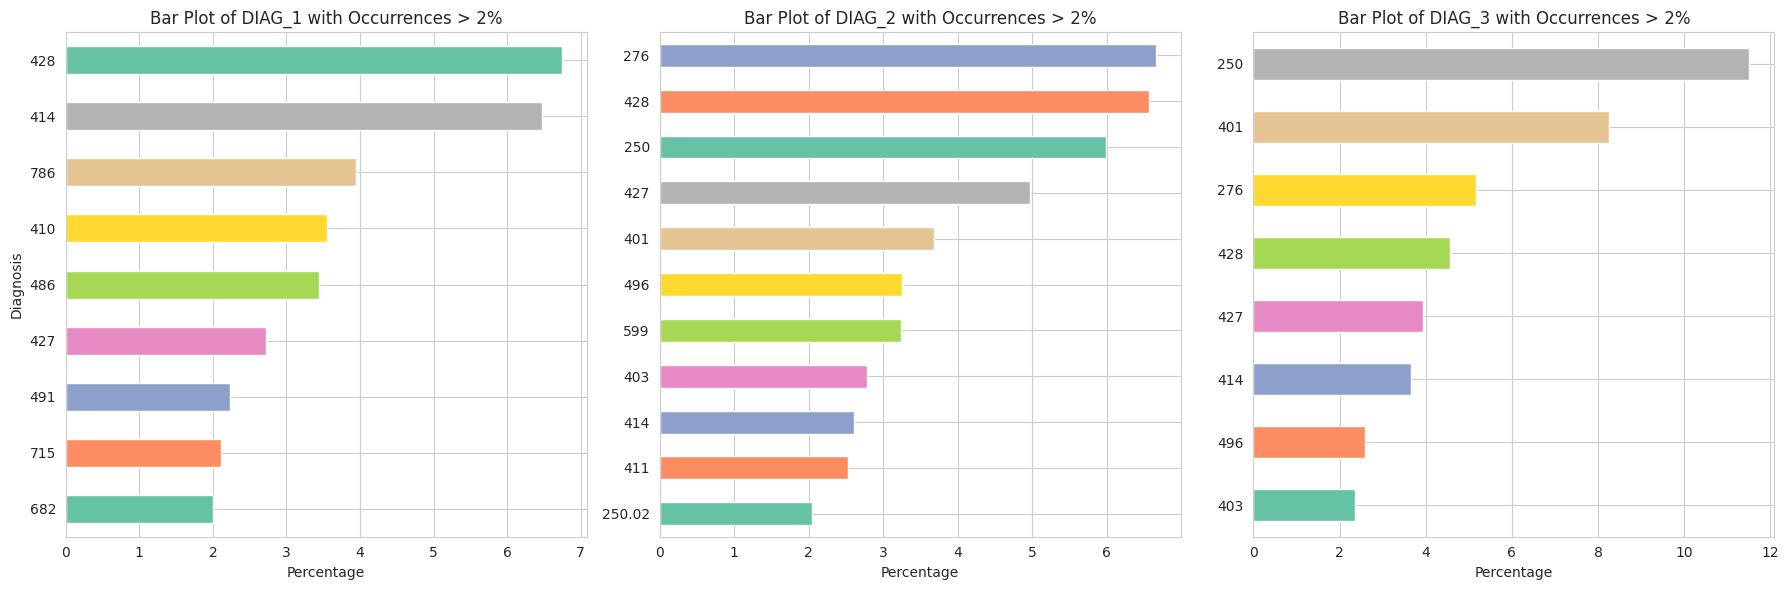

In [81]:
# Bar plots together

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# List of diagnosis columns to plot
diagnosis_columns = ["DIAG_1", "DIAG_2", "DIAG_3"]

# Loop through each diagnosis column and create a bar plot
for i, diag_col in enumerate(diagnosis_columns):
    # Calculate the percentage of each diagnosis
    diagnosis_counts = df_diag[diag_col].value_counts(normalize=True) * 100

    # Filter the diagnoses with more than 2% occurrences
    filtered_diagnoses = diagnosis_counts[diagnosis_counts > 2]

    # Sort the filtered diagnoses by the number of occurrences for a horizontal plot
    sorted_diagnoses = filtered_diagnoses.sort_values(ascending=True)

    # Plot the horizontal bar plot on the subplot
    sorted_diagnoses.plot(kind="barh", ax=axes[i], color=sns.color_palette("Set2"))
    axes[i].set_xlabel("Percentage")  # X label now represents 'Percentage'
    axes[i].set_title(f"Bar Plot of {diag_col} with Occurrences > 2%")

# Set a common y-label
axes[0].set_ylabel("Diagnosis")  # Y label now represents 'Diagnosis'

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


MAX_GLU_SERUM


In [82]:
df["MAX_GLU_SERUM"].isnull().sum()


0

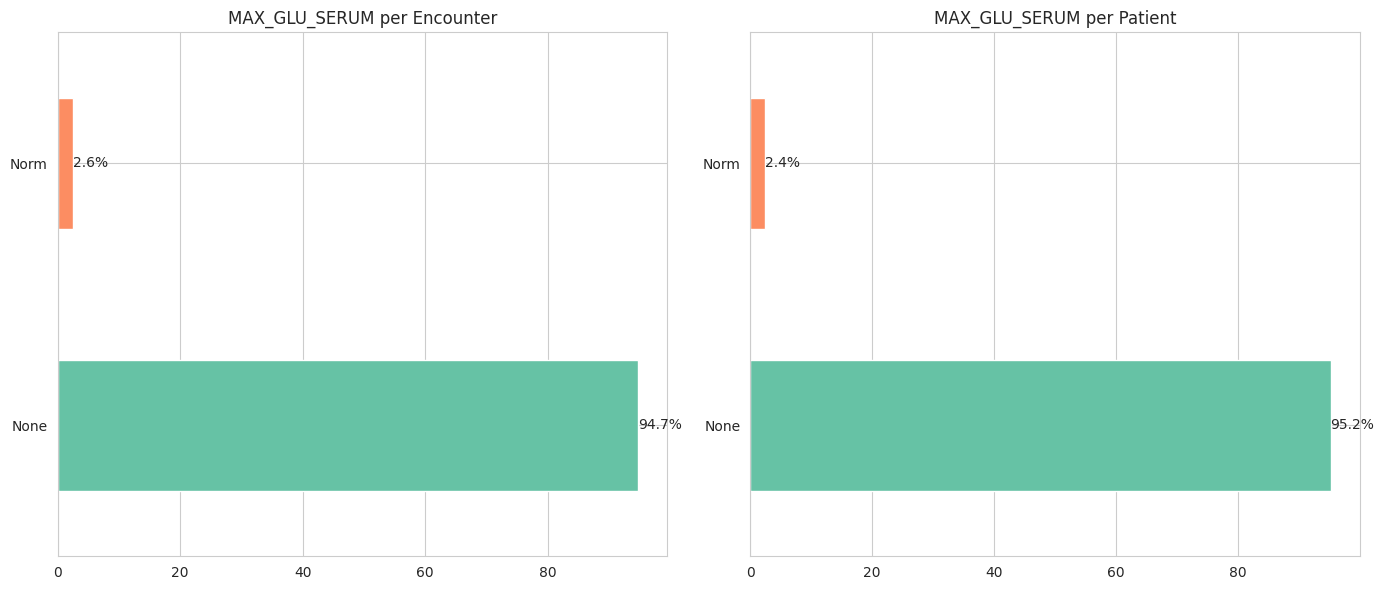

In [83]:
# BAR PLOT
feature_toplot = "MAX_GLU_SERUM"

# Set up the matplotlib figure with 1 row and 2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# PAYMEDICAL_SPECIALTYER_CODE per encounter bar plot
counts_encounter = (
    df[feature_toplot].value_counts(normalize=True) * 100
)  # Convert counts to percentages
# Filter values where percentage is greater than 2%
filtered_counts_encounter = counts_encounter[counts_encounter > 2]
filtered_counts_encounter.plot(kind="barh", color=sns.color_palette("Set2"), ax=axes[0])
axes[0].set_title(f"{feature_toplot} per Encounter")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_encounter):
    axes[0].text(value, index, f"{value:.1f}%", va="center")

# MEDICAL_SPECIALTY per patient bar plot
counts_patient = (
    df_simplified[feature_toplot].value_counts(normalize=True) * 100
)  # Convert counts to percentages
# Filter values where percentage is greater than 2%
filtered_counts_patient = counts_patient[counts_patient > 2]
filtered_counts_patient.plot(kind="barh", color=sns.color_palette("Set2"), ax=axes[1])
axes[1].set_title(f"{feature_toplot} per Patient")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_patient):
    axes[1].text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


A1C Results


In [84]:
df["A1CRESULT"].isna().sum()
df["A1CRESULT"] = df["A1CRESULT"].fillna("NO TEST TAKEN")


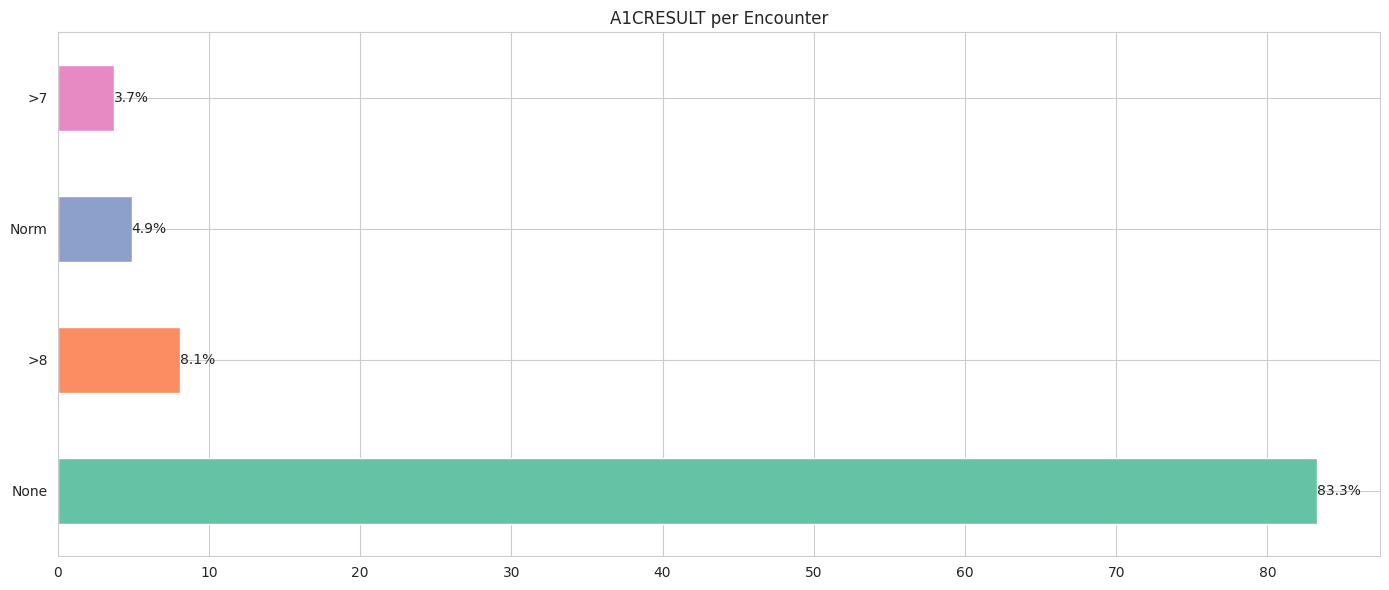

In [85]:
# BAR PLOT
feature_toplot = "A1CRESULT"

# Set up the matplotlib figure for a single plot
fig, ax = plt.subplots(figsize=(14, 6))

# A1CRESULT per encounter bar plot
counts_encounter = (
    df[feature_toplot].value_counts(normalize=True) * 100
)  # Convert counts to percentages

# Filter values where percentage is greater than 2%
filtered_counts_encounter = counts_encounter[counts_encounter > 2]

# Create horizontal bar plot
filtered_counts_encounter.plot(kind="barh", color=sns.color_palette("Set2"), ax=ax)

# Set title
ax.set_title(f"{feature_toplot} per Encounter")

# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_encounter):
    ax.text(value, index, f"{value:.1f}%", va="center")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


Examide


In [86]:
df["EXAMIDE"].nunique()


1

In [87]:
empty_coltodrop.append("EXAMIDE")
empty_coltodrop


['ACARBOSE',
 'ACETOHEXAMIDE',
 'CHLORPROPAMIDE',
 'GLIMEPIRIDE-PIOGLITAZONE',
 'GLIPIZIDE-METFORMIN',
 'GLYBURIDE-METFORMIN',
 'METFORMIN-PIOGLITAZONE',
 'METFORMIN-ROSIGLITAZONE',
 'MIGLITOL',
 'NATEGLINIDE',
 'TOLAZAMIDE',
 'TOLBUTAMIDE',
 'TROGLITAZONE',
 'WEIGHT',
 'EXAMIDE']

CITOGLIPTON


In [88]:
df["CITOGLIPTON"].nunique()


1

In [89]:
empty_coltodrop.append("CITOGLIPTON")
empty_coltodrop


['ACARBOSE',
 'ACETOHEXAMIDE',
 'CHLORPROPAMIDE',
 'GLIMEPIRIDE-PIOGLITAZONE',
 'GLIPIZIDE-METFORMIN',
 'GLYBURIDE-METFORMIN',
 'METFORMIN-PIOGLITAZONE',
 'METFORMIN-ROSIGLITAZONE',
 'MIGLITOL',
 'NATEGLINIDE',
 'TOLAZAMIDE',
 'TOLBUTAMIDE',
 'TROGLITAZONE',
 'WEIGHT',
 'EXAMIDE',
 'CITOGLIPTON']

`CHANGE`


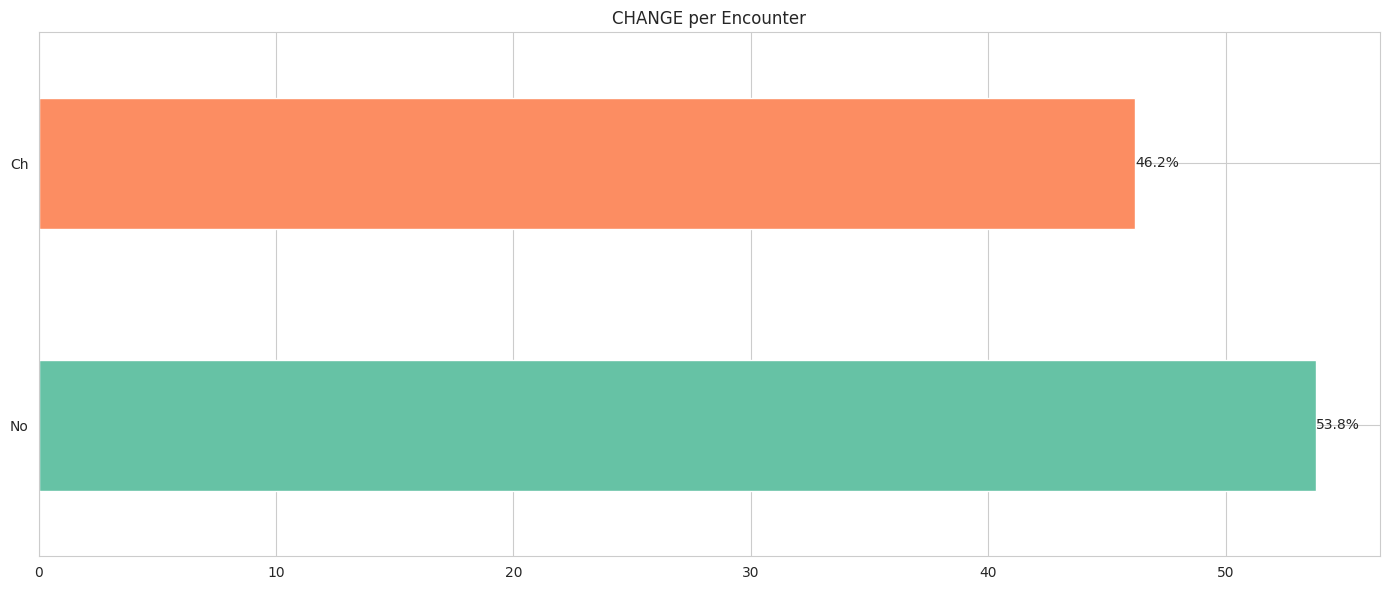

In [90]:
# BAR PLOT
feature_toplot = "CHANGE"


fig, ax = plt.subplots(figsize=(14, 6))

counts_encounter = df[feature_toplot].value_counts(normalize=True) * 100

filtered_counts_encounter = counts_encounter[counts_encounter > 2]

filtered_counts_encounter.plot(kind="barh", color=sns.color_palette("Set2"), ax=ax)

ax.set_title(f"{feature_toplot} per Encounter")

for index, value in enumerate(filtered_counts_encounter):
    ax.text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


DIABETESMED


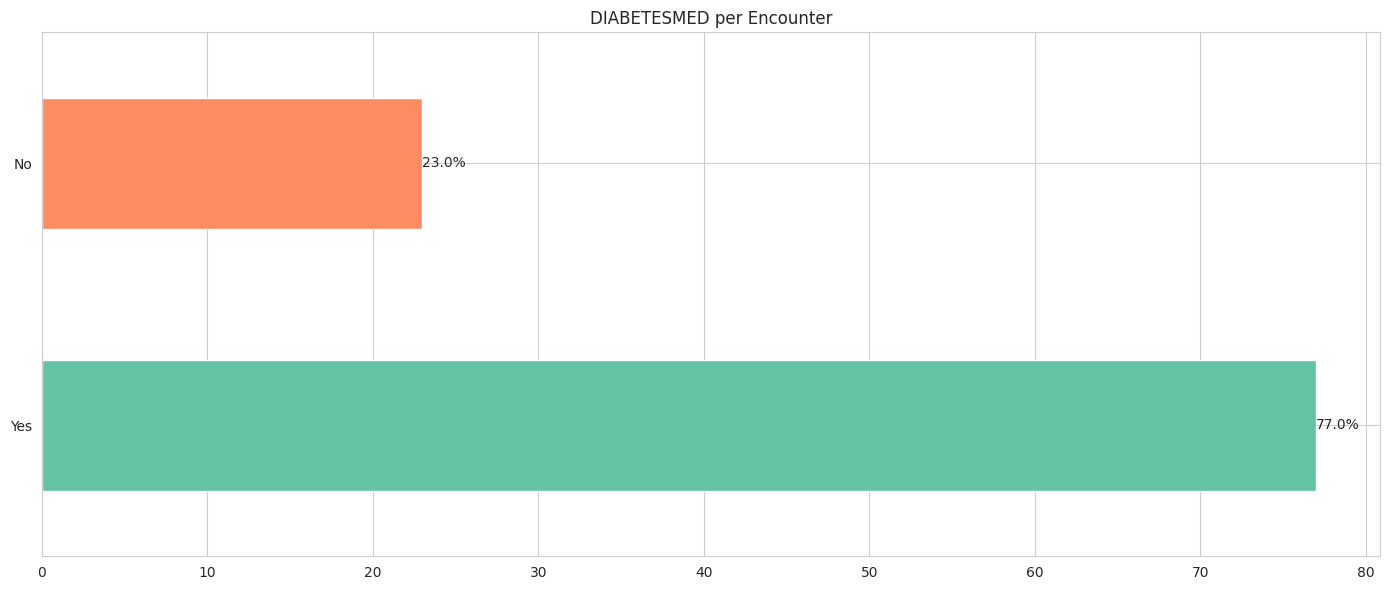

In [91]:
# BAR PLOT
feature_toplot = "DIABETESMED"


fig, ax = plt.subplots(figsize=(14, 6))

counts_encounter = df[feature_toplot].value_counts(normalize=True) * 100

filtered_counts_encounter = counts_encounter[counts_encounter > 2]

filtered_counts_encounter.plot(kind="barh", color=sns.color_palette("Set2"), ax=ax)

ax.set_title(f"{feature_toplot} per Encounter")

for index, value in enumerate(filtered_counts_encounter):
    ax.text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


All categorical data


In [92]:
cat_nonmed_plotting = [col for col in cat_nonmed if col not in empty_coltodrop]
cat_nonmed_plotting = [
    col for col in cat_nonmed_plotting if col not in cat_nonmed_analysis
]
cat_nonmed_plotting.remove("READMITTED")

cat_nonmed_plotting


['RACE',
 'GENDER',
 'AGE',
 'PAYER_CODE',
 'MAX_GLU_SERUM',
 'A1CRESULT',
 'CHANGE',
 'DIABETESMED']

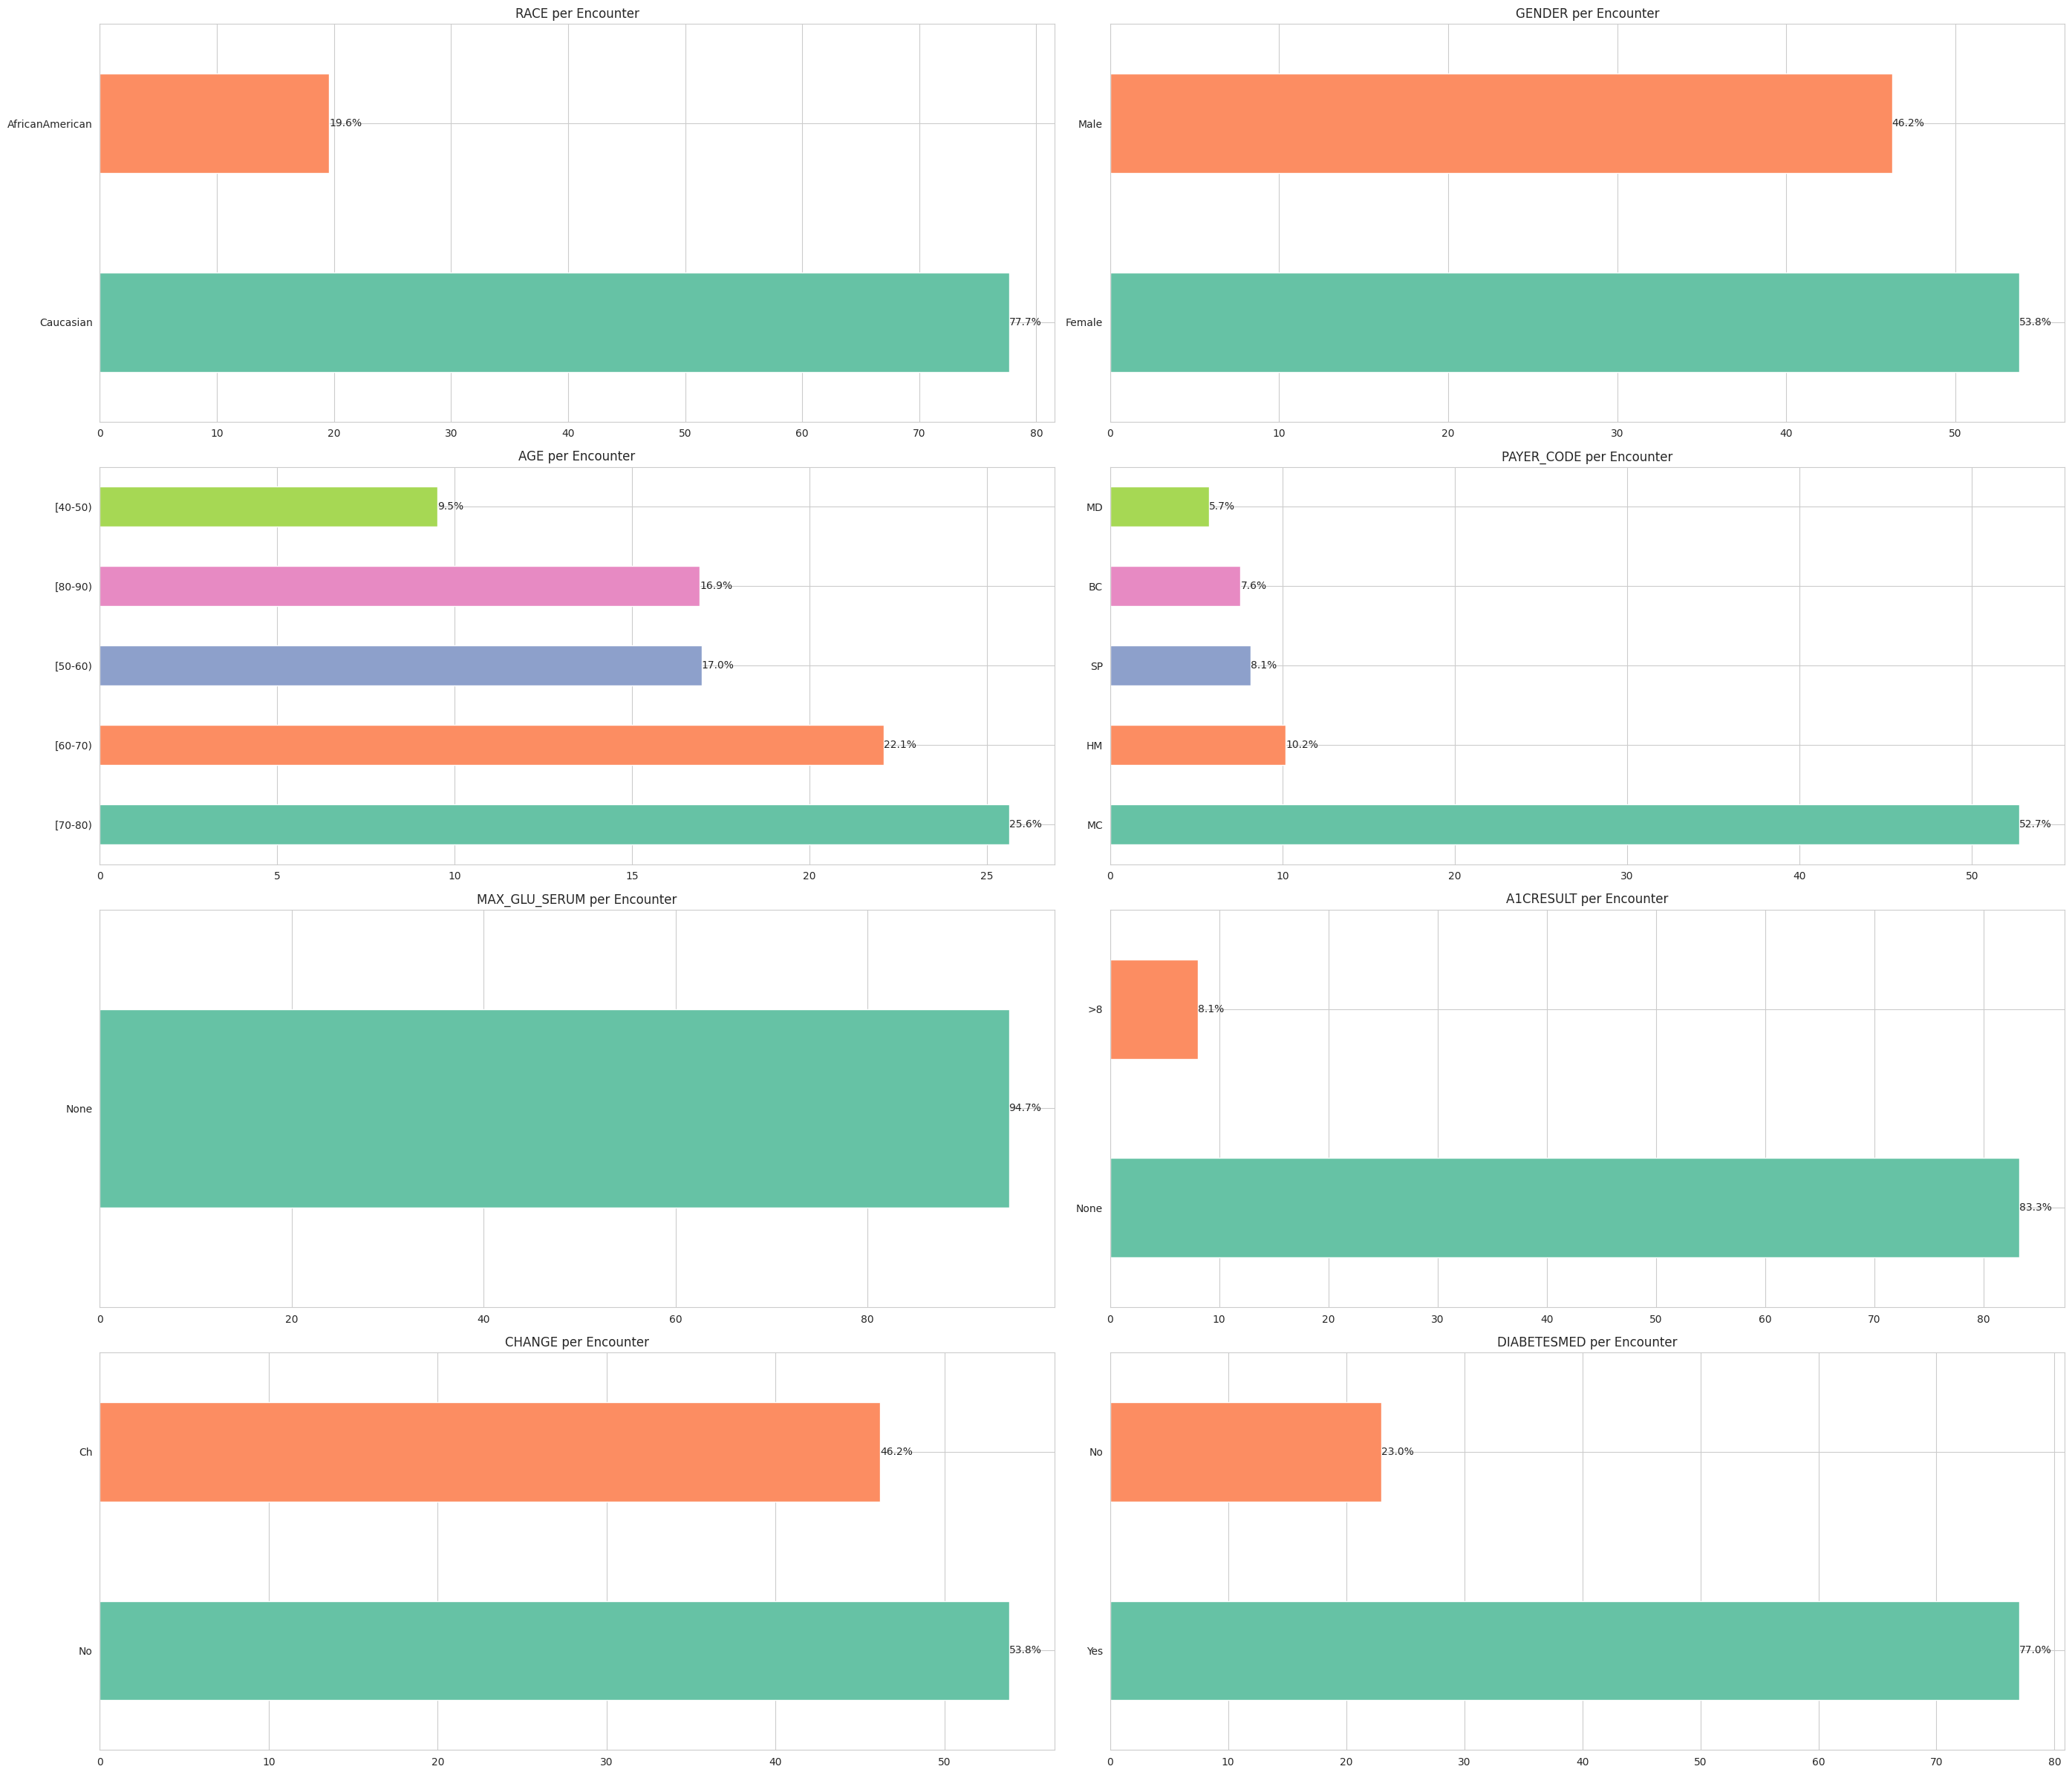

In [93]:
# Number of plots per row
plots_per_row = 2

# Calculate the number of rows needed
num_rows = len(cat_nonmed_plotting) // plots_per_row + (
    len(cat_nonmed_plotting) % plots_per_row > 0
)

# Set up the matplotlib figure
fig, axes = plt.subplots(
    nrows=num_rows, ncols=plots_per_row, figsize=(14 * plots_per_row, 6 * num_rows)
)

for i, feature_toplot in enumerate(cat_nonmed_plotting):
    # Determine the current subplot row and column
    row = i // plots_per_row
    col = i % plots_per_row

    # Current axis
    ax = axes[row, col] if num_rows > 1 else axes[col]

    # Feature counts and filtering
    counts_encounter = (
        df[feature_toplot].value_counts(normalize=True) * 100
    )  # Convert counts to percentages
    filtered_counts_encounter = counts_encounter[
        counts_encounter > 5
    ]  # Filter values where percentage is greater than 2%

    # Plot
    filtered_counts_encounter.plot(kind="barh", color=sns.color_palette("Set2"), ax=ax)
    ax.set_title(f"{feature_toplot} per Encounter")

    # Add percentage text next to each bar
    for index, value in enumerate(filtered_counts_encounter):
        ax.text(value, index, f"{value:.1f}%", va="center")

# Adjust layout to prevent overlap and ensure clarity
plt.tight_layout()
plt.show()


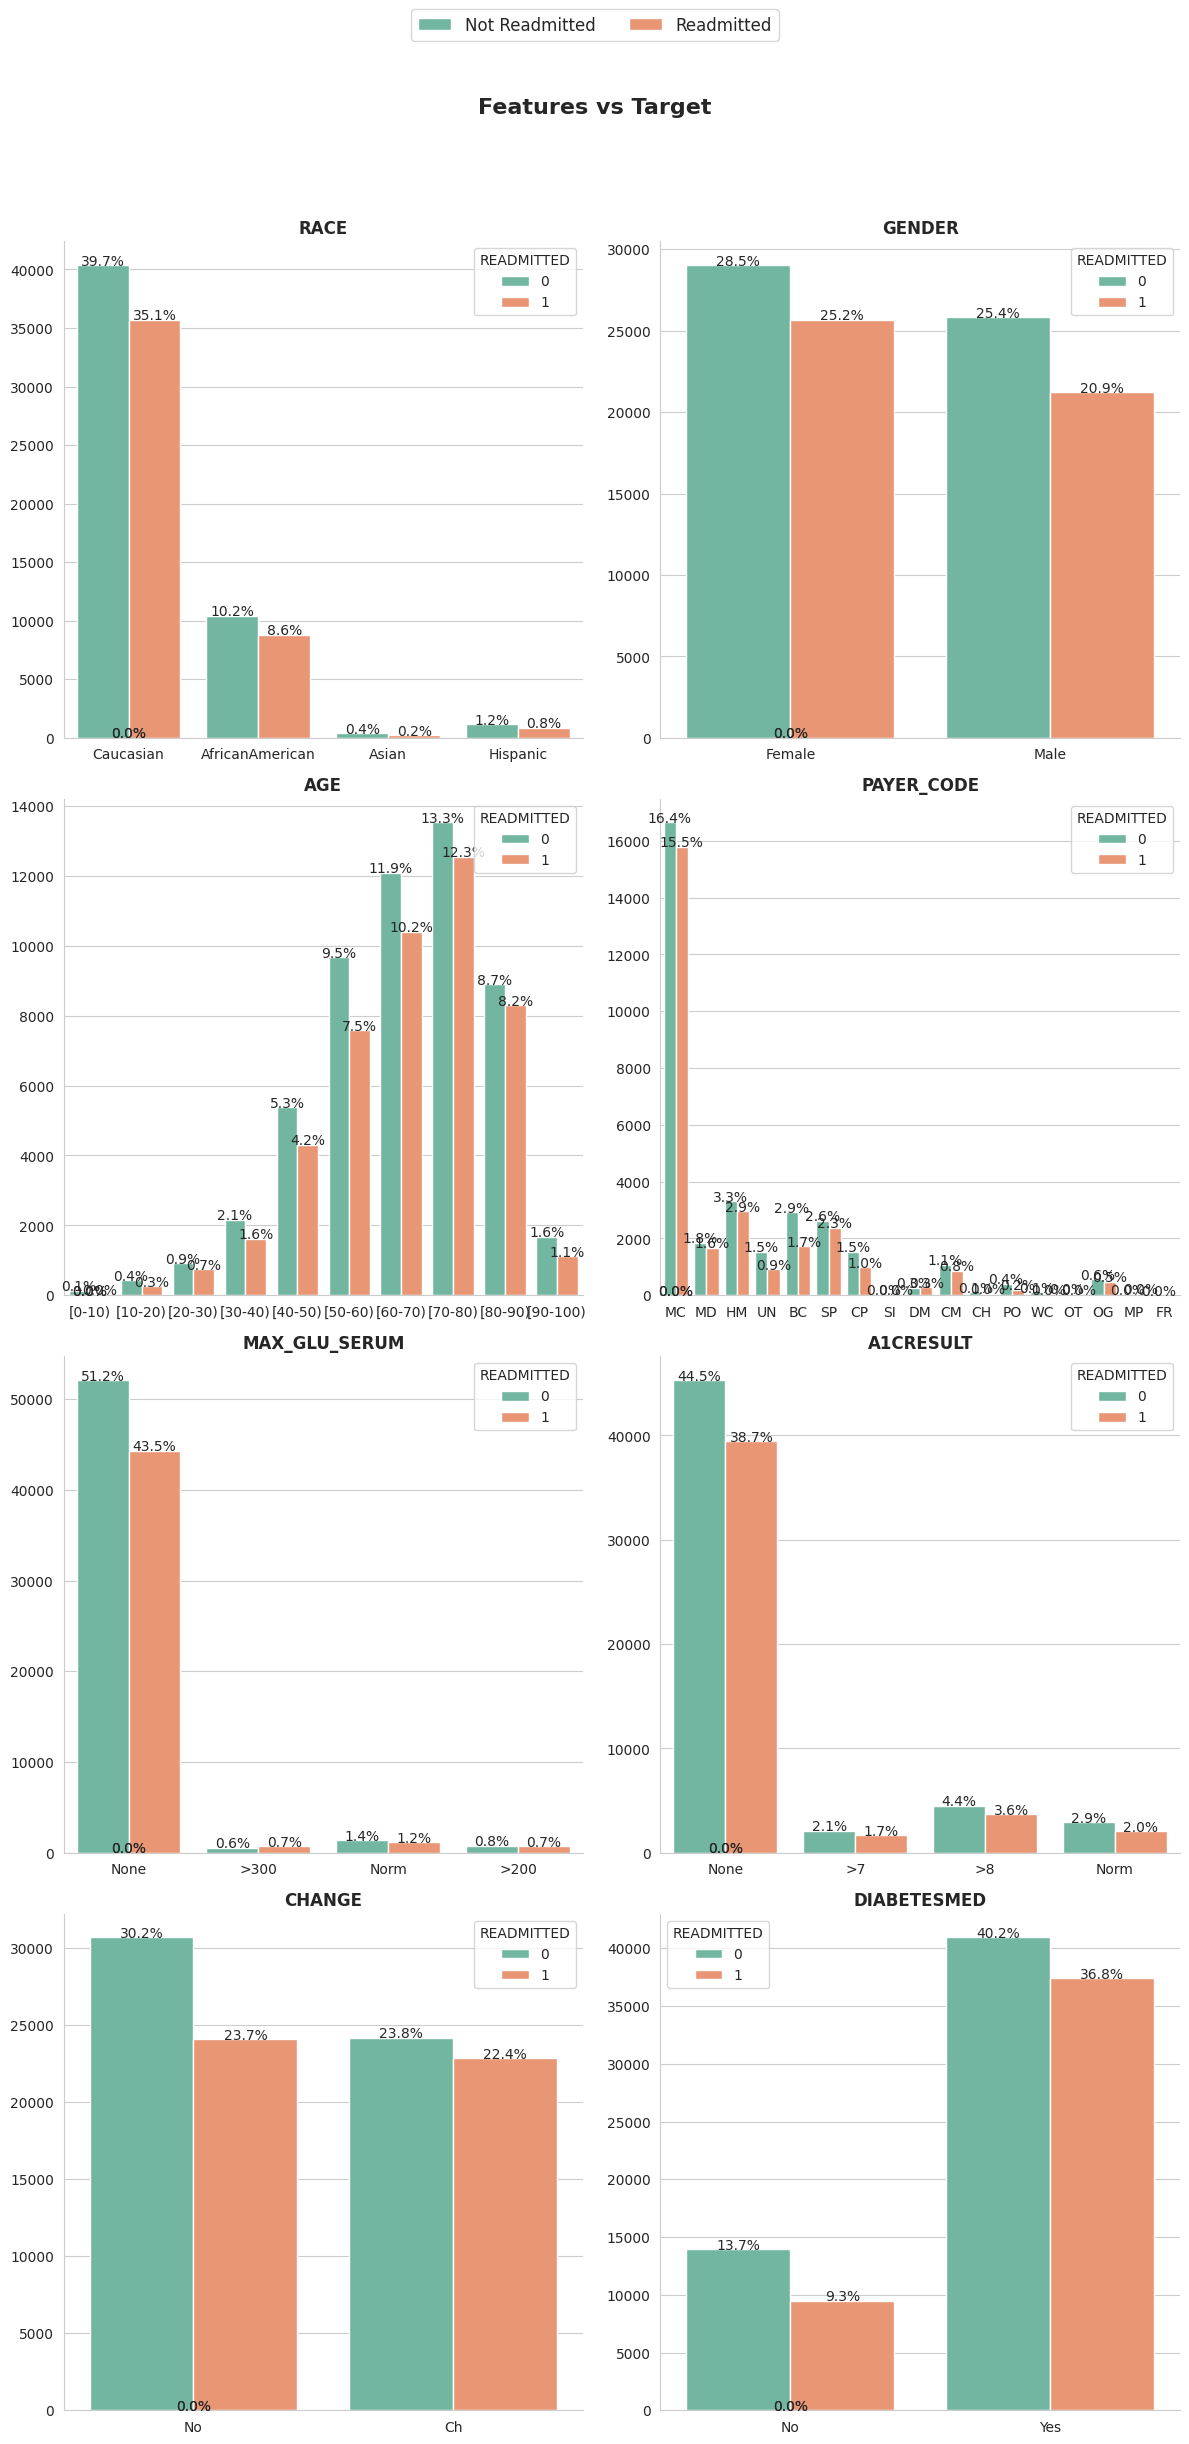

In [94]:
# Categorical data, hued per readmission

# Determine the size and layout of the subplots
figsize = (12, len(cat_nonmed_plotting) * 3)  # Adjusted for better visualization
n_cols = 2  # Number of columns in the subplot grid
n_rows = len(cat_nonmed_plotting) // n_cols + (
    len(cat_nonmed_plotting) % n_cols > 0
)  # Calculate required number of rows

fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

for idx, cat_col in enumerate(cat_nonmed_plotting):
    row = idx // n_cols
    col_idx = idx % n_cols
    ax = (
        axes[row, col_idx] if n_rows > 1 else axes[col_idx]
    )  # Adjust for when there's only one row
    sns.countplot(data=df, hue="READMITTED", x=cat_col, palette="Set2", ax=ax)

    # Calculate and display the percentages on the bars
    # ! TODO : Fix the percentages
    for p in ax.patches:
        height = p.get_height()
        total = len(
            df[cat_col]
        )  # Total number of observations for the current category
        percentage = f"{100 * height / total:.1f}%"  # Calculate percentage

        # Get the current patch's x-coordinate and width
        x = p.get_x()
        width = p.get_width()

        # Set the text annotations centered above each patch
        ax.text(x + width / 2.0, height + 5, percentage, ha="center")

    # Improve subplot aesthetics
    ax.set_ylabel("")
    ax.spines["top"].set_visible(False)
    ax.set_xlabel("")
    ax.spines["right"].set_visible(False)
    ax.set_title(f"{cat_col}", loc="center", weight="bold", fontsize=12)

# Hide any unused subplots
if len(cat_nonmed_plotting) % n_cols != 0:
    for idx in range(len(cat_nonmed_plotting), n_rows * n_cols):
        fig.delaxes(axes.flatten()[idx])

# Adjust the layout and add a title
fig.suptitle("Features vs Target", ha="center", fontweight="bold", fontsize=16)

# Add a legend outside the last subplot
handles, labels = ax.get_legend_handles_labels()
fig.legend(
    handles,
    ["Not Readmitted", "Readmitted"],
    loc="upper center",
    bbox_to_anchor=(0.5, 1.02),
    ncol=2,
    fontsize=12,
)

plt.tight_layout(
    rect=[0, 0, 1, 0.95]
)  # Adjust the rect parameter to make space for the title and legend
plt.show()


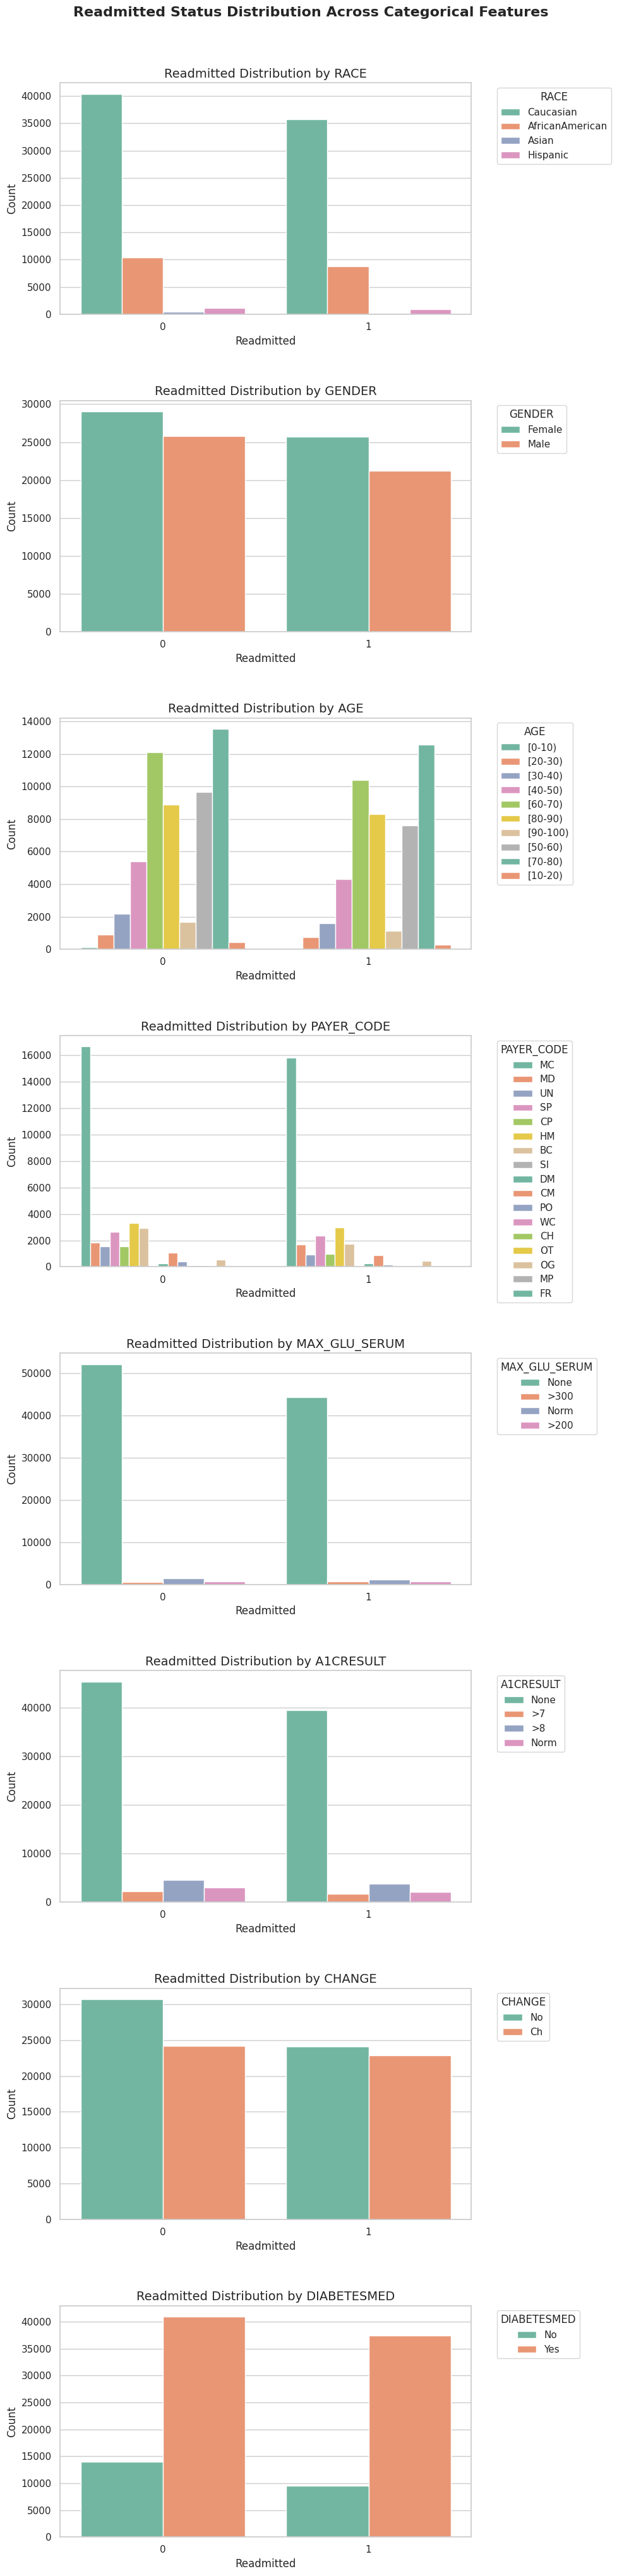

In [95]:
# Readmissions hued per non-medication categorical features

# Layout Setup
sns.set(style="whitegrid")
num_features = len(cat_nonmed_plotting)
figsize = (
    10,
    5 * num_features,
)  # Height is scaled by the number of features for clarity

# Create a figure to hold the subplots
fig = plt.figure(figsize=figsize)

# Iterate over each categorical feature to create a subplot
for idx, cat_col in enumerate(cat_nonmed_plotting):
    ax = fig.add_subplot(num_features, 1, idx + 1)
    sns.countplot(data=df, x="READMITTED", hue=cat_col, palette="Set2", ax=ax)

    # Improve subplot aesthetics
    ax.set_ylabel("Count")
    ax.set_xlabel("Readmitted")
    ax.set_title(f"Readmitted Distribution by {cat_col}", fontsize=14)
    ax.legend(title=cat_col, bbox_to_anchor=(1.05, 1), loc="upper left")

# Adjust layout to prevent overlap
plt.tight_layout()

# Add a main title
fig.suptitle(
    "Readmitted Status Distribution Across Categorical Features",
    fontsize=16,
    fontweight="bold",
    y=1.02,
)

plt.show()


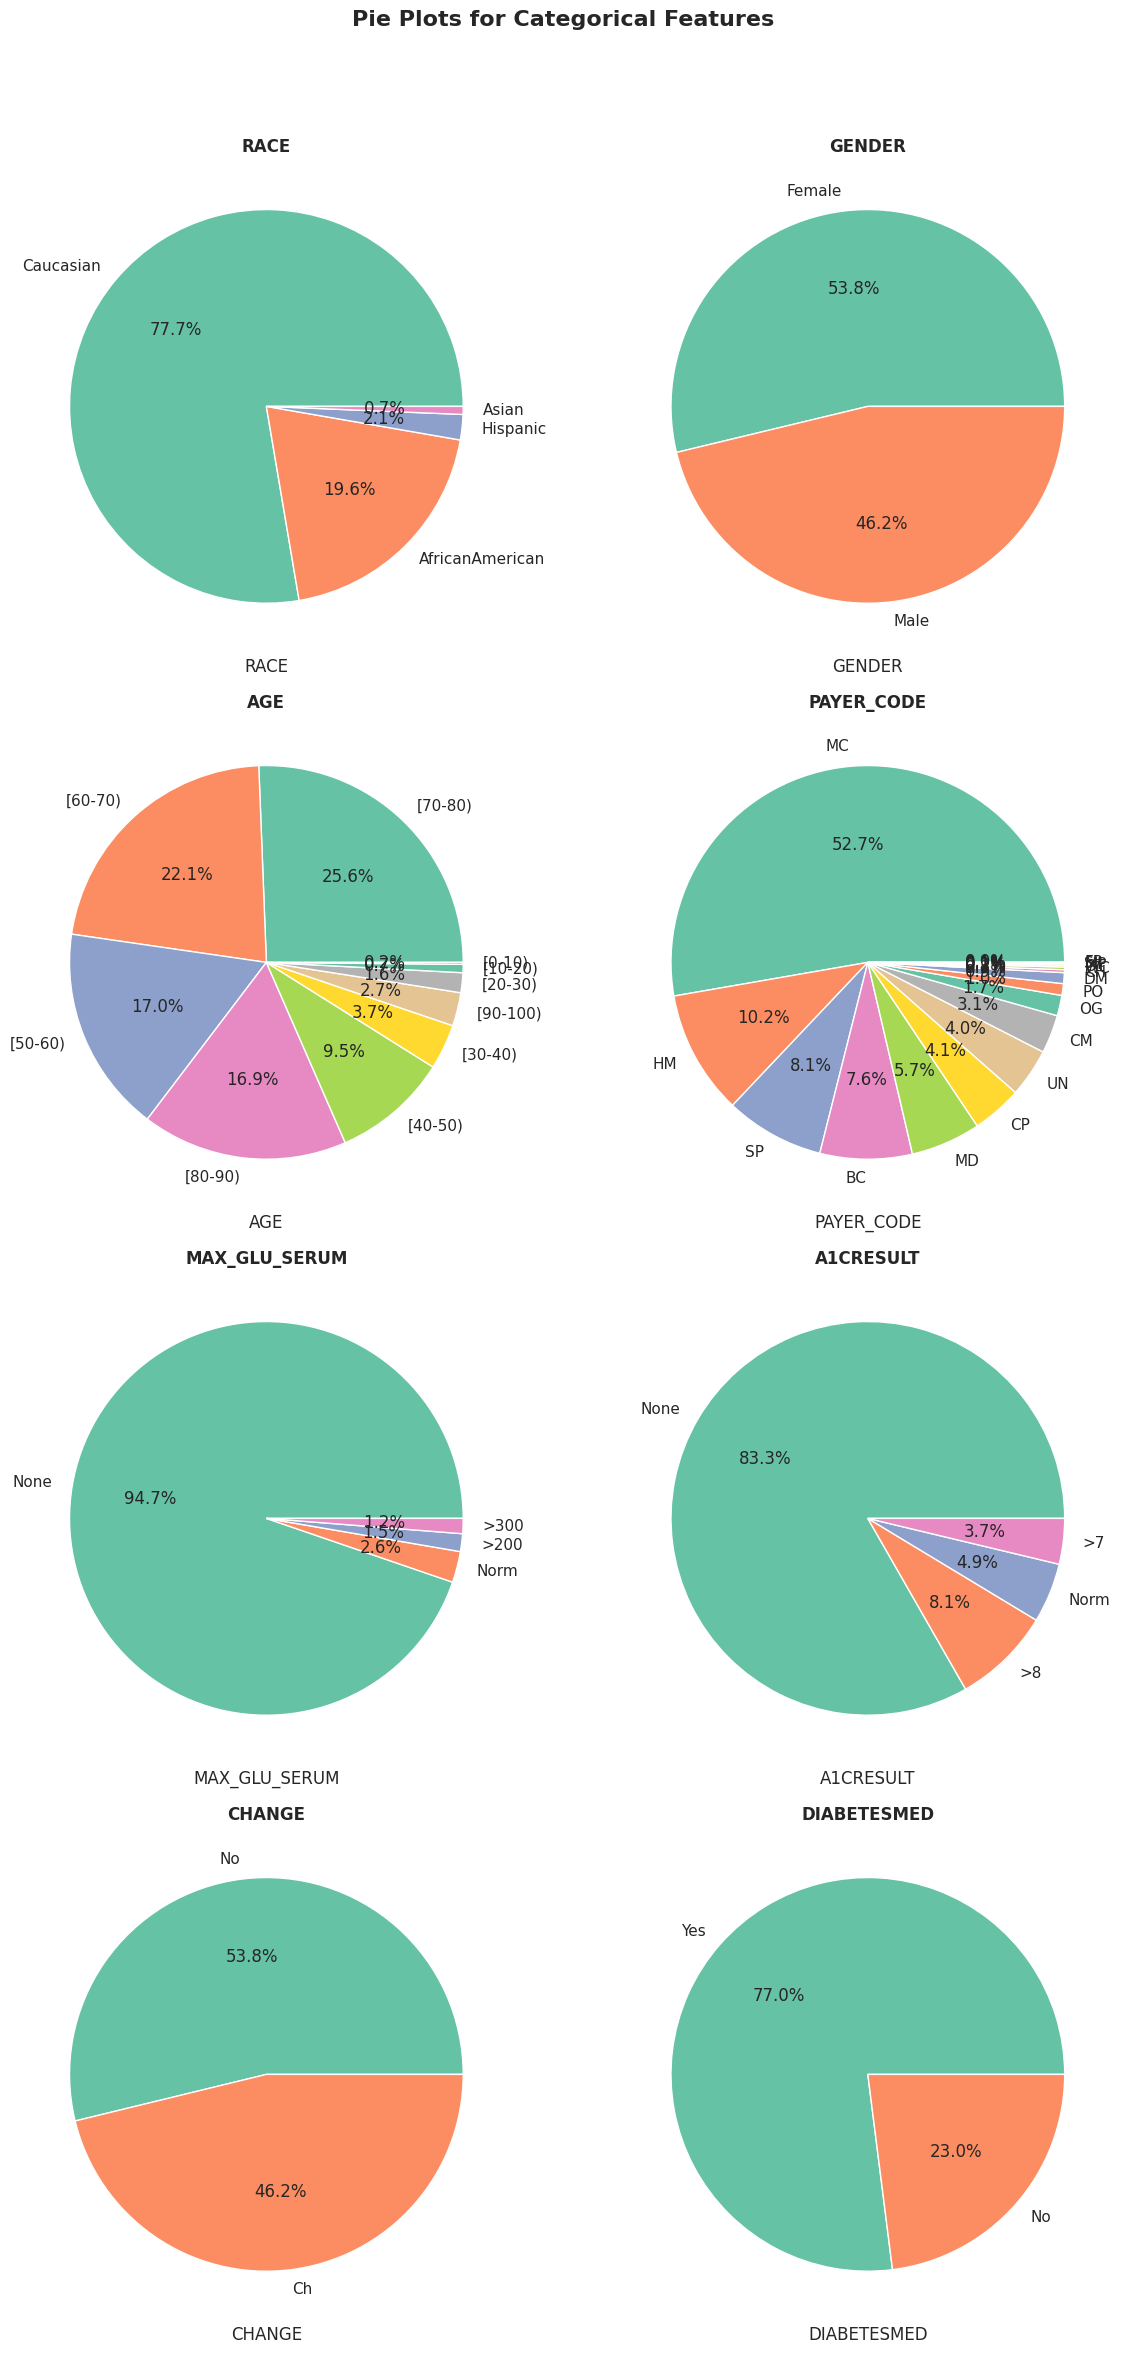

In [96]:
# PIE CHARTS

figsize = (12, len(cat_nonmed_plotting) * 3)  # Adjusted for better visualization
n_cols = 2  # Number of columns in the subplot grid
n_rows = len(cat_nonmed_plotting) // n_cols + (
    len(cat_nonmed_plotting) % n_cols > 0
)  # Add an extra row if there's an odd number

fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)

for idx, cat_col in enumerate(cat_nonmed_plotting):
    row = idx // n_cols
    col_idx = idx % n_cols
    ax = (
        axes[row, col_idx] if n_rows > 1 else axes[col_idx]
    )  # Adjust for when there's only one row
    df[cat_col].value_counts().plot.pie(
        ax=ax, autopct="%.1f%%", colors=sns.color_palette("Set2")
    )

    # Improve subplot aesthetics
    ax.set_ylabel("")
    ax.set_xlabel(cat_col)
    ax.set_title(f"{cat_col}", loc="center", weight="bold", fontsize=12)

# Hide any unused subplots
if len(cat_nonmed_plotting) % n_cols != 0:
    for idx in range(len(cat_nonmed_plotting), n_rows * n_cols):
        fig.delaxes(axes.flatten()[idx])

# Adjust the layout and add a title
fig.suptitle(
    "Pie Plots for Categorical Features", ha="center", fontweight="bold", fontsize=16
)

plt.tight_layout(
    rect=[0, 0, 1, 0.95]
)  # Adjust the rect parameter to make space for the title

plt.show()


### 3/ Identification columns


In [97]:
id_cols


['ENCOUNTER_ID',
 'PATIENT_NBR',
 'DISCHARGE_DISPOSITION_ID',
 'ADMISSION_SOURCE_ID',
 'ADMISSION_TYPE_ID']

In [98]:
IDs_mapping_filepath = '/content/drive/My Drive/CODE/24UCL/term2/AAI/CW1/data/IDs_mapping.csv'
IDs_mapping = pd.read_csv(IDs_mapping_filepath)


In [99]:
IDs_mapping["admission_type_id"].unique()


array(['1', '2', '3', '4', '5', '6', '7', '8', nan,
       'discharge_disposition_id', '9', '10', '11', '12', '13', '14',
       '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25',
       '26', '30', '27', '28', '29', 'admission_source_id'], dtype=object)

In [100]:
len(IDs_mapping)


67

In [101]:
# Define a function to create a dictionary from a list of lines
def create_dict_from_lines(lines):
    result_dict = {}
    for line in lines:
        parts = line.split(",")
        if len(parts) == 2:  # Ensure there are exactly two elements to unpack
            key, value = parts
            result_dict[key.strip()] = value.strip()
    return result_dict


# Initialize outputs
admission_type_dict = {}
admission_source_dict = {}
discharge_disposition_dict = {}
current_dict = None

# Read the file line by line and process it
with open(IDs_mapping_filepath, "r") as file:
    for line in file:
        line = line.strip()
        if "admission_type_id" in line:
            current_dict = admission_type_dict
        elif "discharge_disposition_id" in line:
            current_dict = discharge_disposition_dict
        elif "admission_source_id" in line:
            current_dict = admission_source_dict
        elif line and current_dict is not None:
            # Skip lines that don't have a comma (e.g., empty lines or malformatted)
            if "," not in line:
                continue
            # Add the entry to the current dictionary
            key, value = line.split(",", 1)
            current_dict[key.strip()] = value.strip()

# Outputs: admission_type_dict, discharge_disposition_dict, admission_source_dict


#### a. Admission type disposition


In [102]:
admission_type_dict


{'1': 'Emergency',
 '2': 'Urgent',
 '3': 'Elective',
 '4': 'Newborn',
 '5': 'Not Available',
 '6': 'NULL',
 '7': 'Trauma Center',
 '8': 'Not Mapped',
 '': ''}

In [103]:
admission_type_dict = {str(key): val for key, val in admission_type_dict.items()}


In [104]:
df_admission_type = df[
    [
        "ENCOUNTER_ID",
        "PATIENT_NBR",
        "READMITTED",
        "ADMISSION_TYPE_ID",
    ]
]
df_admission_type.head()


ENCOUNTER_ID  PATIENT_NBR  READMITTED  ADMISSION_TYPE_ID
0       2278392      8222157           0                  6
1        149190     55629189           1                  1
2         64410     86047875           0                  1
3        500364     82442376           0                  1
4         16680     42519267           0                  1

In [105]:
# Convert the 'DISCHARGE_DISPOSITION_ID' to string
df_admission_type.loc[:, "ADMISSION_TYPE_ID"] = df_admission_type[
    "ADMISSION_TYPE_ID"
].astype(str)


<ipython-input-105-7a3408a2561c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_admission_type.loc[:, "ADMISSION_TYPE_ID"] = df_admission_type[


In [106]:
# Use .loc to ensure you're modifying the original DataFrame
df_admission_type.loc[:, "ADMISSION_TYPE_DESCRIPTION"] = df_admission_type[
    "ADMISSION_TYPE_ID"
].map(admission_type_dict)

# Display the first few rows to verify the changes
df_admission_type.head()


<ipython-input-106-5a2f567c15cd>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_admission_type.loc[:, "ADMISSION_TYPE_DESCRIPTION"] = df_admission_type[


ENCOUNTER_ID  PATIENT_NBR  READMITTED ADMISSION_TYPE_ID  \
0       2278392      8222157           0                 6   
1        149190     55629189           1                 1   
2         64410     86047875           0                 1   
3        500364     82442376           0                 1   
4         16680     42519267           0                 1   

  ADMISSION_TYPE_DESCRIPTION  
0                       NULL  
1                  Emergency  
2                  Emergency  
3                  Emergency  
4                  Emergency

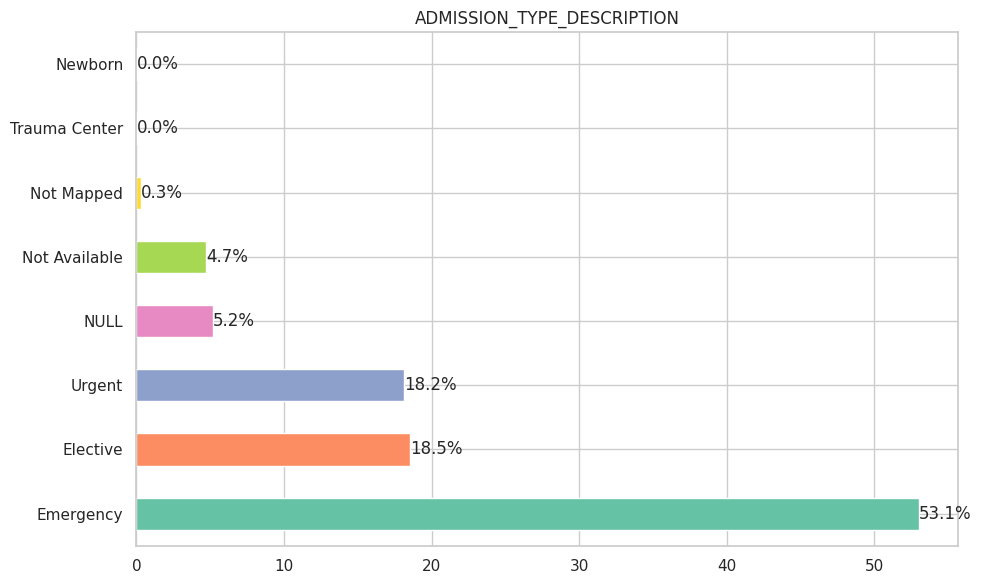

In [107]:
# Set up the matplotlib figure with 1 row and 1 column
fig, ax = plt.subplots(figsize=(10, 6))

# DISCHARGE_DISPOSITION_DESCRIPTION bar plot
counts_discharge = (
    df_admission_type["ADMISSION_TYPE_DESCRIPTION"].value_counts(normalize=True) * 100
)
filtered_counts_admission_type = counts_discharge[counts_discharge > 0]
filtered_counts_admission_type.plot(kind="barh", color=sns.color_palette("Set2"), ax=ax)
ax.set_title("ADMISSION_TYPE_DESCRIPTION")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_admission_type):
    ax.text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


In [108]:
# Count the occurrences of each 'ADMISSION_TYPE_ID'
admission_type_counts = df_admission_type["ADMISSION_TYPE_ID"].value_counts(
    ascending=True
)

# Create a DataFrame with 'ADMISSION_TYPE_ID' and its count
admission_type_counts_df = admission_type_counts.reset_index()
admission_type_counts_df.columns = ["ADMISSION_TYPE_ID", "COUNT"]

# Merge with the descriptions to get a full table
admission_type_description_df = df_admission_type[
    ["ADMISSION_TYPE_ID", "ADMISSION_TYPE_DESCRIPTION"]
].drop_duplicates()
admission_type_table = admission_type_counts_df.merge(
    admission_type_description_df, on="ADMISSION_TYPE_ID", how="left"
)

# Sort the table by the count of 'ADMISSION_TYPE_ID' from least to most present
admission_type_table_sorted = admission_type_table.sort_values(by="COUNT")
admission_type_table_sorted[
    ["ADMISSION_TYPE_DESCRIPTION", "ADMISSION_TYPE_ID", "COUNT"]
]


ADMISSION_TYPE_DESCRIPTION ADMISSION_TYPE_ID  COUNT
0                    Newborn                 4     10
1              Trauma Center                 7     21
2                 Not Mapped                 8    320
3              Not Available                 5   4785
4                       NULL                 6   5291
5                     Urgent                 2  18480
6                   Elective                 3  18869
7                  Emergency                 1  53990

#### a. Admission source disposition


In [109]:
admission_source_dict


{'1': 'Physician Referral',
 '2': 'Clinic Referral',
 '3': 'HMO Referral',
 '4': 'Transfer from a hospital',
 '5': 'Transfer from a Skilled Nursing Facility (SNF)',
 '6': 'Transfer from another health care facility',
 '7': 'Emergency Room',
 '8': 'Court/Law Enforcement',
 '9': 'Not Available',
 '10': 'Transfer from critial access hospital',
 '11': 'Normal Delivery',
 '12': 'Premature Delivery',
 '13': 'Sick Baby',
 '14': 'Extramural Birth',
 '15': 'Not Available',
 '17': 'NULL',
 '18': 'Transfer From Another Home Health Agency',
 '19': 'Readmission to Same Home Health Agency',
 '20': 'Not Mapped',
 '21': 'Unknown/Invalid',
 '22': 'Transfer from hospital inpt/same fac reslt in a sep claim',
 '23': 'Born inside this hospital',
 '24': 'Born outside this hospital',
 '25': 'Transfer from Ambulatory Surgery Center',
 '26': 'Transfer from Hospice'}

In [110]:
admission_source_dict = {str(key): val for key, val in admission_source_dict.items()}


In [111]:
df_admission_source = df[
    [
        "ENCOUNTER_ID",
        "PATIENT_NBR",
        "READMITTED",
        "ADMISSION_SOURCE_ID",
    ]
]
df_admission_source.head()


ENCOUNTER_ID  PATIENT_NBR  READMITTED  ADMISSION_SOURCE_ID
0       2278392      8222157           0                    1
1        149190     55629189           1                    7
2         64410     86047875           0                    7
3        500364     82442376           0                    7
4         16680     42519267           0                    7

In [112]:
# Convert the 'DISCHARGE_DISPOSITION_ID' to string
df_admission_source.loc[:, "ADMISSION_SOURCE_ID"] = df_admission_source[
    "ADMISSION_SOURCE_ID"
].astype(str)


<ipython-input-112-6001abd565ad>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_admission_source.loc[:, "ADMISSION_SOURCE_ID"] = df_admission_source[


In [113]:
# Use .loc to ensure you're modifying the original DataFrame
df_admission_source.loc[:, "ADMISSION_SOURCE_DESCRIPTION"] = df_admission_source[
    "ADMISSION_SOURCE_ID"
].map(admission_source_dict)

# Display the first few rows to verify the changes
df_admission_source.head()


<ipython-input-113-968c373c0e0c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_admission_source.loc[:, "ADMISSION_SOURCE_DESCRIPTION"] = df_admission_source[


ENCOUNTER_ID  PATIENT_NBR  READMITTED ADMISSION_SOURCE_ID  \
0       2278392      8222157           0                   1   
1        149190     55629189           1                   7   
2         64410     86047875           0                   7   
3        500364     82442376           0                   7   
4         16680     42519267           0                   7   

  ADMISSION_SOURCE_DESCRIPTION  
0           Physician Referral  
1               Emergency Room  
2               Emergency Room  
3               Emergency Room  
4               Emergency Room

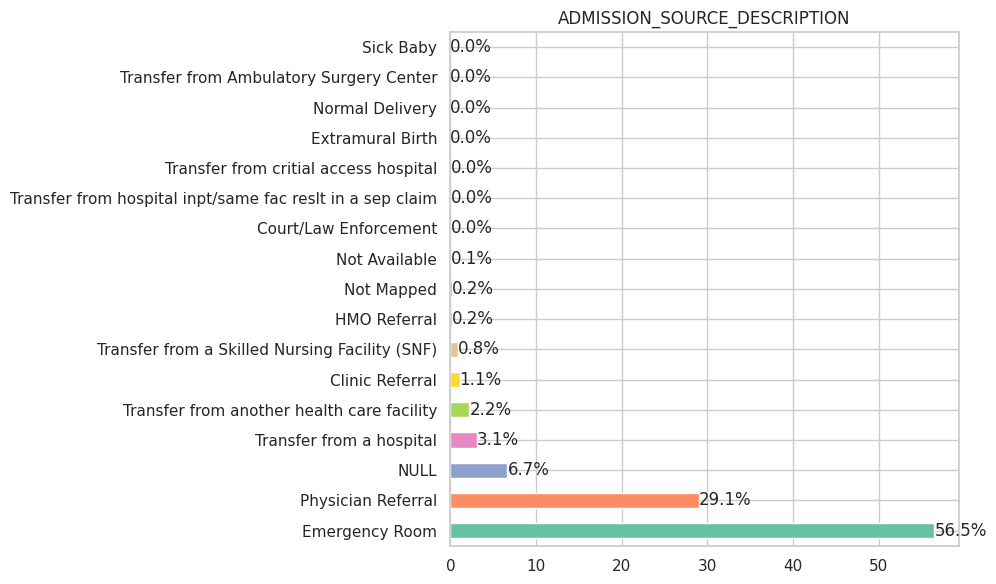

In [114]:
# Set up the matplotlib figure with 1 row and 1 column
fig, ax = plt.subplots(figsize=(10, 6))

# DISCHARGE_DISPOSITION_DESCRIPTION bar plot
counts_admission_source = (
    df_admission_source["ADMISSION_SOURCE_DESCRIPTION"].value_counts(normalize=True)
    * 100
)
filtered_counts_admission_source = counts_admission_source[counts_admission_source > 0]
filtered_counts_admission_source.plot(
    kind="barh", color=sns.color_palette("Set2"), ax=ax
)
ax.set_title("ADMISSION_SOURCE_DESCRIPTION")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_admission_source):
    ax.text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


In [115]:

# Count the occurrences of each 'ADMISSION_SOURCE_ID'
admission_source_counts = df_admission_source["ADMISSION_SOURCE_ID"].value_counts(
    ascending=True
)

# Create a DataFrame with 'ADMISSION_SOURCE_ID' and its count
admission_source_counts_df = admission_source_counts.reset_index()
admission_source_counts_df.columns = ["ADMISSION_SOURCE_ID", "COUNT"]

# Merge with the descriptions to get a full table
admission_source_description_df = df_admission_source[
    ["ADMISSION_SOURCE_ID", "ADMISSION_SOURCE_DESCRIPTION"]
].drop_duplicates()
admission_source_table = admission_source_counts_df.merge(
    admission_source_description_df, on="ADMISSION_SOURCE_ID", how="left"
)

# Sort the table by the count of 'ADMISSION_SOURCE_ID' from least to most present
admission_source_table_sorted = admission_source_table.sort_values(by="COUNT")
admission_source_table_sorted[
    ["ADMISSION_SOURCE_DESCRIPTION", "ADMISSION_SOURCE_ID", "COUNT"]
]


ADMISSION_SOURCE_DESCRIPTION ADMISSION_SOURCE_ID  \
0                                           Sick Baby                  13   
1                                     Normal Delivery                  11   
2             Transfer from Ambulatory Surgery Center                  25   
3                                    Extramural Birth                  14   
4               Transfer from critial access hospital                  10   
5   Transfer from hospital inpt/same fac reslt in ...                  22   
6                               Court/Law Enforcement                   8   
7                                       Not Available                   9   
8                                          Not Mapped                  20   
9                                        HMO Referral                   3   
10     Transfer from a Skilled Nursing Facility (SNF)                   5   
11                                    Clinic Referral                   2   
12         Transfer from another health care facility                   6   
13                           Transfer from a hospital                   4   
14                                               NULL                  17   
15                                 Physician Referral                   1   
16                                     Emergency Room                   7   

    COUNT  
0       1  
1       2  
2       2  
3       2  
4       8  
5      12  
6      16  
7     125  
8     161  
9     187  
10    855  
11   1104  
12   2264  
13   3187  
14   6781  
15  29565  
16  57494

#### c. Discharge disposition


In [116]:
discharge_disposition_dict


{'1': 'Discharged to home',
 '2': 'Discharged/transferred to another short term hospital',
 '3': 'Discharged/transferred to SNF',
 '4': 'Discharged/transferred to ICF',
 '5': 'Discharged/transferred to another type of inpatient care institution',
 '6': 'Discharged/transferred to home with home health service',
 '7': 'Left AMA',
 '8': 'Discharged/transferred to home under care of Home IV provider',
 '9': 'Admitted as an inpatient to this hospital',
 '10': 'Neonate discharged to another hospital for neonatal aftercare',
 '11': 'Expired',
 '12': 'Still patient or expected to return for outpatient services',
 '13': 'Hospice / home',
 '14': 'Hospice / medical facility',
 '15': 'Discharged/transferred within this institution to Medicare approved swing bed',
 '16': 'Discharged/transferred/referred another institution for outpatient services',
 '17': 'Discharged/transferred/referred to this institution for outpatient services',
 '18': 'NULL',
 '19': '"Expired at home. Medicaid only, hospice."'

In [117]:
discharge_disposition_dict = {
    str(key): val for key, val in discharge_disposition_dict.items()
}


In [118]:
df_discharge = df[
    [
        "ENCOUNTER_ID",
        "PATIENT_NBR",
        "READMITTED",
        "DISCHARGE_DISPOSITION_ID",
    ]
]
df_discharge.head()


ENCOUNTER_ID  PATIENT_NBR  READMITTED  DISCHARGE_DISPOSITION_ID
0       2278392      8222157           0                        25
1        149190     55629189           1                         1
2         64410     86047875           0                         1
3        500364     82442376           0                         1
4         16680     42519267           0                         1

In [119]:
print(df_discharge["DISCHARGE_DISPOSITION_ID"].dtype)


int64


In [120]:
# Convert the 'DISCHARGE_DISPOSITION_ID' to string
df_discharge.loc[:, "DISCHARGE_DISPOSITION_ID"] = df_discharge[
    "DISCHARGE_DISPOSITION_ID"
].astype(str)


<ipython-input-120-0099177df9f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_discharge.loc[:, "DISCHARGE_DISPOSITION_ID"] = df_discharge[


In [121]:

df_discharge.loc[:, "DISCHARGE_DISPOSITION_DESCRIPTION"] = df_discharge[
    "DISCHARGE_DISPOSITION_ID"
].map(discharge_disposition_dict)

# Display the first few rows to verify the changes
df_discharge.head()


<ipython-input-121-19e00a96bbd9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_discharge.loc[:, "DISCHARGE_DISPOSITION_DESCRIPTION"] = df_discharge[


ENCOUNTER_ID  PATIENT_NBR  READMITTED DISCHARGE_DISPOSITION_ID  \
0       2278392      8222157           0                       25   
1        149190     55629189           1                        1   
2         64410     86047875           0                        1   
3        500364     82442376           0                        1   
4         16680     42519267           0                        1   

  DISCHARGE_DISPOSITION_DESCRIPTION  
0                        Not Mapped  
1                Discharged to home  
2                Discharged to home  
3                Discharged to home  
4                Discharged to home

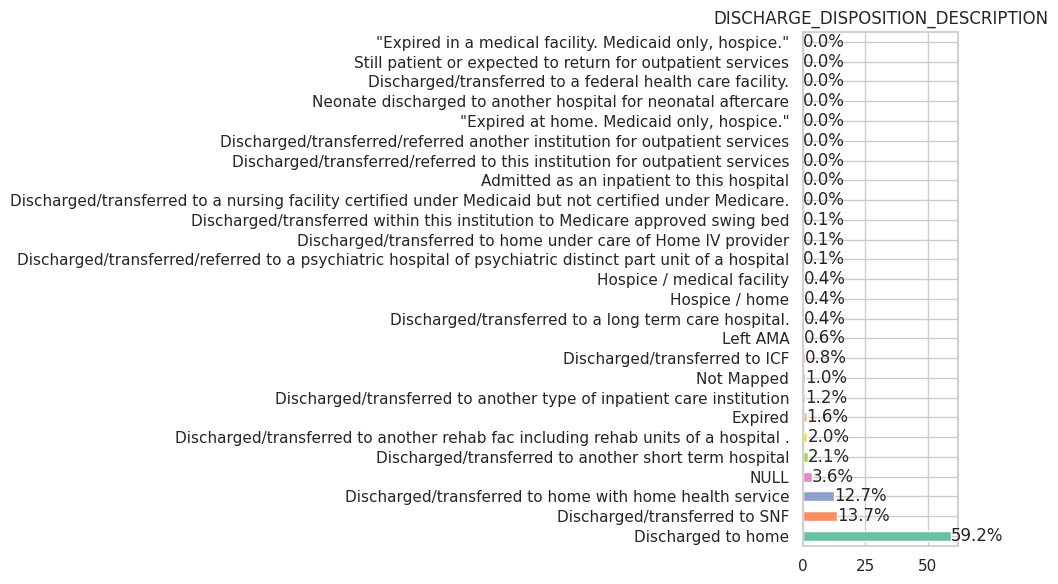

In [122]:
# Set up the matplotlib figure with 1 row and 1 column
fig, ax = plt.subplots(figsize=(10, 6))

# DISCHARGE_DISPOSITION_DESCRIPTION bar plot
counts_discharge = (
    df_discharge["DISCHARGE_DISPOSITION_DESCRIPTION"].value_counts(normalize=True) * 100
)
filtered_counts_discharge = counts_discharge[counts_discharge > 0]
filtered_counts_discharge.plot(kind="barh", color=sns.color_palette("Set2"), ax=ax)
ax.set_title("DISCHARGE_DISPOSITION_DESCRIPTION")
# Add percentage text next to each bar
for index, value in enumerate(filtered_counts_discharge):
    ax.text(value, index, f"{value:.1f}%", va="center")

plt.tight_layout()
plt.show()


In [123]:
# Count the occurrences of each 'DISCHARGE_DISPOSITION_ID'
discharge_counts = df_discharge["DISCHARGE_DISPOSITION_ID"].value_counts(ascending=True)

# Create a DataFrame with 'DISCHARGE_DISPOSITION_ID' and its count
discharge_counts_df = discharge_counts.reset_index()
discharge_counts_df.columns = ["DISCHARGE_DISPOSITION_ID", "COUNT"]

# Merge with the descriptions to get a full table
discharge_description_df = df_discharge[
    ["DISCHARGE_DISPOSITION_ID", "DISCHARGE_DISPOSITION_DESCRIPTION"]
].drop_duplicates()
discharge_table = discharge_counts_df.merge(
    discharge_description_df, on="DISCHARGE_DISPOSITION_ID", how="left"
)

# Sort the table by the count of 'DISCHARGE_DISPOSITION_ID' from least to most present
discharge_table_sorted = discharge_table.sort_values(by="COUNT")
discharge_table_sorted[
    ["DISCHARGE_DISPOSITION_DESCRIPTION", "DISCHARGE_DISPOSITION_ID", "COUNT"]
]


DISCHARGE_DISPOSITION_DESCRIPTION  \
0   "Expired in a medical facility. Medicaid only,...   
1   Still patient or expected to return for outpat...   
2   Discharged/transferred to a federal health car...   
3   Neonate discharged to another hospital for neo...   
4          "Expired at home. Medicaid only, hospice."   
5   Discharged/transferred/referred another instit...   
6   Discharged/transferred/referred to this instit...   
7           Admitted as an inpatient to this hospital   
8   Discharged/transferred to a nursing facility c...   
9   Discharged/transferred within this institution...   
10  Discharged/transferred to home under care of H...   
11  Discharged/transferred/referred to a psychiatr...   
12                         Hospice / medical facility   
13                                     Hospice / home   
14  Discharged/transferred to a long term care hos...   
15                                           Left AMA   
16                      Discharged/transferred to ICF   
17                                         Not Mapped   
18  Discharged/transferred to another type of inpa...   
19                                            Expired   
20  Discharged/transferred to another rehab fac in...   
21  Discharged/transferred to another short term h...   
22                                               NULL   
23  Discharged/transferred to home with home healt...   
24                      Discharged/transferred to SNF   
25                                 Discharged to home   

   DISCHARGE_DISPOSITION_ID  COUNT  
0                        20      2  
1                        12      3  
2                        27      5  
3                        10      6  
4                        19      8  
5                        16     11  
6                        17     14  
7                         9     21  
8                        24     48  
9                        15     63  
10                        8    108  
11                       28    139  
12                       14    372  
13                       13    399  
14                       23    412  
15                        7    623  
16                        4    815  
17                       25    989  
18                        5   1184  
19                       11   1642  
20                       22   1993  
21                        2   2128  
22                       18   3691  
23                        6  12902  
24                        3  13954  
25                        1  60234

In [124]:
discharge_ids_outofscope = [11, 13, 14, 19, 20, 21]
# Patients "Expired" or in Hospice


##  II. Data assembling and initial pre-processing (15%)

• Assemble a dataset consisting of features and labels (e.g. X and y). You can create a balanced dataset and use a smaller subset of the data to decrease the computation load (you can make a choice about the subset size depending on your computational resources). Describe the procedure used for assembling the data. (2.5%)

• Apply the pre-processing steps you consider necessary at this stage. Describe which data cleaning and pre-processing steps are needed (dropping features, encoding features, data imputation, etc). Keep in mind that some pre-processing steps need to be embedded in the cross-validation framework to avoid data leaking. (10%)

• Discuss which strategy could be used to better encode the diagnoses features
(diag_1, diag_2, diag_3). (2.5%)


#### Initial preprocessing

In [125]:
## Dropping patients that can't be readmitted
df = df[~df["DISCHARGE_DISPOSITION_ID"].isin(discharge_ids_outofscope)]

## Dropping second encounters of patients
first_encounters = df.groupby('PATIENT_NBR')['ENCOUNTER_ID'].min().reset_index()
first_encounter_df = pd.merge(first_encounters, df, on=['PATIENT_NBR', 'ENCOUNTER_ID'], how='left')
df=first_encounter_df

df.drop('ENCOUNTER_ID', axis=1, inplace=True)

## Target encoding
if "READMITTED" in df.columns and df["READMITTED"].nunique()>2:
    df["READMITTED"] = df["READMITTED"].apply(lambda x: 0 if x == "NO" else 1)


In [126]:
df.shape

(69990, 49)

In [127]:
features = [col for col in df.columns if col != target]

print(f"The target is {target}")

The target is READMITTED


### 1/ Creating a balanced dataset


In [128]:
proportion_subset=0.1 # Taking 10% of the dataset
stratification_variables=[target,'RACE','GENDER']
RANDOM_STATE = 42

In [129]:
grp_df=df.groupby(stratification_variables).apply(lambda x: x.sample(frac=proportion_subset,random_state=RANDOM_STATE))
grp_df.reset_index(drop=True, inplace=True)

In [130]:
grp_df.head().T

0                 1                2  \
PATIENT_NBR                       24380244           1347399        102483279   
RACE                       AfricanAmerican   AfricanAmerican  AfricanAmerican   
GENDER                              Female            Female           Female   
AGE                                [40-50)           [70-80)          [30-40)   
WEIGHT                                 NaN               NaN              NaN   
ADMISSION_TYPE_ID                        1                 2                1   
DISCHARGE_DISPOSITION_ID                 2                 1                1   
ADMISSION_SOURCE_ID                      4                 1                7   
TIME_IN_HOSPITAL                        12                 3                1   
PAYER_CODE                              SP                HM               BC   
MEDICAL_SPECIALTY         InternalMedicine  InternalMedicine              NaN   
NUM_LAB_PROCEDURES                      38                47               39   
NUM_PROCEDURES                           1                 0                3   
NUM_MEDICATIONS                         16                12               14   
NUMBER_OUTPATIENT                        0                 0                0   
NUMBER_EMERGENCY                         0                 0                0   
NUMBER_INPATIENT                         0                 0                0   
DIAG_1                              250.82               491              530   
DIAG_2                                 682               428              401   
DIAG_3                                 707               401              250   
NUMBER_DIAGNOSES                         9                 5                6   
MAX_GLU_SERUM                         None              None             None   
A1CRESULT                             None              Norm               >7   
METFORMIN                           Steady                No               No   
REPAGLINIDE                             No                No               No   
NATEGLINIDE                             No                No               No   
CHLORPROPAMIDE                          No                No               No   
GLIMEPIRIDE                             No                No               No   
ACETOHEXAMIDE                           No                No               No   
GLIPIZIDE                           Steady                No               No   
GLYBURIDE                               No            Steady               No   
TOLBUTAMIDE                             No                No               No   
PIOGLITAZONE                        Steady                No               No   
ROSIGLITAZONE                           No                No               No   
ACARBOSE                                No                No               No   
MIGLITOL                                No                No               No   
TROGLITAZONE                            No                No               No   
TOLAZAMIDE                              No                No               No   
EXAMIDE                                 No                No               No   
CITOGLIPTON                             No                No               No   
INSULIN                               Down            Steady               No   
GLYBURIDE-METFORMIN                     No                No               No   
GLIPIZIDE-METFORMIN                     No                No               No   
GLIMEPIRIDE-PIOGLITAZONE                No                No               No   
METFORMIN-ROSIGLITAZONE                 No                No               No   
METFORMIN-PIOGLITAZONE                  No                No               No   
CHANGE                                  Ch                Ch               No   
DIABETESMED                            Yes               Yes               No   
READMITTED                               0                 0            

In [131]:
# Defining X and y

X = grp_df.drop(target, axis=1)
# Label encoding for y
label_enc = LabelEncoder()
y = label_enc.fit_transform(grp_df[target])

In [132]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_STATE
)


In [133]:
print(f'TRAINING: \n Train shape {X_train.shape} \n Test shape {X_test.shape} \n -----')
print(f'TARGET:\n Train shape {y_train.shape} \n Test shape {y_test.shape}')

TRAINING: 
 Train shape (4685, 48) 
 Test shape (2008, 48) 
 -----
TARGET:
 Train shape (4685,) 
 Test shape (2008,)


In [134]:
#Saving just in case
X_train_init=X_train.copy()
X_test_init=X_test.copy()

###  2/ Creating a preprocessing Pipeline

- Dropping
  - Features to decrease complexity
  - Patients with inconsistent information, or outliers
- Filling: When missing values in actual information, it's encoded as a new category, its' the case for:
  - `DIAG_1`: Missing data means the diagnosis is missing, but it must exist -> It's encoded as "OTHER"
  - `DIAG_2`, `DIAG_3`, missing data means there was no second diagnosis needed -> It's encoded as "NO DIAGNOSIS"
  - `["MAX_GLU_SERUM", "A1CRESULT"]` missing data means no test was taken



### a. Defining the functions

In [135]:
# Custom transformer for dropping features
from sklearn.base import BaseEstimator, TransformerMixin

class FeatureDropper(BaseEstimator, TransformerMixin):
    def __init__(self, columns_to_drop=None):
        self.columns_to_drop = columns_to_drop
        self.columns_kept = None  # Initialize the attribute

    def fit(self, X, y=None):
        # Assuming X is a DataFrame, identify columns kept after dropping
        self.columns_kept = [col for col in X.columns if col not in self.columns_to_drop]
        return self

    def transform(self, X):
        X = X.drop(self.columns_to_drop, axis=1, errors='ignore')
        return X


print(f"Columns to drop: {empty_coltodrop}")

Columns to drop: ['ACARBOSE', 'ACETOHEXAMIDE', 'CHLORPROPAMIDE', 'GLIMEPIRIDE-PIOGLITAZONE', 'GLIPIZIDE-METFORMIN', 'GLYBURIDE-METFORMIN', 'METFORMIN-PIOGLITAZONE', 'METFORMIN-ROSIGLITAZONE', 'MIGLITOL', 'NATEGLINIDE', 'TOLAZAMIDE', 'TOLBUTAMIDE', 'TROGLITAZONE', 'WEIGHT', 'EXAMIDE', 'CITOGLIPTON']


In [136]:
# Custom transformer for filtering categories

class TopCategoriesFilter(BaseEstimator, TransformerMixin):
    def __init__(self, column, top_n=10, default_cat='OTHER'):
        self.column = column
        self.top_n = top_n
        self.default_cat = default_cat

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame")

        if self.column not in X.columns:
            raise ValueError(f"Column '{self.column}' not found in input DataFrame")

        self.top_categories_ = X[self.column].value_counts().nlargest(self.top_n).index.tolist()
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame")

        if self.column not in X.columns:
            raise ValueError(f"Column '{self.column}' not found in input DataFrame")

        X[self.column] = X[self.column].apply(lambda x: x if x in self.top_categories_ else self.default_cat)
        return X


# class TopCategoriesFilter(BaseEstimator, TransformerMixin):
#     def __init__(self, column, top_n=10, default_cat='OTHER'):
#         self.column = column
#         self.top_n = top_n
#         self.default_cat = default_cat

#     def fit(self, X, y=None):
#         self.top_categories_ = X[self.column].value_counts().nlargest(self.top_n).index.tolist()
#         return self

#     def transform(self, X):
#         X[self.column] = X[self.column].apply(lambda x: x if x in self.top_categories_ else self.default_cat)
#         return X

In [137]:
# Custom transformer for row filtering
class RowFilter(BaseEstimator, TransformerMixin):
    def __init__(self, filter_condition=None):
        self.filter_condition = filter_condition

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        if self.filter_condition:
            X = X[~self.filter_condition(X)]
        return X


In [138]:
X_train.columns

Index(['PATIENT_NBR', 'RACE', 'GENDER', 'AGE', 'WEIGHT', 'ADMISSION_TYPE_ID',
       'DISCHARGE_DISPOSITION_ID', 'ADMISSION_SOURCE_ID', 'TIME_IN_HOSPITAL',
       'PAYER_CODE', 'MEDICAL_SPECIALTY', 'NUM_LAB_PROCEDURES',
       'NUM_PROCEDURES', 'NUM_MEDICATIONS', 'NUMBER_OUTPATIENT',
       'NUMBER_EMERGENCY', 'NUMBER_INPATIENT', 'DIAG_1', 'DIAG_2', 'DIAG_3',
       'NUMBER_DIAGNOSES', 'MAX_GLU_SERUM', 'A1CRESULT', 'METFORMIN',
       'REPAGLINIDE', 'NATEGLINIDE', 'CHLORPROPAMIDE', 'GLIMEPIRIDE',
       'ACETOHEXAMIDE', 'GLIPIZIDE', 'GLYBURIDE', 'TOLBUTAMIDE',
       'PIOGLITAZONE', 'ROSIGLITAZONE', 'ACARBOSE', 'MIGLITOL', 'TROGLITAZONE',
       'TOLAZAMIDE', 'EXAMIDE', 'CITOGLIPTON', 'INSULIN',
       'GLYBURIDE-METFORMIN', 'GLIPIZIDE-METFORMIN',
       'GLIMEPIRIDE-PIOGLITAZONE', 'METFORMIN-ROSIGLITAZONE',
       'METFORMIN-PIOGLITAZONE', 'CHANGE', 'DIABETESMED'],
      dtype='object')

In [139]:
print(f"The medicine columns to be ordinally encoded: {cat_med_ordinal}, \n which is {len(cat_med_ordinal)} columns")

The medicine columns to be ordinally encoded: ['GLIMEPIRIDE', 'GLIPIZIDE', 'GLYBURIDE', 'INSULIN', 'METFORMIN', 'PIOGLITAZONE', 'REPAGLINIDE', 'ROSIGLITAZONE'], 
 which is 8 columns


In [140]:
# Ordinal Encoding

## Define the order for ordinal features
ordinal_feature_mapping = [
    ('GENDER',  ['Female', 'Male']),
    ('AGE', ['[0-10)', '[10-20)', '[20-30)', '[30-40)', '[40-50)', '[50-60)', '[60-70)', '[70-80)', '[80-90)', '[90-100)']),
    ('MAX_GLU_SERUM', ['None', 'Norm', '>200', '>300']),
    ('A1CRESULT', ['None', 'Norm', '>7', '>8']),
    ('GLIMEPIRIDE', ['No', 'Down', 'Steady', 'Up']),
    ('GLIPIZIDE', ['No', 'Down', 'Steady', 'Up']),
    ('GLYBURIDE',['No', 'Down', 'Steady', 'Up']),
    ('INSULIN',['No', 'Down', 'Steady', 'Up']),
    ('METFORMIN', ['No', 'Down', 'Steady', 'Up']),
    ('PIOGLITAZONE',['No', 'Down', 'Steady', 'Up']),
    ('REPAGLINIDE', ['No', 'Down', 'Steady', 'Up']),
    ('ROSIGLITAZONE',['No', 'Down', 'Steady', 'Up']),
    ('CHANGE',  ['No', 'Ch']),
    ('DIABETESMED',  ['No','Yes'])
]

# V3: Raises error if not df
class CustomOrdinalEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, feature_mapping):
        self.feature_mapping = feature_mapping

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame")
        # No fitting process needed as we're manually encoding based on the provided mapping
        return self

    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            raise TypeError("Input X must be a pandas DataFrame")

        X_encoded = X.copy()
        for feature, order in self.feature_mapping:
            # Create a mapping from category to ordinal number
            mapping = {category: idx for idx, category in enumerate(order)}
            # Apply the mapping to the feature column
            X_encoded[feature] = X_encoded[feature].map(mapping)
        return X_encoded

In [141]:
# OneHotEncoder

# Define the features to be one-hot encoded
onehot_categ = [
    "RACE",  # Non-ordinal
    "PAYER_CODE",  # Non-ordinal
    "MEDICAL_SPECIALTY",  # Non-ordinal
    "DIAG_1",  # All the diagnoses are non-ordinal
    "DIAG_2",
    "DIAG_3",
]

# Since we're using ColumnTransformer, we need to ensure it only applies transformations to specified columns
preprocessor_onehot = ColumnTransformer(
    transformers=[
        ('one_hot_encoding', OneHotEncoder(sparse=False, handle_unknown='ignore'), onehot_categ)
    ],
    remainder='passthrough'  # Keep the remaining columns unchanged
)


In [142]:
# Engineering between np and df


## Create a df from an np
class ArrayToDataFrame(BaseEstimator, TransformerMixin):
    def __init__(self, column_names):
        self.column_names = column_names  # List of column names to set for the DataFrame

    def fit(self, X, y=None):
        return self  # Nothing to do here

    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X  # If X is already a DataFrame, return it as is
        elif isinstance(X, np.ndarray):
            return pd.DataFrame(X, columns=self.column_names)
        else:
            raise TypeError("Input X must be a numpy array or pandas DataFrame")


In [143]:
features_final = [col for col in features if col not in empty_coltodrop]
len(features_final)

32

### b/ Applying the preprocessing pipeline

In [144]:
type(X_train)

pandas.core.frame.DataFrame

In [145]:
# INITIAL PREPROCESSING PIPELINE

preprocessing_steps_initial = [
    ('feature_dropper', FeatureDropper(columns_to_drop=empty_coltodrop)),
    ('fill_missing_values_medical_specialty', SimpleImputer(strategy='constant', fill_value='OTHER')),
    ('fill_missing_values_payer_code', SimpleImputer(strategy='constant', fill_value='OTHER')),
    ('fill_missing_values_diag_1', SimpleImputer(strategy='constant', fill_value='OTHER')),
    ('fill_missing_values_diag_2', SimpleImputer(strategy='constant', fill_value='NO DIAGNOSIS')),
    ('fill_missing_values_diag_3', SimpleImputer(strategy='constant', fill_value='NO DIAGNOSIS')),
    ('impute_no_test_max_glu_serum', SimpleImputer(strategy='constant', fill_value='NO TEST TAKEN')),
    ('impute_no_test_a1cresult', SimpleImputer(strategy='constant', fill_value='NO TEST TAKEN'))
]


# Integrate the preprocessing steps with the ColumnTransformer from SNIPPET 1
preprocessing_pipeline_initial = Pipeline(steps=[
    ('preprocessing', Pipeline(steps=preprocessing_steps_initial))
])

# Apply the pipeline
X_train_preprocessed_initial = preprocessing_pipeline_initial.fit_transform(X_train)
X_test_preprocessed_initial = preprocessing_pipeline_initial.transform(X_test)

In [146]:

# Assuming FeatureDropper stores the columns it keeps in 'columns_kept' after fitting
columns_after_dropping = [col for col in X_train.columns if col not in empty_coltodrop]
# columns_after_dropping = [col for col in X_train.columns]

# Convert the preprocessed NumPy array back to a DataFrame
X_train_preprocessed_df = pd.DataFrame(X_train_preprocessed_initial, columns=columns_after_dropping)
X_test_preprocessed_df = pd.DataFrame(X_test_preprocessed_initial, columns=columns_after_dropping)


In [147]:
X_test_preprocessed_df.head().T

0          1                2          3  \
PATIENT_NBR                  84325770   71580672         54652680   38791737   
RACE                        Caucasian  Caucasian  AfricanAmerican  Caucasian   
GENDER                         Female     Female           Female     Female   
AGE                           [70-80)    [60-70)          [70-80)    [40-50)   
ADMISSION_TYPE_ID                   2          3                1          1   
DISCHARGE_DISPOSITION_ID            6          6                3          1   
ADMISSION_SOURCE_ID                 1          4                7          7   
TIME_IN_HOSPITAL                    2          7                8          5   
PAYER_CODE                         MC         CP               MC         BC   
MEDICAL_SPECIALTY         Radiologist      OTHER            OTHER      OTHER   
NUM_LAB_PROCEDURES                 39         19               51          3   
NUM_PROCEDURES                      2          1                1          2   
NUM_MEDICATIONS                    15         15               14         29   
NUMBER_OUTPATIENT                   0          0                1          0   
NUMBER_EMERGENCY                    0          1                0          0   
NUMBER_INPATIENT                    0          2                0          0   
DIAG_1                            414        V57              252        789   
DIAG_2                            401        V54              427        620   
DIAG_3                          250.5        403              415        296   
NUMBER_DIAGNOSES                    6          9                9          4   
MAX_GLU_SERUM                    None       None             None       None   
A1CRESULT                        None       None             None       None   
METFORMIN                          No         No               No         No   
REPAGLINIDE                        No         No               No         No   
GLIMEPIRIDE                        No         No               No         No   
GLIPIZIDE                          No         No               No         No   
GLYBURIDE                          No         No               No         No   
PIOGLITAZONE                       No         No               No         No   
ROSIGLITAZONE                      No         No               No         No   
INSULIN                            No         No               No         No   
CHANGE                             No         No               No         No   
DIABETESMED                        No         No               No         No   

                                         4  
PATIENT_NBR                       53769519  
RACE                             Caucasian  
GENDER                                Male  
AGE                                [60-70)  
ADMISSION_TYPE_ID                        1  
DISCHARGE_DISPOSITION_ID                 1  
ADMISSION_SOURCE_ID                      7  
TIME_IN_HOSPITAL                         2  
PAYER_CODE                              BC  
MEDICAL_SPECIALTY         Emergency/Trauma  
NUM_LAB_PROCEDURES                      43  
NUM_PROCEDURES                           0  
NUM_MEDICATIONS                         11  
NUMBER_OUTPATIENT                        0  
NUMBER_EMERGENCY                         0  
NUMBER_INPATIENT                         0  
DIAG_1                                 428  
DIAG_2                                 414  
DIAG_3                                 414  
NUMBER_DIAGNOSES                         9  
MAX_GLU_SERUM                         None  
A1CRESULT                             None  
METFORMIN                               No  
REPAGLINIDE                             No  
GLIMEPIRIDE                             No  
GLIPIZIDE                               No  
GLYBURIDE                               No  
PIOGLITAZONE                            No  
ROSIGLITAZONE                       Steady  
INSULIN                             Steady  


In [148]:
# SANITY CHECK
print(f'TRAINING: \n Train shape {X_train_preprocessed_df.shape} \n Test shape {X_test_preprocessed_df.shape} \n -----')
print(f'TARGET:\n Train shape {y_train.shape} \n Test shape {y_test.shape}')

TRAINING: 
 Train shape (4685, 32) 
 Test shape (2008, 32) 
 -----
TARGET:
 Train shape (4685,) 
 Test shape (2008,)


In [149]:
# Saving X_train before
# ! Do not rerun
X_train_before_ML = X_train.copy()
X_test_before_ML= X_test.copy()


In [150]:
# Applying preprocessing -> X_train is the main one
X_train=X_train_preprocessed_df.copy()
X_test=X_test_preprocessed_df.copy()


In [151]:
X_train.head().T

0                       1  \
PATIENT_NBR                       91998027                29051928   
RACE                             Caucasian               Caucasian   
GENDER                              Female                    Male   
AGE                                [50-60)                 [40-50)   
ADMISSION_TYPE_ID                        2                       2   
DISCHARGE_DISPOSITION_ID                 1                       1   
ADMISSION_SOURCE_ID                      7                       1   
TIME_IN_HOSPITAL                         8                       1   
PAYER_CODE                              OG                   OTHER   
MEDICAL_SPECIALTY         Emergency/Trauma  Family/GeneralPractice   
NUM_LAB_PROCEDURES                      69                      42   
NUM_PROCEDURES                           3                       1   
NUM_MEDICATIONS                         27                      13   
NUMBER_OUTPATIENT                        3                       0   
NUMBER_EMERGENCY                         1                       0   
NUMBER_INPATIENT                         0                       0   
DIAG_1                                 425                     305   
DIAG_2                                 428                     496   
DIAG_3                                 496                     305   
NUMBER_DIAGNOSES                         9                       9   
MAX_GLU_SERUM                         None                    None   
A1CRESULT                               >7                    None   
METFORMIN                           Steady                  Steady   
REPAGLINIDE                             No                      No   
GLIMEPIRIDE                             No                      No   
GLIPIZIDE                               No                      No   
GLYBURIDE                               No                  Steady   
PIOGLITAZONE                            No                      No   
ROSIGLITAZONE                           No                      No   
INSULIN                               Down                      No   
CHANGE                                  Ch                      Ch   
DIABETESMED                            Yes                     Yes   

                                         2          3           4  
PATIENT_NBR                       47165598   87653979    15167565  
RACE                             Caucasian  Caucasian   Caucasian  
GENDER                              Female       Male        Male  
AGE                                [80-90)    [30-40)     [50-60)  
ADMISSION_TYPE_ID                        6          6           2  
DISCHARGE_DISPOSITION_ID                 1          1           1  
ADMISSION_SOURCE_ID                      7          7           1  
TIME_IN_HOSPITAL                         3          5           5  
PAYER_CODE                           OTHER      OTHER          MC  
MEDICAL_SPECIALTY         InternalMedicine      OTHER  Nephrology  
NUM_LAB_PROCEDURES                      65         64          66  
NUM_PROCEDURES                           1          0           4  
NUM_MEDICATIONS                          8         17          26  
NUMBER_OUTPATIENT                        0          0           0  
NUMBER_EMERGENCY                         0          0           0  
NUMBER_INPATIENT                         1          0           0  
DIAG_1                                 535        577       250.4  
DIAG_2                                 250        518         403  
DIAG_3                                 401        305         427  
NUMBER_DIAGNOSES                         3          6           5  
MAX_GLU_SERUM                         Norm       None        None  
A1CRESULT                             None       None        Norm  
METFORMIN                               No         No          No  
REPAGLINIDE                             No         No          No  
GLIMEPIRIDE                   

##  III. Design and build a Machine Learning Pipeline (40%)
- Describe a set of metrics chosen to quantify the models’ performance. Justify yourchoices. (2.5%)
- Use a linear Support Vector Machine (SVM) as a baseline model and choose threeadditional models to compare. Justify your choices. (2.5%)
- Implement a cross-validation (CV) pipeline to optimize the models’ hyperparametersconsidering the dataset properties (e.g. potential need for stratified CV) andmeasure the models’ performance on a test set. Include any pre-processing stepsyou consider necessary at this stage. Describe the cross-validation pipeline in a waythat would enable someone to implement/reproduce it. (15%)
- Create plots to show for each model how the performance varies as function of thehyper-parameter values and describe what you observed in the plots for thedifferent models. (10%)
- Create a table or plot to show the mean cross-validation performance withstandard deviation (e.g. table with mean and std for the different metrics or violinplots for the different metrics) as well as the test performance of the differentmodels. (5%)
- Briefly describe the results. (5%)

#### 1/ Settings: metrics, models, etc.

In [152]:
# Defining the metrics
metrics = {
    'accuracy': accuracy_score,
    'f1': f1_score,
    'precision': precision_score,
    'recall': recall_score
}

In [153]:
# Defining the models
models = {
    'LinearSVC': LinearSVC(random_state=RANDOM_STATE),
    'KNeighborsClassifier': KNeighborsClassifier(),
    'SVC': SVC(random_state=RANDOM_STATE),
    'RandomForestClassifier': RandomForestClassifier(random_state=RANDOM_STATE)
    # 'SVR': SVR()
}

In [154]:
# Defining the scalers
scalers = {
    'StandardScaler': StandardScaler(),
    'MinMaxScaler': MinMaxScaler(),
    'Normalizer': Normalizer()
}

In [155]:
# Define the cross-validation strategy
n_splits = 5
cv=StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

#### 2/ ML pipeline 1 - no CV

In [156]:
# PREPROCESSING PIPELINE

preprocessing_steps_noCV = [
    ('filter_medical_specialty', TopCategoriesFilter(column='MEDICAL_SPECIALTY')),
    ('filter_payer_code', TopCategoriesFilter(column='PAYER_CODE')), #After SimpleImputer
    ('filter_diag_1', TopCategoriesFilter(column='DIAG_1')),
    ('filter_diag_2', TopCategoriesFilter(column='DIAG_2')),
    ('filter_diag_3', TopCategoriesFilter(column='DIAG_3')),
    ('ordinal_encoding', CustomOrdinalEncoder(feature_mapping=ordinal_feature_mapping))
]


# Integrate the preprocessing steps with the ColumnTransformer from SNIPPET 1
preprocessing_pipeline_noCV = Pipeline(steps=[
    ('preprocessing_noCV', Pipeline(steps=preprocessing_steps_noCV)),
    ('one_hot_noCV', preprocessor_onehot)
])

# Apply the pipeline
X_train_preprocessed_noCV = preprocessing_pipeline_noCV.fit_transform(X_train)
X_test_preprocessed_noCV = preprocessing_pipeline_noCV.transform(X_test)


# Retrieve one-hot encoded feature names
one_hot_feature_names = preprocessing_pipeline_noCV.named_steps['one_hot_noCV'].named_transformers_['one_hot_encoding'].get_feature_names_out(onehot_categ)

# Combine with the names of the features that were passed through
passthrough_features = [name for name in features_final if name not in onehot_categ]
all_feature_names = np.concatenate([one_hot_feature_names, passthrough_features])

# Convert the preprocessed arrays back to DataFrames
X_train_preprocessed_df_noCV = pd.DataFrame(X_train_preprocessed_noCV, columns=all_feature_names)
X_test_preprocessed_df_noCV = pd.DataFrame(X_test_preprocessed_noCV, columns=all_feature_names)


# Ensure all data is numeric
X_train_noCV = X_train_preprocessed_df_noCV.apply(pd.to_numeric, errors='coerce')
X_test_noCV = X_test_preprocessed_df_noCV.apply(pd.to_numeric, errors='coerce')

# Optionally, check for any non-numeric columns that could not be converted
non_numeric_columns_train = X_train_noCV.columns[X_train_noCV.dtypes.eq(object)]
non_numeric_columns_test = X_test_noCV.columns[X_test_noCV.dtypes.eq(object)]
if len(non_numeric_columns_train) > 0 or len(non_numeric_columns_test) > 0:
    print("Warning: Non-numeric columns found. Consider additional preprocessing.")


#Verify that the transformation into df worked
X_train_noCV.dtypes.unique()

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


array([dtype('float64'), dtype('int64')], dtype=object)

In [234]:
X_train_noCV.shape

(4685, 83)

In [157]:
# ML pipeline

# Store results
results = {}

# Iterate over each model
for model_name, model in models.items():
    # Iterate over each scaler
    for scaler_name, scaler in scalers.items():
        # Prepare the scaled data
        scaled_X_train = scaler.fit_transform(X_train_noCV)
        scaled_X_test = scaler.transform(X_test_noCV)

        # Fit the model with scaled data
        model.fit(scaled_X_train, y_train)
        scaled_y_pred = model.predict(scaled_X_test)

        # Key for the current model-scaler combination
        key = f'{model_name}_{scaler_name}'

        # Initialize the dictionary for this combination if it doesn't exist
        if key not in results:
            results[key] = {}

        # Iterate over each metric and store the results
        for metric_name, metric in metrics.items():
            score = metric(y_test, scaled_y_pred)
            results[key][metric_name] = score

# Convert the results dictionary to a DataFrame for better readability
# Each row is a model-scaler combination, each column is a metric
result_df_baseline = pd.DataFrame.from_dict(results, orient='index')

# Reset the index to make it more readable
result_df_baseline.reset_index(inplace=True)
result_df_baseline.rename(columns={'index': 'Model_Scaler'}, inplace=True)

# Split the Model_Scaler column into separate Model and Scaler columns for clarity
result_df_baseline[['Model', 'Scaler']] = result_df_baseline['Model_Scaler'].str.split('_', expand=True)
result_df_baseline.drop(columns=['Model_Scaler'], inplace=True)

# Reorder the DataFrame to have Model and Scaler as the first two columns
column_order = ['Model', 'Scaler'] + [col for col in result_df_baseline if col not in ['Model', 'Scaler']]
result_df_baseline = result_df_baseline[column_order]

# Display the result DataFrame
result_df_baseline.style.background_gradient(cmap="Reds")


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [158]:
# Selecting the columns 'accuracy', 'f1', 'precision', and 'recall'
# and computing the mean for each row
result_df_baseline['mean'] = result_df_baseline[['accuracy', 'f1', 'precision', 'recall']].mean(axis=1)


In [159]:
result_df_baseline.style.background_gradient(cmap="Reds")

For all models, the StandardScaler is the best performing -> That's the one we'll be using

Optional: Here we're scaling and plotting the ≠ graph, for `X_train_noCV_before_scaling` and `X_train_noCV_scaled`

In [160]:
X_train_noCV_before_scaling = X_train_noCV.copy()
X_test_noCV_before_scaling = X_test_noCV.copy()

In [161]:
# Scaling

scaler = StandardScaler()
scaler.fit(X_train_noCV)

# Transform X_train and X_test and convert them back to DataFrames
X_train_noCV_scaled = pd.DataFrame(scaler.transform(X_train_noCV), columns=X_train_noCV.columns)
X_test_noCV_scaled = pd.DataFrame(scaler.transform(X_test_noCV), columns=X_test_noCV.columns)


In [162]:
# if time: plot before after scaling, for a random column

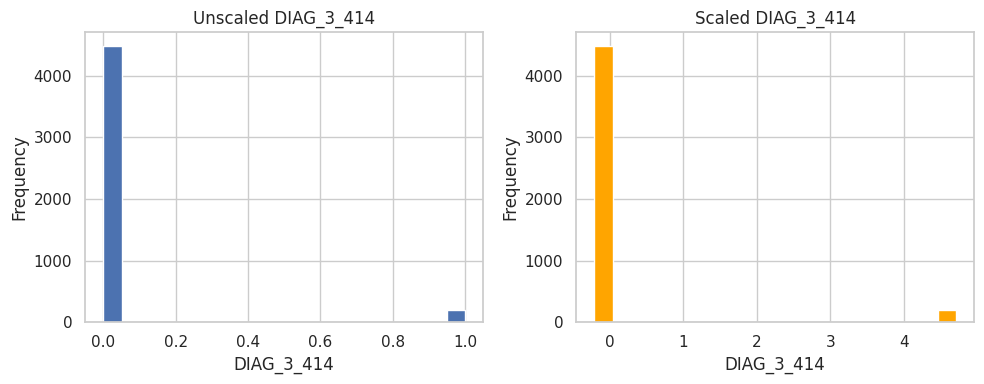

In [163]:
# Plot before after scaling, for a random column

# Step 1: Select a random feature
random_feature = np.random.choice(X_train_noCV_before_scaling.columns)

# Step 2: Plot histograms
plt.figure(figsize=(10, 4))

# Plot for the unscaled DataFrame
plt.subplot(1, 2, 1)  # 1 row, 2 columns, first subplot
X_train_noCV_before_scaling[random_feature].hist(bins=20)
plt.title(f'Unscaled {random_feature}')
plt.xlabel(random_feature)
plt.ylabel('Frequency')

# Plot for the scaled DataFrame
plt.subplot(1, 2, 2)  # 1 row, 2 columns, second subplot
X_train_noCV_scaled[random_feature].hist(bins=20, color='orange')
plt.title(f'Scaled {random_feature}')
plt.xlabel(random_feature)
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


#### 2/ ML pipeline 2 - CV - Model by model

In [261]:
# CV PREPROCESSING - DEFINITION

## Steps
preprocessing_steps_cv = [
    ('filter_medical_specialty', TopCategoriesFilter(column='MEDICAL_SPECIALTY')),
    ('filter_payer_code', TopCategoriesFilter(column='PAYER_CODE')),
    ('filter_diag_1', TopCategoriesFilter(column='DIAG_1')),
    ('filter_diag_2', TopCategoriesFilter(column='DIAG_2')),
    ('filter_diag_3', TopCategoriesFilter(column='DIAG_3')),
    ('ordinal_encoding', CustomOrdinalEncoder(feature_mapping=ordinal_feature_mapping))
]

## Pipeline = Steps + OneHot + Scaling
preprocessing_pipeline_cv = Pipeline(steps=[
    ('preprocessing_cv', Pipeline(steps=preprocessing_steps_cv)),
    ('one_hot_cv', preprocessor_onehot),
    ('standard_scaling', StandardScaler())  # Adding Standard Scaling step
])


##### a/CV - Model 1: LinearSVC

In [262]:
# ML pipeline

## Settings
model = LinearSVC(random_state=RANDOM_STATE)
# model = LinearSVC(random_state=RANDOM_STATE, max_iter=10000)
grid = {
    'model__C': np.logspace(np.log10(0.1), np.log10(10), num=10)
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline_cv),  # Use the previously defined preprocessing pipeline
    ('model', model)
])

# Suppress FutureWarnings related to 'sparse' parameter in OneHotEncoder
warnings.filterwarnings('ignore', category=FutureWarning, message="`sparse` was renamed to `sparse_output`.*")
# warnings.filterwarnings('ignore', category=ConvergeWarning, message="Liblinear failed to converge, increase the number of iterations.")

## Initialisation
results = {}
## Iteration
for metric_name, metric_function in metrics.items():
  ## GRID EVALUATION
  grid_search = GridSearchCV(
      estimator=pipeline,
      param_grid=grid,
      n_jobs=6,
      cv=cv,
      scoring=make_scorer(metric_function),
      error_score=0,
      verbose=1
  )
  grid_result = grid_search.fit(X_train, y_train)

  # After fitting the grid_search
  best_model = grid_search.best_estimator_.named_steps['model']


  ## GRID PREDICTION
  y_hat = grid_search.predict(X_test)

  # RESULTS STORAGE
  results[(model.__class__.__name__, metric_name)] = {
      'params': grid_search.cv_results_['params'],
      'mean_test_score': grid_result.cv_results_['mean_test_score'],
      'std_test_score': grid_result.cv_results_['std_test_score'],
      'test_score': metric_function(y_test, y_hat)
  }

  # RESULTS PRITING
  print(f"\n{model.__class__.__name__} - {metric_name} \nMean Test Score: {results[(model.__class__.__name__, metric_name)]['mean_test_score']} \nStd Test Score: {results[(model.__class__.__name__, metric_name)]['std_test_score']} \nTest Score: {results[(model.__class__.__name__, metric_name)]['test_score']}\n-----------")



Fitting 5 folds for each of 10 candidates, totalling 50 fits

LinearSVC - accuracy 
Mean Test Score: [0.60533618 0.60512273 0.60533618 0.60533618 0.60426894 0.60256137
 0.59978655 0.59359658 0.57716115 0.54770544] 
Std Test Score: [0.01200628 0.01174929 0.01148258 0.01200628 0.01171823 0.01271042
 0.01246429 0.01093383 0.01313004 0.00967366] 
Test Score: 0.6100597609561753
-----------
Fitting 5 folds for each of 10 candidates, totalling 50 fits

LinearSVC - f1 
Mean Test Score: [0.37553248 0.37499557 0.37555423 0.37470313 0.37450881 0.37356383
 0.36853064 0.378223   0.38211787 0.42452701] 
Std Test Score: [0.01736224 0.01653614 0.01567856 0.01676302 0.01570616 0.01361576
 0.01444259 0.01498124 0.02052757 0.02351719] 
Test Score: 0.35362318840579715
-----------
Fitting 5 folds for each of 10 candidates, totalling 50 fits

LinearSVC - precision 
Mean Test Score: [0.54992602 0.54951873 0.55000131 0.55021114 0.54742926 0.54372486
 0.5372901  0.52214366 0.48881972 0.45193107] 
Std Test Scor

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer
from sklearn.svm import LinearSVC
import numpy as np
import warnings

# Settings
RANDOM_STATE = 42  # Define your random state
model = LinearSVC(random_state=RANDOM_STATE)
grid = {
    'model__C': np.logspace(np.log10(0.1), np.log10(10), num=10)
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline_cv),  # Use your previously defined preprocessing pipeline
    ('model', model)
])

# Suppress FutureWarnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Initialisation
results = {}

# Iteration
for metric_name, metric_function in metrics.items():
    # Grid evaluation
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=grid,
        n_jobs=6,
        cv=cv,
        scoring=make_scorer(metric_function),
        error_score=0,
        verbose=1
    )
    grid_result = grid_search.fit(X_train, y_train)

    # After fitting the grid_search, get the best model's coefficients
    best_model = grid_search.best_estimator_.named_steps['model']
    coefficients = best_model.coef_[0]  # Assuming binary classification

    # Get feature names from the preprocessing pipeline
    feature_names = grid_search.best_estimator_.named_steps['preprocessing'].get_feature_names_out()
    importances = dict(zip(feature_names, coefficients))

    print("Feature importances:")
    for feature, importance in sorted(importances.items(), key=lambda item: abs(item[1]), reverse=True):
        print(f"{feature}: {importance}")

    # Grid prediction
    y_hat = grid_search.predict(X_test)

    # Results storage
    results[(model.__class__.__name__, metric_name)] = {
        'params': grid_search.cv_results_['params'],
        'mean_test_score': grid_result.cv_results_['mean_test_score'],
        'std_test_score': grid_result.cv_results_['std_test_score'],
        'test_score': metric_function(y_test, y_hat)
    }

    # Results printing# After fitting the grid_search
best_model = grid_search.best_estimator_.named_steps['model']

# Coefficients from the LinearSVC model
coefficients = best_model.coef_[0]  # Assuming binary classification, adjust indexing for multi-class

# Ensure your preprocessing pipeline supports get_feature_names_out()
feature_names = grid_search.best_estimator_.named_steps['preprocessing'].get_feature_names_out()

# Match the coefficients with their corresponding feature names
importances = dict(zip(feature_names, coefficients))

print("Feature importances:")
for feature, importance in sorted(importances.items(), key=lambda item: abs(item[1]), reverse=True):
    print(f"{feature}: {importance}")

    print(f"\n{model.__class__.__name__} - {metric_name} \nMean Test Score: {results[(model.__class__.__name__, metric_name)]['mean_test_score']} \nStd Test Score: {results[(model.__class__.__name__, metric_name)]['std_test_score']} \nTest Score: {results[(model.__class__.__name__, metric_name)]['test_score']}\n-----------")


In [263]:
# Results Visualisation

## Settings
result_df_LinearSVC = pd.DataFrame.from_dict(results, orient='index')
result_df_LinearSVC.reset_index(inplace=True)
column_name = 'index' if 'index' in result_df_LinearSVC.columns else 'level_0'
result_df_LinearSVC['Metric'] = result_df_LinearSVC[column_name].apply(lambda x: x[1])
result_df_LinearSVC['Model'] = 'LinearSVC'
result_df_LinearSVC.drop(columns=[column_name], inplace=True)
column_order = ['Model', 'Metric'] + [col for col in result_df_LinearSVC.columns if col not in ['Model', 'Metric']]
result_df_LinearSVC = result_df_LinearSVC[column_order]

## Displaying
result_df_LinearSVC.style.background_gradient(cmap="Reds")


In [264]:
import matplotlib.pyplot as plt

# Extract the best model from the grid search
best_model = grid_result.best_estimator_.named_steps['model']

feature_names = X_train.columns

# Extract coefficients
coefficients = best_model.coef_.flatten()

# Map coefficients to feature names
feature_importance = pd.DataFrame({'Feature': feature_names, 'Importance': coefficients})

# Sort features by importance
feature_importance = feature_importance.sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance, y='Feature', x='Importance')
plt.title('Feature Importance')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()


ValueError: All arrays must be of the same length

In [265]:

chosen_model, chosen_metric = 'LinearSVC', 'accuracy'
y_hat = results[(chosen_model, chosen_metric)]['y_hat']  #

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_hat)


KeyError: 'y_hat'

##### b/ CV - Model 2: SVC

In [267]:
# ML pipeline

## Settings

## Defining the model using SVC this time
model = SVC(random_state=RANDOM_STATE)
grid = {
    'model__C': np.logspace(np.log10(0.1), np.log10(10), num=10),
    'model__kernel': ['linear', 'rbf']
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline_cv),  # Use the previously defined preprocessing pipeline
    ('model', model)
])

## Display without non-blocking warning
warnings.filterwarnings('ignore', category=FutureWarning, message="`sparse` was renamed to `sparse_output`.*")

## Initialisation
results = {}
## Iteration
for metric_name, metric_function in metrics.items():
  ## GRID EVALUATION
  grid_search = GridSearchCV(
      estimator=pipeline,
      param_grid=grid,
      n_jobs=6,
      cv=cv,
      scoring=make_scorer(metric_function),
      error_score=0,
      verbose=1
  )
  grid_result = grid_search.fit(X_train, y_train)

  ## GRID PREDICTION
  y_hat = grid_search.predict(X_test)

  # RESULTS STORAGE
  results[(model.__class__.__name__, metric_name)] = {
      'params': grid_search.cv_results_['params'],
      'mean_test_score': grid_result.cv_results_['mean_test_score'],
      'std_test_score': grid_result.cv_results_['std_test_score'],
      'test_score': metric_function(y_test, y_hat)
  }

  # RESULTS PRITING
  print(f"\n{model.__class__.__name__} - {metric_name} \nMean Test Score: {results[(model.__class__.__name__, metric_name)]['mean_test_score']} \nStd Test Score: {results[(model.__class__.__name__, metric_name)]['std_test_score']} \nTest Score: {results[(model.__class__.__name__, metric_name)]['test_score']}\n-----------")




Fitting 5 folds for each of 20 candidates, totalling 100 fits

SVC - accuracy 
Mean Test Score: [0.60192102 0.58377801 0.60170758 0.5886873  0.60085379 0.59871932
 0.60234792 0.60576307 0.60192102 0.6036286  0.60341515 0.6072572
 0.60341515 0.60106724 0.60192102 0.59316969 0.60213447 0.58036286
 0.60298826 0.573746  ] 
Std Test Score: [0.01201766 0.00095456 0.01175705 0.0037338  0.01082074 0.00462742
 0.01306394 0.0022989  0.01250079 0.00512273 0.00988793 0.00654417
 0.01306394 0.01250808 0.01201766 0.013757   0.01181503 0.01916751
 0.01294835 0.01640352] 
Test Score: 0.6125498007968128
-----------
Fitting 5 folds for each of 20 candidates, totalling 100 fits

SVC - f1 
Mean Test Score: [0.27656231 0.00102302 0.27155472 0.04728574 0.27438361 0.12833896
 0.27588005 0.2101229  0.27573803 0.29763941 0.28261082 0.38481488
 0.2799827  0.41959492 0.27294848 0.43976679 0.27440387 0.44743977
 0.28134425 0.45819918] 
Std Test Score: [0.03613361 0.00204604 0.03217526 0.01611418 0.03410782 0.0243

In [268]:

# Convert the results dictionary to a DataFrame for better readability
result_df_SVC = pd.DataFrame.from_dict(results, orient='index')
result_df_SVC.reset_index(inplace=True)
column_name = 'index' if 'index' in result_df_SVC.columns else 'level_0'

result_df_SVC['Metric'] = result_df_SVC[column_name].apply(lambda x: x[1])
result_df_SVC['Model'] = result_df_SVC[column_name].apply(lambda x: x[0])


result_df_SVC.drop(columns=[column_name], inplace=True)
column_order = ['Model', 'Metric'] + [col for col in result_df_SVC.columns if col not in ['Model', 'Metric']]
result_df_SVC = result_df_SVC[column_order]

result_df_SVC.style.background_gradient(cmap="Blues")


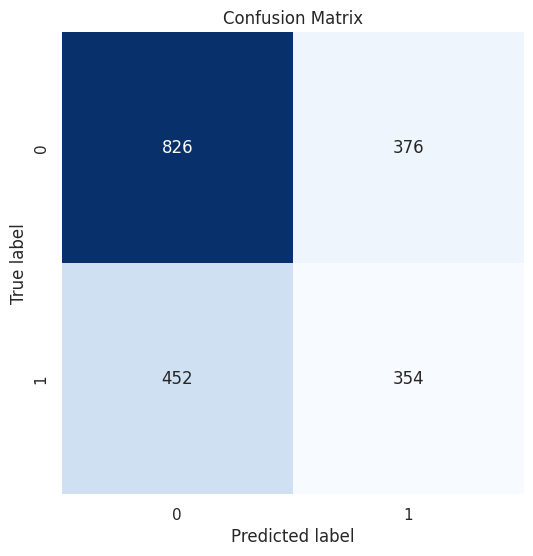

In [269]:
# After the grid search has completed
# 1. Plot Confusion Matrix
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", square=True, cbar=False, cmap="Blues")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [270]:
# 2. Coefficient Importance (for linear kernel only)
if grid_search.best_params_['model__kernel'] == 'linear':
    coefs = grid_search.best_estimator_.named_steps['model'].coef_
    feature_names = preprocessing_pipeline_cv.get_feature_names_out()
    coef_df = pd.DataFrame(coefs, columns=feature_names).transpose()
    coef_df.columns = ['Coefficient']
    coef_df['Absolute'] = coef_df['Coefficient'].abs()
    coef_df = coef_df.sort_values(by='Absolute', ascending=False)

    plt.figure(figsize=(10, 6))
    plt.barh(coef_df.index[:10], coef_df['Coefficient'][:10])
    plt.xlabel('Coefficient Value')
    plt.ylabel('Feature')
    plt.title('Top 10 Feature Coefficients')
    plt.show()

In [ ]:
# 3. Evolution of Metrics as a Function of Hyperparameters
# Example: Plotting mean test score as a function of 'C' for a fixed kernel
results_df = pd.DataFrame(grid_search.cv_results_)
for kernel in ['linear', 'rbf']:
    subset = results_df[results_df['param_model__kernel'] == kernel]
    plt.plot(subset['param_model__C'], subset['mean_test_score'], marker='o', label=kernel)

plt.xlabel('Parameter C')
plt.ylabel('Mean Test Score')
plt.title('Evolution of the Mean Test Score with C for Different Kernels')
plt.legend()
plt.show()


##### c/CV - Model 3: RandomForest

In [272]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier

In [273]:
# ML pipeline

## Settings
###  Decision Trees classifiers and their ensembles

model = RandomForestClassifier(random_state=RANDOM_STATE)
grid = {
    'model__n_estimators': [10, 30, 50, 70, 100, 150],
    'model__max_depth': [None, 5, 10, 15, 20, 25, 30]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline_cv),  # Use the previously defined preprocessing pipeline
    ('model', model)
])


### CV Strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
### Just in case because it happened before
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


## Initialisation
results = {}
## Iteration
for metric_name, metric_function in metrics.items():
  ## GRID EVALUATION
  grid_search = GridSearchCV(
      estimator=pipeline,
      param_grid=grid,
      n_jobs=6,
      cv=cv,
      scoring=make_scorer(metric_function),
      error_score=0,
      verbose=1
  )
  grid_result = grid_search.fit(X_train, y_train)

  ## GRID PREDICTION
  y_hat = grid_search.predict(X_test)

  # RESULTS STORAGE
  results[(model.__class__.__name__, metric_name)] = {
      'params': grid_search.cv_results_['params'],
      'mean_test_score': grid_result.cv_results_['mean_test_score'],
      'std_test_score': grid_result.cv_results_['std_test_score'],
      'test_score': metric_function(y_test, y_hat)
  }

  # RESULTS PRITING
  print(f"\n{model.__class__.__name__} - {metric_name} \nMean Test Score: {results[(model.__class__.__name__, metric_name)]['mean_test_score']} \nStd Test Score: {results[(model.__class__.__name__, metric_name)]['std_test_score']} \nTest Score: {results[(model.__class__.__name__, metric_name)]['test_score']}\n-----------")




Fitting 5 folds for each of 42 candidates, totalling 210 fits

RandomForestClassifier - accuracy 
Mean Test Score: [0.57972252 0.60128068 0.61109925 0.61387407 0.61963714 0.62006403
 0.60597652 0.60277481 0.60341515 0.60213447 0.59978655 0.59978655
 0.59573106 0.60426894 0.60256137 0.60533618 0.60320171 0.60490928
 0.58740662 0.60554963 0.61664888 0.62198506 0.62219851 0.62049093
 0.59850587 0.61045891 0.61387407 0.6189968  0.62091782 0.62326574
 0.58591249 0.60661686 0.6113127  0.61707577 0.62326574 0.62753469
 0.58377801 0.60554963 0.6153682  0.62155816 0.62326574 0.62646745] 
Std Test Score: [0.0099979  0.01051322 0.0158383  0.0169875  0.01252991 0.01684746
 0.00936252 0.00593828 0.00450773 0.00696244 0.00592292 0.00527176
 0.010787   0.0057828  0.00475369 0.00545857 0.00412787 0.00816697
 0.00646008 0.01079123 0.006201   0.01093383 0.01222439 0.01085437
 0.01136293 0.00369701 0.00841426 0.01045673 0.01140295 0.00845747
 0.01240934 0.00516701 0.00911597 0.00914092 0.00872265 0.00772

In [274]:
# Results Visualisation

## Settings
results_df_Ensemble = pd.DataFrame.from_dict(results, orient='index')
results_df_Ensemble.reset_index(inplace=True)
results_df_Ensemble.rename(columns={'index': 'Model'}, inplace=True)

## Displaying
results_df_Ensemble.style.background_gradient(cmap="Blues")



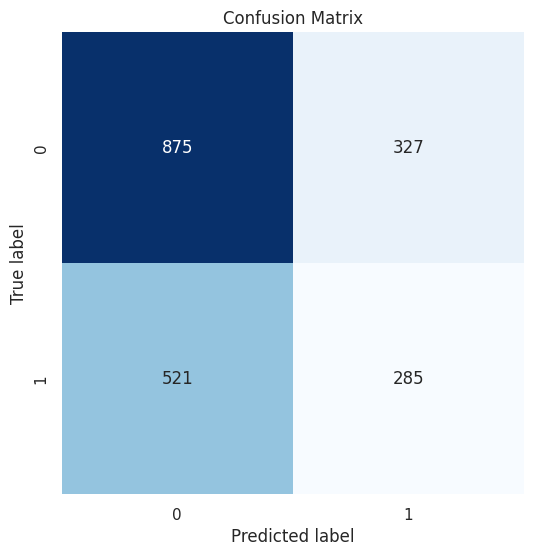

In [275]:
# 1. Confusion Matrix
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", square=True, cbar=False, cmap="Blues")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [277]:
# 2. Feature Importances
fitted_model = grid_search.best_estimator_.named_steps['model']
feature_importances = fitted_model.feature_importances_
feature_names = preprocessing_pipeline_cv.get_feature_names_out()]

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.show()


AttributeError: Estimator filter_medical_specialty does not provide get_feature_names_out. Did you mean to call pipeline[:-1].get_feature_names_out()?

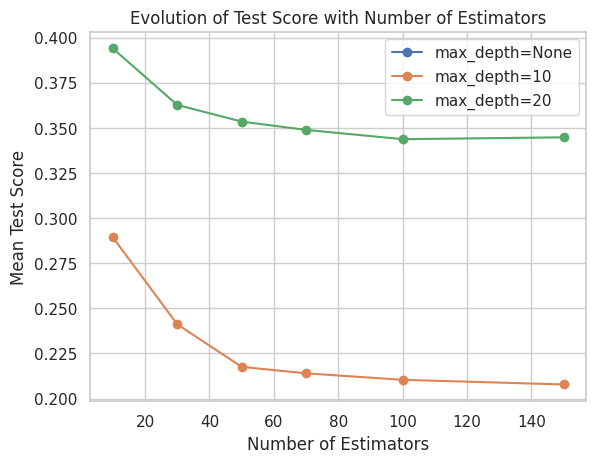

In [278]:
# 3. Evolution of Metrics as a Function of Hyperparameters
# Example: Plotting mean test score as a function of 'n_estimators' for a fixed 'max_depth'
results_df = pd.DataFrame(grid_search.cv_results_)

for depth in [None, 10, 20]:
    subset = results_df[results_df['param_model__max_depth'] == depth]
    plt.plot(subset['param_model__n_estimators'], subset['mean_test_score'], marker='o', label=f'max_depth={depth}')

plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.title('Evolution of Test Score with Number of Estimators')
plt.legend()
plt.show()

##### d/CV - Model 4: GradientBoosting

In [279]:
# ML pipeline

## Settings
###  Decision Trees classifiers and their ensembles
model=GradientBoostingClassifier(n_estimators=100, random_state=RANDOM_STATE)
### Parameter grids
grid = {
    'model__n_estimators': [100, 150, 200, 250, 300],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'model__max_depth': [3, 4, 5, 6, 7]
}
### CV Strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
### Just in case because it happened before
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

pipeline = Pipeline([
    ('preprocessing', preprocessing_pipeline_cv),  # Use the previously defined preprocessing pipeline
    ('model', model)
])
## Initialisation
results = {}
## Iteration
for metric_name, metric_function in metrics.items():
  ## GRID EVALUATION
  grid_search = GridSearchCV(
      estimator=pipeline,
      param_grid=grid,
      n_jobs=6,
      cv=cv,
      scoring=make_scorer(metric_function),
      error_score=0,
      verbose=1
  )
  grid_result = grid_search.fit(X_train, y_train)

  ## GRID PREDICTION
  y_hat = grid_search.predict(X_test)

  # RESULTS STORAGE
  results[(model.__class__.__name__, metric_name)] = {
      'params': grid_search.cv_results_['params'],
      'mean_test_score': grid_result.cv_results_['mean_test_score'],
      'std_test_score': grid_result.cv_results_['std_test_score'],
      'test_score': metric_function(y_test, y_hat)
  }

  # RESULTS PRITING
  print(f"\n{model.__class__.__name__} - {metric_name} \nMean Test Score: {results[(model.__class__.__name__, metric_name)]['mean_test_score']} \nStd Test Score: {results[(model.__class__.__name__, metric_name)]['std_test_score']} \nTest Score: {results[(model.__class__.__name__, metric_name)]['test_score']}\n-----------")




Fitting 5 folds for each of 125 candidates, totalling 625 fits


KeyboardInterrupt: 

In [ ]:
# Results Visualisation

## Settings
results_df_Ensemble = pd.DataFrame.from_dict(results, orient='index')
results_df_Ensemble.reset_index(inplace=True)
results_df_Ensemble.rename(columns={'index': 'Model'}, inplace=True)

## Displaying
results_df_Ensemble.style.background_gradient(cmap="Blues")



In [ ]:
# 1. Confusion Matrix
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", square=True, cbar=False, cmap="Blues")
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# 2. Feature Importances
fitted_model = grid_search.best_estimator_.named_steps['model']
feature_importances = fitted_model.feature_importances_
feature_names = preprocessing_pipeline_cv.get_feature_names_out()


importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df.head(10))
plt.title('Top 10 Feature Importances')
plt.show()

In [ ]:

# 3. Evolution of Metrics as a Function of Hyperparameters
# Example: Plotting mean test score as a function of 'n_estimators' for a fixed 'learning_rate' and 'max_depth'
results_df = pd.DataFrame(grid_search.cv_results_)
fixed_learning_rate = 0.1
fixed_max_depth = 5

subset = results_df[(results_df['param_model__learning_rate'] == fixed_learning_rate) &
                    (results_df['param_model__max_depth'] == fixed_max_depth)]
plt.plot(subset['param_model__n_estimators'], subset['mean_test_score'], marker='o', label=f'LR={fixed_learning_rate}, Depth={fixed_max_depth}')

plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.title('Evolution of Test Score with Number of Estimators')
plt.legend()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Access the fitted model
fitted_model = grid_search.best_estimator_.named_steps['model']

# Get feature importances
feature_importances = fitted_model.feature_importances_
feature_names = preprocessing_pipeline_cv.get_feature_names_out()

# Sort features by importance
sorted_idx = np.argsort(feature_importances)
sorted_importances = feature_importances[sorted_idx]
sorted_features = [feature_names[idx] for idx in sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Name')
plt.title('Feature Importances in Gradient Boosting Model')
plt.show()


In [ ]:
for metric_name, metric_function in metrics.items():
  ## GRID EVALUATION
  grid_search = GridSearchCV(
      estimator=pipeline,
      param_grid=grid,
      n_jobs=6,
      cv=cv,
      scoring=make_scorer(metric_function),
      error_score=0,
      verbose=1
  )
  grid_result = grid_search.fit(X_train, y_train)

  ## GET FEATURE IMPORTANCES
  best_estimator = grid_search.best_estimator_  # Get the best model from grid search
  feature_importances = best_estimator.feature_importances_  # Extract feature importances

  ## GRID PREDICTION (unchanged)
  y_hat = grid_search.predict(X_test)

  # RESULTS STORAGE (add feature importances)
  results[(model.__class__.__name__, metric_name)] = {
      'params': grid_search.cv_results_['params'],
      'mean_test_score': grid_result.cv_results_['mean_test_score'],
      'std_test_score': grid_result.cv_results_['std_test_score'],
      'test_score': metric_function(y_test, y_hat),
      'feature_importances': feature_importances
  }

  # RESULTS PRINTING (unchanged)
  print(f"\n{model.__class__.__name__} - {metric_name} \nMean Test Score: {results[(model.__class__.__name__, metric_name)]['mean_test_score']} \nStd Test Score: {results[(model.__class__.__name__, metric_name)]['std_test_score']} \nTest Score: {results[(model.__class__.__name__, metric_name)]['test_score']}\n-----------")


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Get feature names from the pipeline
feature_names = pipeline.named_steps['preprocessing'].get_feature_names_out(X_train)

# Access results for a specific model and metric
model_name, metric_name = "GradientBoostingClassifier", "accuracy"  # Update as needed
feature_importances = results[(model_name, metric_name)]['feature_importances']

# Create a pandas Series for easy plotting
importance_series = pd.Series(feature_importances, index=feature_names)

# Plot the feature importance
importance_series.plot(kind='barh')
plt.xlabel("Feature Importance")
plt.ylabel("Feature Name")
plt.title(f"Feature Importance for {model_name} - {metric_name}")
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Access the fitted model
fitted_model = grid_search.best_estimator_.named_steps['model']

# Get feature importances
feature_importances = fitted_model.feature_importances_

# Use indices as feature names if actual names are not available
feature_names = np.arange(len(feature_importances))

# Sort features by importance
sorted_idx = np.argsort(feature_importances)
sorted_importances = feature_importances[sorted_idx]
sorted_features = [feature_names[idx] for idx in sorted_idx]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Index')
plt.title('Feature Importances in Gradient Boosting Model')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Access the fitted model
fitted_model = grid_search.best_estimator_.named_steps['model']

# Get feature importances
feature_importances = fitted_model.feature_importances_

# Use indices as feature names if actual names are not available
feature_names = np.arange(len(feature_importances))

# Sort features by importance
sorted_idx = np.argsort(feature_importances)[::-1]  # Reverse to have the highest importance first
sorted_importances = feature_importances[sorted_idx]
sorted_features = [feature_names[idx] for idx in sorted_idx]

# Keep only the top feature for display
top_feature_importances = sorted_importances[:1]
top_features = [sorted_features[0]]

# Plot
plt.figure(figsize=(5, 1))  # Adjusted for displaying only the top feature
plt.barh(top_features, top_feature_importances)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Index')
plt.title('Top Feature Importance in Gradient Boosting Model')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Access the fitted model
fitted_model = grid_search.best_estimator_.named_steps['model']

# Get feature importances
feature_importances = fitted_model.feature_importances_

# Use indices as feature names if actual names are not available
feature_names = np.arange(len(feature_importances))

# Select the top 10 features and their indices
top_10_idx = np.argsort(feature_importances)[-10:]
top_10_importances = feature_importances[top_10_idx]
top_10_features = [feature_names[idx] for idx in top_10_idx]

# Sort the top 10 features by importance
sorted_idx_top_10 = np.argsort(top_10_importances)
sorted_importances_top_10 = top_10_importances[sorted_idx_top_10]
sorted_features_top_10 = [top_10_features[idx] for idx in sorted_idx_top_10]

# Plot
plt.figure(figsize=(10, 6))
plt.barh(sorted_features_top_10, sorted_importances_top_10)
plt.xlabel('Feature Importance')
plt.ylabel('Feature Index/Name')
plt.title('Top 10 Feature Importances in Gradient Boosting Model')
plt.show()


In [ ]:
X_train.shape

In [ ]:
import pandas as pd

# Get feature importances
feature_importances = fitted_model.feature_importances_

feature_names_approx = ['Feature_' + str(i) for i in range(len(feature_importances))]

# Create a DataFrame with feature names and their importances
feature_importance_df = pd.DataFrame({
    'Feature Index': range(len(feature_importances)),
    'Feature Name (Approx)': feature_names_approx,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

feature_importance_df


##  IV. Model Interpretation (10%)
- Create figures/plots to show the relative importance of different features for thefour models. You can plot the models’ coefficients (for linear models) or the featureimportance (for tree-based models). Alternatively, use other potential strategies toidentify relevant features to the model. (5%)
- Describe the similarities and differences of the features identified by the differentmodels. (2.5%)
- Discuss if the features identified by the different models make sense (or not) withrespect to the task. (2.5%)

In [ ]:
models

In [ ]:
Feature_Importance_Models={'RandomForestClassifier': RandomForestClassifier(max_depth=10, random_state=RANDOM_STATE),'GradientBoostingClassifier': GradientBoostingClassifier(random_state=RANDOM_STATE) }
Linear_Models={'LinearSVC': LinearSVC(C=5, random_state=42),
 'SVC': SVC(C=10, kernel='linear', random_state=42)}


### 1/ Feature Importance

In [ ]:
# Feature Importance - top 20

# Initialize and train the Random Forest model

top_n = 20

for model_name, model in Feature_Importance_Models.items():
  # Fit the model
  model.fit(X_train, y_train)

  # Get feature importances
  feature_importances = model.feature_importances_

  # Convert the feature importances to a pandas Series for easy plotting
  importances_series = pd.Series(feature_importances, index=X_train.columns)

  # Sort the series to ensure that the most important features are at the top
  importances_series = importances_series.sort_values(ascending=False)

  # Plot the feature importances of the top N features
  importances_series[:top_n].plot(kind='bar', figsize=(10, 6))  # Increase figure size
  plt.title(f'Top 20 Feature Importance for {model_name}')
  plt.xlabel('Features')
  plt.ylabel('Importance Score')
  # plt.xticks(rotation=45)  # Rotate labels to 45 degrees and adjust font size
  # plt.tight_layout()
  plt.show()


In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=RANDOM_STATE, n_jobs=-1)

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
plt.title("Permutation Importance")
plt.tight_layout()
plt.show()


### 2/ Coefficients importance

In [ ]:
# Feature Importance - top 20

# Initialize and train the Random Forest model

top_n = 20

for model_name, model in Linear_Models.items():
  # Fit the model
  model.fit(X_train, y_train)

  # Get feature importances
  coef = model.coef_.flatten()

  # Convert the feature importances to a pandas Series for easy plotting
  coef_series = pd.Series(feature_importances, index=X_train.columns)

  # Sort the series to ensure that the most important features are at the top
  coef_series = coef_series.sort_values(ascending=False)

  # Plot the feature importances of the top N features
  coef_series[:top_n].plot(kind='bar', figsize=(10, 6))  # Increase figure size
  plt.title(f'Top 20 Coef for {model_name}')
  plt.xlabel('Features')
  plt.ylabel('Coef')
  # plt.xticks(rotation=45)  # Rotate labels to 45 degrees and adjust font size
  # plt.tight_layout()
  plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming X_train is a DataFrame with column names representing features
feature_names = X_train.columns

# Create figure and axes for the subplots
fig = plt.figure(figsize=(15, 12))

# Add a subplot for LinearSVC at the top
if 'LinearSVC' in models:
    ax1 = fig.add_subplot(2, 2, (1, 2))  # Spans the first row
    coef_LinearSVC = models['LinearSVC'].coef_.flatten()
    # Get the indices of the 20 largest coefficients by absolute value
    indices = np.argsort(np.abs(coef))[-20:]
    ax1.barh(np.array(feature_names)[indices], coef[indices])
    ax1.set_title('LinearSVC Feature Importances (Top 20 Coefficients)')
    ax1.set_xlabel('Coefficient Value')

# Add a subplot for SVC on the bottom left, if it's a linear kernel
if 'SVC' in models and models['SVC'].kernel == 'linear':
    ax2 = fig.add_subplot(2, 2, 3)
    coef_SVC = models['SVC'].coef_.flatten()
    # Get the indices of the 20 largest coefficients by absolute value
    indices = np.argsort(np.abs(coef))[-20:]
    ax2.barh(np.array(feature_names)[indices], coef[indices])
    ax2.set_title('SVC Feature Importances (Top 20 Coefficients)')
    ax2.set_xlabel('Coefficient Value')

# Add a subplot for RandomForestClassifier on the bottom right
if 'RandomForestClassifier' in models:
    ax3 = fig.add_subplot(2, 2, 4)
    importances = models['RandomForestClassifier'].feature_importances_
    # Get the indices of the 20 most important features
    indices = np.argsort(importances)[-20:]
    ax3.barh(range(20), importances[indices], align='center')
    # Set the yticks to be the feature names corresponding to the top indices
    ax3.set_yticks(range(20))
    ax3.set_yticklabels(np.array(feature_names)[indices])
    ax3.set_title('RandomForest Feature Importances (Top 20)')
    ax3.set_xlabel('Relative Importance')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

def get_top_features(model, feature_names, n=20):
    # For linear models, use coefficients
    if hasattr(model, 'coef_'):
        coefs = model.coef_.flatten()
        top_features_idx = np.argsort(np.abs(coefs))[-n:]
        return pd.Series(coefs[top_features_idx], index=np.array(feature_names)[top_features_idx])
    # For tree-based models, use feature importances
    elif hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        top_features_idx = np.argsort(importances)[-n:]
        return pd.Series(importances[top_features_idx], index=np.array(feature_names)[top_features_idx])
    else:
        # If model doesn't have coef_ or feature_importances_
        return pd.Series([np.nan]*n, index=['']*n)

# Assuming feature_names is a list of all feature names
feature_names = X_train.columns

# Create a DataFrame to hold the feature importances
df_features = pd.DataFrame(index=range(1, 21))  # Top 20 features

# Add columns for each model
if 'LinearSVC' in models:
    df_features['LinearSVC'] = get_top_features(models['LinearSVC'], feature_names)

if 'SVC' in models and models['SVC'].kernel == 'linear':
    df_features['SVC'] = get_top_features(models['SVC'], feature_names)

if 'RandomForestClassifier' in models:
    df_features['RandomForest'] = get_top_features(models['RandomForestClassifier'], feature_names)

# Show the DataFrame
display(df_features)


In [ ]:
import pandas as pd

# Create DataFrames for each model's feature importances
if 'LinearSVC' in models:
    # Get the indices of the 20 largest coefficients by absolute value
    indices_LinearSVC = np.argsort(np.abs(models['LinearSVC'].coef_.flatten()))[-20:]
    # Create a DataFrame for LinearSVC feature importances
    df_LinearSVC = pd.DataFrame({
        'Feature': np.array(feature_names)[indices_LinearSVC],
        'Importance': models['LinearSVC'].coef_.flatten()[indices_LinearSVC]
    }).sort_values(by='Importance', ascending=False)

if 'SVC' in models and models['SVC'].kernel == 'linear':
    # Get the indices of the 20 largest coefficients by absolute value
    indices_SVC = np.argsort(np.abs(models['SVC'].coef_.flatten()))[-20:]
    # Create a DataFrame for SVC feature importances
    df_SVC = pd.DataFrame({
        'Feature': np.array(feature_names)[indices_SVC],
        'Importance': models['SVC'].coef_.flatten()[indices_SVC]
    }).sort_values(by='Importance', ascending=False)

if 'RandomForestClassifier' in models:
    # Get the indices of the 20 most important features
    indices_RandomForest = np.argsort(models['RandomForestClassifier'].feature_importances_)[-20:]
    # Create a DataFrame for RandomForest feature importances
    df_RandomForest = pd.DataFrame({
        'Feature': np.array(feature_names)[indices_RandomForest],
        'Importance': models['RandomForestClassifier'].feature_importances_[indices_RandomForest]
    }).sort_values(by='Importance', ascending=False)

# Display the tables
if 'LinearSVC' in models:
    # print("LinearSVC Feature Importances")
    display(df_LinearSVC)

if 'SVC' in models and models['SVC'].kernel == 'linear':
    # print("\nSVC Feature Importances")
    display(df_SVC)

if 'RandomForestClassifier' in models:
    # print("\nRandomForest Feature Importances")
    display(df_RandomForest)


In [ ]:
# Initialize an empty DataFrame to hold the concatenated results
df_concatenated = pd.DataFrame(index=feature_names)

# Function to get rankings
def get_rankings(importances, features, model_name):
    # Create a DataFrame with importances and corresponding feature names
    df = pd.DataFrame({model_name: importances}, index=features)
    # Rank the importances and convert to integer type
    df[model_name] = df[model_name].rank(ascending=False).astype(int)
    return df


# Add rankings for each model to the DataFrame
# Add rankings for each model to the DataFrame
if 'LinearSVC' in models:
    df_concatenated = df_concatenated.merge(
        get_rankings(coef_LinearSVC[indices_LinearSVC], np.array(feature_names)[indices_LinearSVC], 'LinearSVC'),
        left_index=True,  # Use the index of the left DataFrame for merging
        right_index=True,  # Use the index of the right DataFrame for merging
        how='left'
    )

# Repeat for other models...


if 'SVC' in models and models['SVC'].kernel == 'linear':
    df_concatenated = df_concatenated.merge(
        get_rankings(coef_SVC[indices_SVC], np.array(feature_names)[indices_SVC], 'SVC'),
        left_index=True,  # Use the index of the left DataFrame for merging
        right_index=True,  # Use the index of the right DataFrame for merging
        how='left'
    )

if 'RandomForestClassifier' in models:
    df_concatenated = df_concatenated.merge(
        get_rankings(importances[indices_RandomForest], np.array(feature_names)[indices_RandomForest], 'RandomForest'),
        left_index=True,  # Use the index of the left DataFrame for merging
        right_index=True,  # Use the index of the right DataFrame for merging
        how='left'
    )

# Replace NaN values with a large number indicating a low importance rank
df_concatenated.fillna(len(feature_names) + 1, inplace=True)
# Convert ranks to integers
df_concatenated = df_concatenated.astype(int)

# Display the concatenated DataFrame
df_concatenated.sort_index().style.background_gradient(cmap='coolwarm')


In [ ]:
# Initialize an empty DataFrame for the ranked features
df_ranked_features = pd.DataFrame()

# Function to get sorted features by importance
def get_sorted_features(importances, features, model_name):
    # Sort the features by their importance in descending order
    sorted_indices = np.argsort(-importances)
    sorted_features = features[sorted_indices]
    # Create a Series with the sorted features
    return pd.Series(sorted_features, name=model_name)

# Populate the DataFrame with ranked features for each model
if 'LinearSVC' in models:
    df_ranked_features['LinearSVC'] = get_sorted_features(
        np.abs(models['LinearSVC'].coef_.flatten()),
        np.array(feature_names),
        'LinearSVC'
    )

if 'SVC' in models and models['SVC'].kernel == 'linear':
    df_ranked_features['SVC'] = get_sorted_features(
        np.abs(models['SVC'].coef_.flatten()),
        np.array(feature_names),
        'SVC'
    )

if 'RandomForestClassifier' in models:
    df_ranked_features['RandomForest'] = get_sorted_features(
        models['RandomForestClassifier'].feature_importances_,
        np.array(feature_names),
        'RandomForest'
    )

# Display the DataFrame with ranked features
df_ranked_features.head(10)


In [ ]:
df_ranked_features.head(10).style.background_gradient(cmap='coolwarm')

In [ ]:
import pandas as pd
import numpy as np
from sklearn.inspection import permutation_importance

# Assuming feature_names is a list of all feature names
feature_names = X_train.columns

# Function to get top features for a model
def get_top_features(model, X, y, feature_names, n=20):
    try:
        # For models with coefficients
        if hasattr(model, 'coef_') and model.coef_.size == len(feature_names):
            coefs = model.coef_.flatten()
            top_features_idx = np.argsort(np.abs(coefs))[-n:]
            return pd.Series(coefs[top_features_idx], index=np.array(feature_names)[top_features_idx])
        # For models with feature importances
        elif hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
            top_features_idx = np.argsort(importances)[-n:]
            return pd.Series(importances[top_features_idx], index=np.array(feature_names)[top_features_idx])
        # For models without coefficients or feature importances, use permutation importance
        else:
            result = permutation_importance(model, X, y, n_repeats=10, random_state=42, n_jobs=-1)
            sorted_idx = result.importances_mean.argsort()[-n:]
            return pd.Series(result.importances_mean[sorted_idx], index=np.array(feature_names)[sorted_idx])
    except Exception as e:
        # If any error occurs during the process
        print(f"An error occurred: {e}")
        return pd.Series([np.nan]*n, index=['']*n)

# Create a DataFrame to hold the feature importances
df_features = pd.DataFrame()

# Add columns for each model
if 'LinearSVC' in models:
    df_features['LinearSVC'] = get_top_features(models['LinearSVC'], X_train, y_train, feature_names)

if 'SVC' in models and models['SVC'].kernel == 'linear':
    df_features['SVC'] = get_top_features(models['SVC'], X_train, y_train, feature_names)

if 'RandomForestClassifier' in models:
    df_features['RandomForest'] = get_top_features(models['RandomForestClassifier'], X_train, y_train, feature_names)

# Display the DataFrame with feature names as the index
df_features.index.name = 'Feature'
print(df_features)


### 3/ other information

In [ ]:
num_cols

In [ ]:
# Corelation matrix

# Ensure that the correlation is computed only for numeric columns
corr_matrix = X_train[num_cols].corr(numeric_only=True)

# Check if the correlation matrix is empty
if corr_matrix.size == 0:
    print("No numeric columns to compute correlation.")
else:
    plt.figure(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, cmap="magma", fmt='.2f')
    plt.show()


##  V. Alternative ML pipeline (20%)


In [ ]:
# Iterate over each model
## Initialisation
results = {}
for model_name, model in models.items():
    # Define parameter grid for each model
    grid = params_dict[model_name]

    # Wrap the model in a pipeline that includes preprocessing
    model_pipeline = Pipeline(steps=[
        ('preprocessing', preprocessing_pipeline_cv),
        ('model', model)
    ])

    # Iterate over each metric
    for metric_name, metric_function in metrics.items():
        grid_search = GridSearchCV(
            estimator=model_pipeline,
            param_grid=grid,
            n_jobs=6,
            cv=cv,
            scoring=make_scorer(metric_function),
            error_score=0,
            verbose=1,
        )

        grid_result = grid_search.fit(X_train, y_train)
        best_estimator = grid_search.best_estimator_
        y_hat = grid_search.predict(X_test)

        if metric_name == 'f1':
            test_score = metric_function(y_test, y_hat, average='binary')
        else:
            test_score = metric_function(y_test, y_hat)

        conf_matrix = confusion_matrix(y_test, y_hat)

        results[(model_name, metric_name)] = {
            'best_estimator': best_estimator,
            'conf_matrix': conf_matrix,
            'params': grid_search.cv_results_['params'],
            'mean_test_score': grid_search.cv_results_['mean_test_score'],
            'std_test_score': grid_search.cv_results_['std_test_score'],
            'test_score': test_score
        }

        # Print the results for this model-metric combination
        print(f" \n {model_name} - {metric_name} \n Mean Test Score: {results[(model_name, metric_name)]['mean_test_score']} \n Std Test Score: {results[(model_name, metric_name)]['std_test_score']} \n Test Score: {results[(model_name, metric_name)]['test_score']} \n -----------")


In [ ]:
# # prompt: Implement Nested Cross Validation

# from sklearn.model_selection import GridSearchCV, StratifiedKFold

# # Define the outer and inner cross-validation folds

# outer_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
# inner_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# # Define the grid search parameters for the RandomForestClassifier
# param_grid = {
#     'max_depth': [10, 50, 100],
#     'max_features': [0.5, 0.7, 1.0],
# }

# # Initialize the outer loop
# for train_idx, test_idx in outer_cv.split(X, y):
#     X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
#     y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

#     # Initialize the inner loop
#     for i, (inner_train_idx, inner_test_idx) in enumerate(inner_cv.split(X_train, y_train)):
#         X_inner_train, X_inner_test = X_train.iloc[inner_train_idx], X_train.iloc[inner_test_idx]
#         y_inner_train, y_inner_test = y_train.iloc[inner_train_idx], y_train.iloc[inner_test_idx]

#         # Perform grid search on the inner fold
#         grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=3, n_jobs=-1, verbose=1)
#         grid_search.fit(X_inner_train, y_inner_train)

#         # Evaluate the best model on the inner test set
#         print(f"Inner fold {i+1}: Best score: {grid_search.best_score_}")

#     # Evaluate the best model on the outer test set
#     best_model = grid_search.best_estimator_
#     print(f"Outer fold: Test score: {best_model.score(X_test, y_test)}")



In [ ]:
# # FROM TUTORIAL

# score = []
# model_knn = KNeighborsClassifier()
# k_range = np.arange(1, 10)
# # define grid search
# grid = dict(n_neighbors=k_range)
# for i, (train_index, test_index) in enumerate(outer_cv.split(df_dropna)):
#   train_data = df_dropna.iloc[train_index].drop(["Y"], axis=1)
#   test_data = df_dropna.iloc[test_index].drop(["Y"], axis=1)
#   train_data_y = np.where(df_dropna.iloc[train_index]["Y"] == ">50K", 1, 0)
#   test_data_y = np.where(df_dropna.iloc[test_index]["Y"] == ">50K", 1, 0)
#   transformed_train_tem = ct1.fit_transform(train_data, train_data_y)
#   transformed_test_tem = ct1.transform(test_data)
#   grid_search = GridSearchCV(
#         estimator=model_knn,
#         param_grid=grid,
#         pre_dispatch = 6,
#         n_jobs=6,
#         cv=inner_cv,
#         scoring="accuracy",
#         error_score=0,
#         verbose=1,
#         )
#   grid_result = grid_search.fit(transformed_train_tem, train_data_y)
#   model_knn = KNeighborsClassifier(n_neighbors = grid_result.best_params_["n_neighbors"])
#   model_knn.fit(transformed_train_tem, train_data_y)
#   y_hat_knn = model_knn.predict(transformed_test_tem)
#   score.append(accuracy_score(y_hat_knn, test_data_y))




